In [1]:
import os
import sys
import numpy as np
import glob
import pandas as pd
import shutil
import gzip
import nibabel
import scipy.io
import h5py
import matplotlib.pyplot as plt
import seaborn as sns
from nilearn.connectome import vec_to_sym_matrix
import scipy.stats
import utils
import math
from mne_connectivity.viz import plot_connectivity_circle
from mne.viz import circular_layout

# ASD and TD analysis for K = 4

In [2]:
path = './Data_CCS/All_age_groups_ccs/Outputs_ccs_nfng_all/DFNC_all_ccs/'
dfnc = h5py.File(path + 'All_age_ccs__dfnc_K4_L1_ws20_city.mat')
dfnc.keys()

<ipython-input-2-d6f23635a70a>:2: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  dfnc = h5py.File(path + 'All_age_ccs__dfnc_K4_L1_ws20_city.mat')


<KeysViewHDF5 ['#refs#', 'dfncInfo']>

In [3]:
dfnc['dfncInfo']['postprocess'].keys()

<KeysViewHDF5 ['dmethod', 'estimate_clusters', 'ica', 'kmeans_max_iter', 'kmeans_num_replicates', 'kmeans_start', 'meta_method', 'num_clusters', 'num_tests_est_clusters', 'regressCovFile']>

In [4]:
asd_idx = np.array(range(188), dtype = 'uint32')
td_idx = np.array(range(188,383), dtype = 'uint32')
groups = {'ASD' : asd_idx, 'TD' : td_idx}
print('Number of ASD subjects : ', len(asd_idx))
print('Number of TD subjects : ', len(td_idx))

Number of ASD subjects :  188
Number of TD subjects :  195


## Distribution of Windows per state per group 

In [11]:
pp = h5py.File(path + './All_age_ccs__dfnc_post_process_K4_L1_ws20_city.mat')
pp.keys()

<ipython-input-11-f9c5c5f100d0>:1: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  pp = h5py.File(path + './All_age_ccs__dfnc_post_process_K4_L1_ws20_city.mat')


<KeysViewHDF5 ['#refs#', 'FNCamp', 'FNCcm', 'clusterInfo', 'meta_states_info', 'tvdfncInfo']>

In [12]:
states = pp['clusterInfo']['states']
states = np.squeeze(states, 1)                             # Every window has its own state
print('State array shape : ', states.shape)                # (n_windows, n_subjects)
asd_states = states[:, asd_idx]
td_states = states[:, td_idx]
print('Number of windows')
print('ASD : ', np.unique(asd_states, return_counts=True))
print('_' * 10)
print('TD : ', np.unique(td_states, return_counts=True))

State array shape :  (155, 383)
Number of windows
ASD :  (array([1., 2., 3., 4.]), array([ 2241,  5333,  4849, 16717]))
__________
TD :  (array([1., 2., 3., 4.]), array([ 3653,  6575,  6583, 13414]))


## Two Sample-T test

In [135]:
cs = scipy.io.loadmat(path + 'Stats_L1_ws20_city/All_age_ccs__dfnc_cluster_stats.mat')
print('Cluster stats using GIFT mat file keys : ', cs.keys())
dfnc_corrs = cs['dfnc_corrs']
dfnc_corrs = np.squeeze(dfnc_corrs)
dfnc_corrs.shape           # (n_subjects, states_vector_length, n_states)

Cluster stats using GIFT mat file keys :  dict_keys(['__header__', '__version__', '__globals__', 'thresholdWindows', 'dfnc_corrs', 'state_vector_stats', 'nuisance_cov_file'])


(383, 1378, 4)

In [136]:
dfnc_dict = utils.get_groups_dfnc(dfnc_corrs, groups, n_states = 4, mode = 'all')
print('Keys in dfnc_dict : ', list(dfnc_dict.keys()))        # Keys = States
print('Keys in dfnc_dict[0] : ', list(dfnc_dict[0].keys()))  
print('Shape of dfnc_dict[0]["ASD"] : ',dfnc_dict[0]["ASD"].shape)
print('Shape of dfnc_dict[0]["TD"] : ',dfnc_dict[0]["TD"].shape)

State :  1
Group : ASD and DFNC shape : (59, 1378)
Group : TD and DFNC shape : (79, 1378)
------------------------------------------------
State :  2
Group : ASD and DFNC shape : (145, 1378)
Group : TD and DFNC shape : (165, 1378)
------------------------------------------------
State :  3
Group : ASD and DFNC shape : (131, 1378)
Group : TD and DFNC shape : (158, 1378)
------------------------------------------------
State :  4
Group : ASD and DFNC shape : (185, 1378)
Group : TD and DFNC shape : (187, 1378)
------------------------------------------------
Keys in dfnc_dict :  [0, 1, 2, 3]
Keys in dfnc_dict[0] :  ['ASD', 'TD']
Shape of dfnc_dict[0]["ASD"] :  (59, 1378)
Shape of dfnc_dict[0]["TD"] :  (79, 1378)


**The above values were cross-checked with GIFT results**

In [15]:
t1, p1 = utils.two_sample_ttest(dfnc_dict, state = 0)
t2, p2 = utils.two_sample_ttest(dfnc_dict, state = 1)
t3, p3 = utils.two_sample_ttest(dfnc_dict, state = 2)
t4, p4 = utils.two_sample_ttest(dfnc_dict, state = 3)
print('T-Values shape : ', t1.shape)
print('P-Values shape : ', p1.shape)

T-Values shape :  (1378,)
P-Values shape :  (1378,)


Concatenated p-values shape :  (4, 1378)


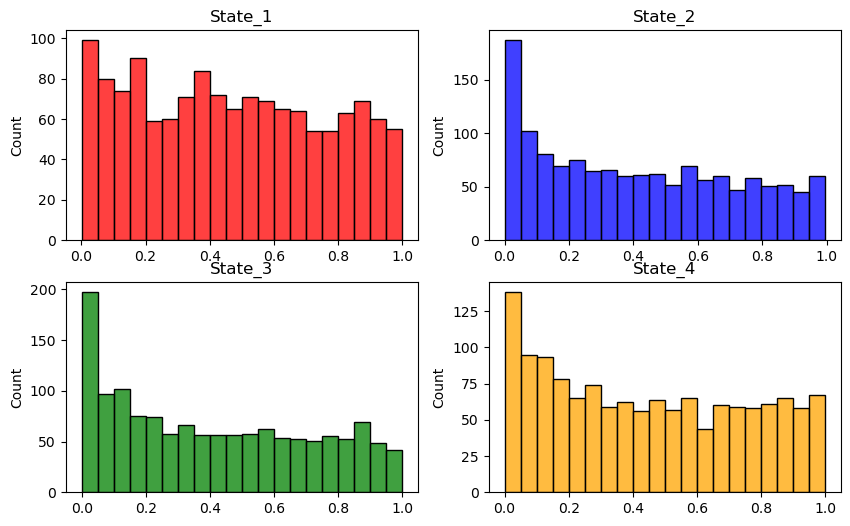

In [16]:
p = np.vstack([p1, p2, p3, p4])
print('Concatenated p-values shape : ', p.shape)    # n_states, 1378
labels = ['State_1', 'State_2', 'State_3', 'State_4']
utils.hist_plot(p, labels)
plt.close()

In [17]:
print('Number of connectivities with p values less than 0.05', (p1 < 0.05).sum())
print('Number of connectivities with p values less than 0.05', (p2 < 0.05).sum())
print('Number of connectivities with p values less than 0.05', (p3 < 0.05).sum())
print('Number of connectivities with p values less than 0.05', (p4 < 0.05).sum())

Number of connectivities with p values less than 0.05 96
Number of connectivities with p values less than 0.05 187
Number of connectivities with p values less than 0.05 197
Number of connectivities with p values less than 0.05 138


In [18]:
for i in range(p.shape[0]):
    utils.print_details(p[i])
    print('-------------------------------')

Shape :  (1378,)
Min Value : 0.0016542835960779384, Median Value : 0.4512937979005212 and  Max Value : 0.9999015082152856
Mean Value : 0.46633899537779655 and SD Value : 0.29070576742127413
-------------------------------
Shape :  (1378,)
Min Value : 4.822149292688106e-05, Median Value : 0.3761031937095675 and  Max Value : 0.9947206920080109
Mean Value : 0.4156910886008691 and SD Value : 0.30300006750729575
-------------------------------
Shape :  (1378,)
Min Value : 3.172545757329296e-08, Median Value : 0.3698158934199616 and  Max Value : 0.9994528916595522
Mean Value : 0.4092061802556361 and SD Value : 0.3064988439958814
-------------------------------
Shape :  (1378,)
Min Value : 1.6947280439114638e-05, Median Value : 0.4225960719802936 and  Max Value : 0.9996311987103148
Mean Value : 0.4465688300395223 and SD Value : 0.30648639967933083
-------------------------------


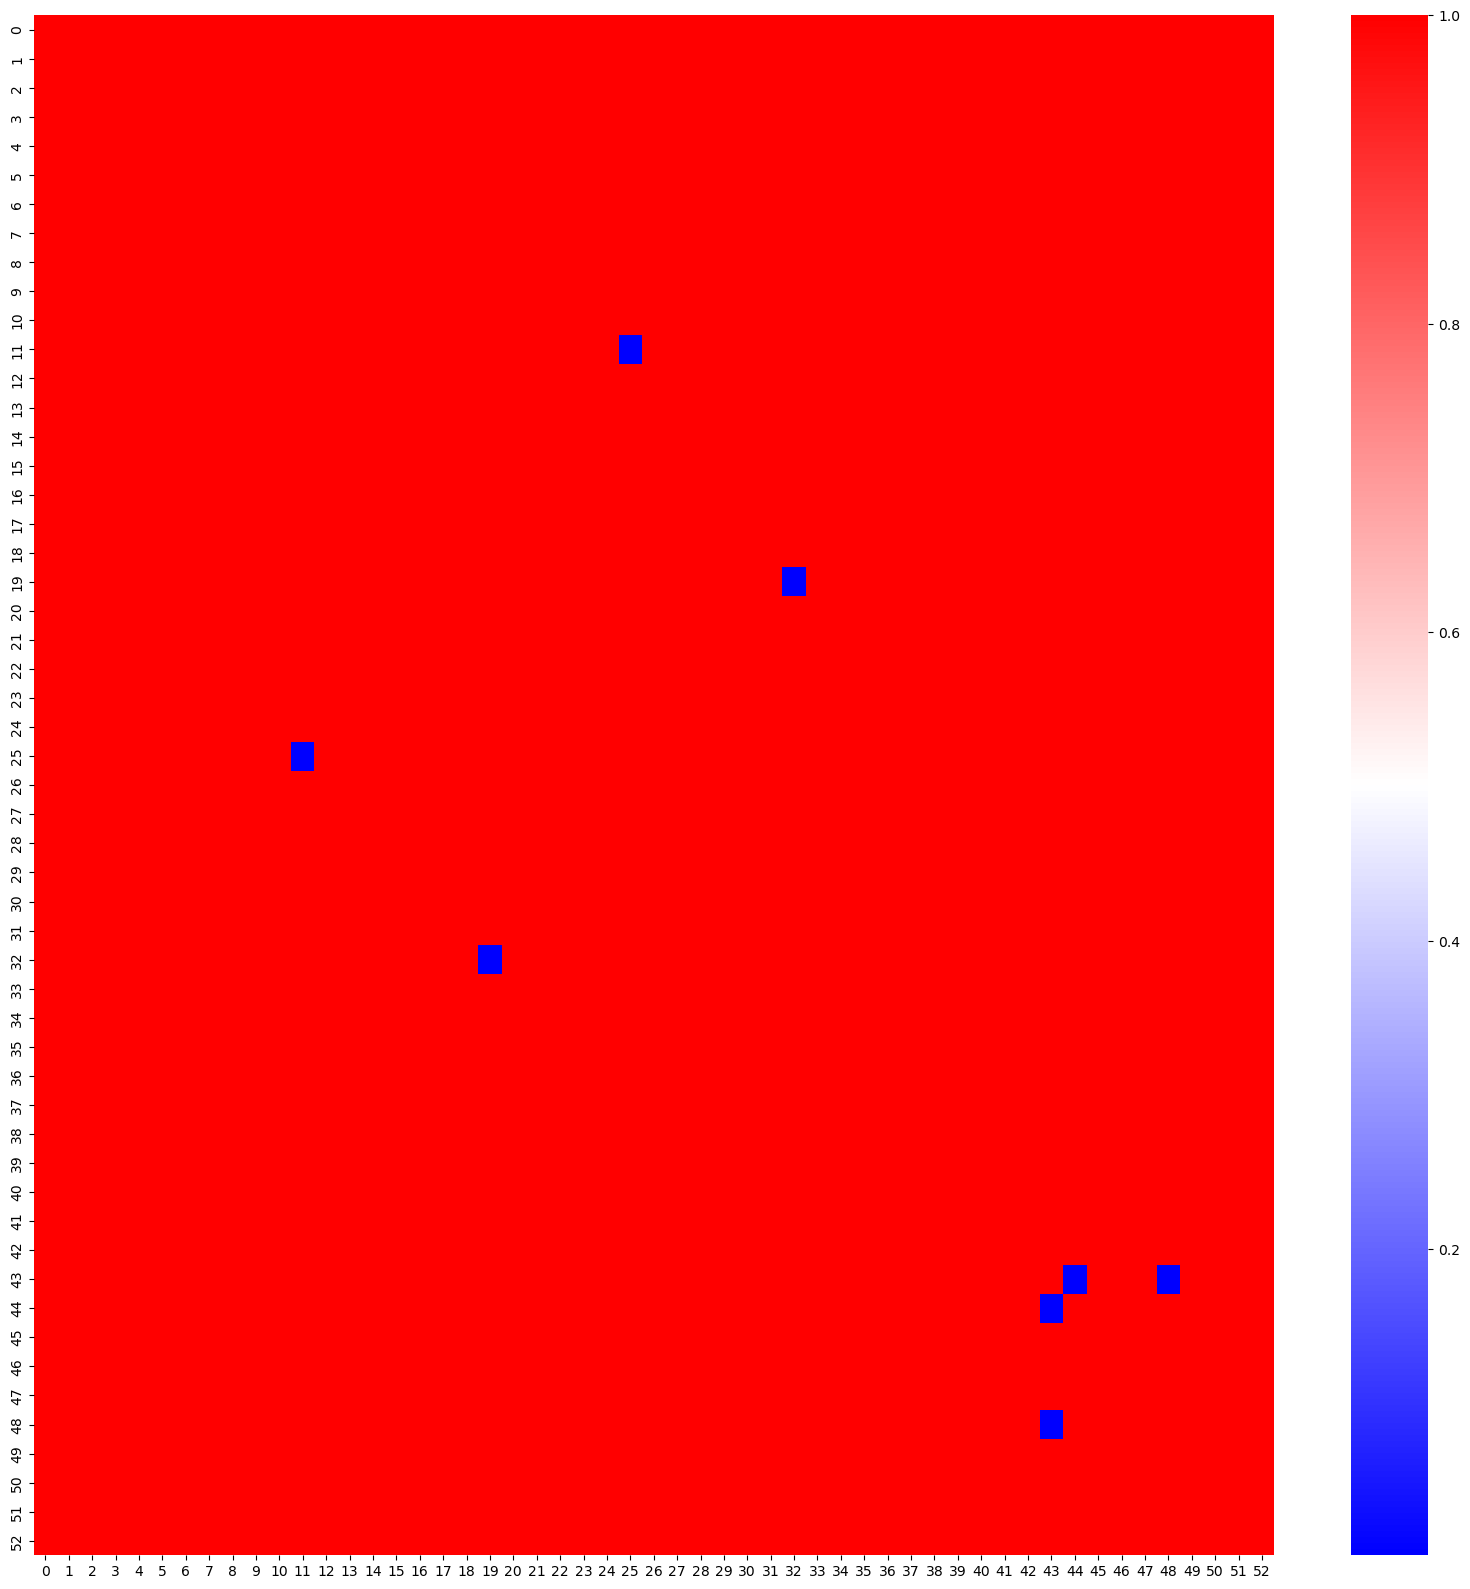

Python Indices of elements with significant connectivity : 


array([[12, 20, 26, 33, 44, 44, 45, 49],
       [26, 33, 12, 20, 45, 49, 44, 44]], dtype=uint32)

In [71]:
mat = utils.vec2mat(p1)
mat_threshold = utils.plot_matrix(mat, threshold = 0.002)
print('Python Indices of elements with significant connectivity : ', )
np.array(np.where(mat_threshold < 1), dtype = 'uint32') + 1

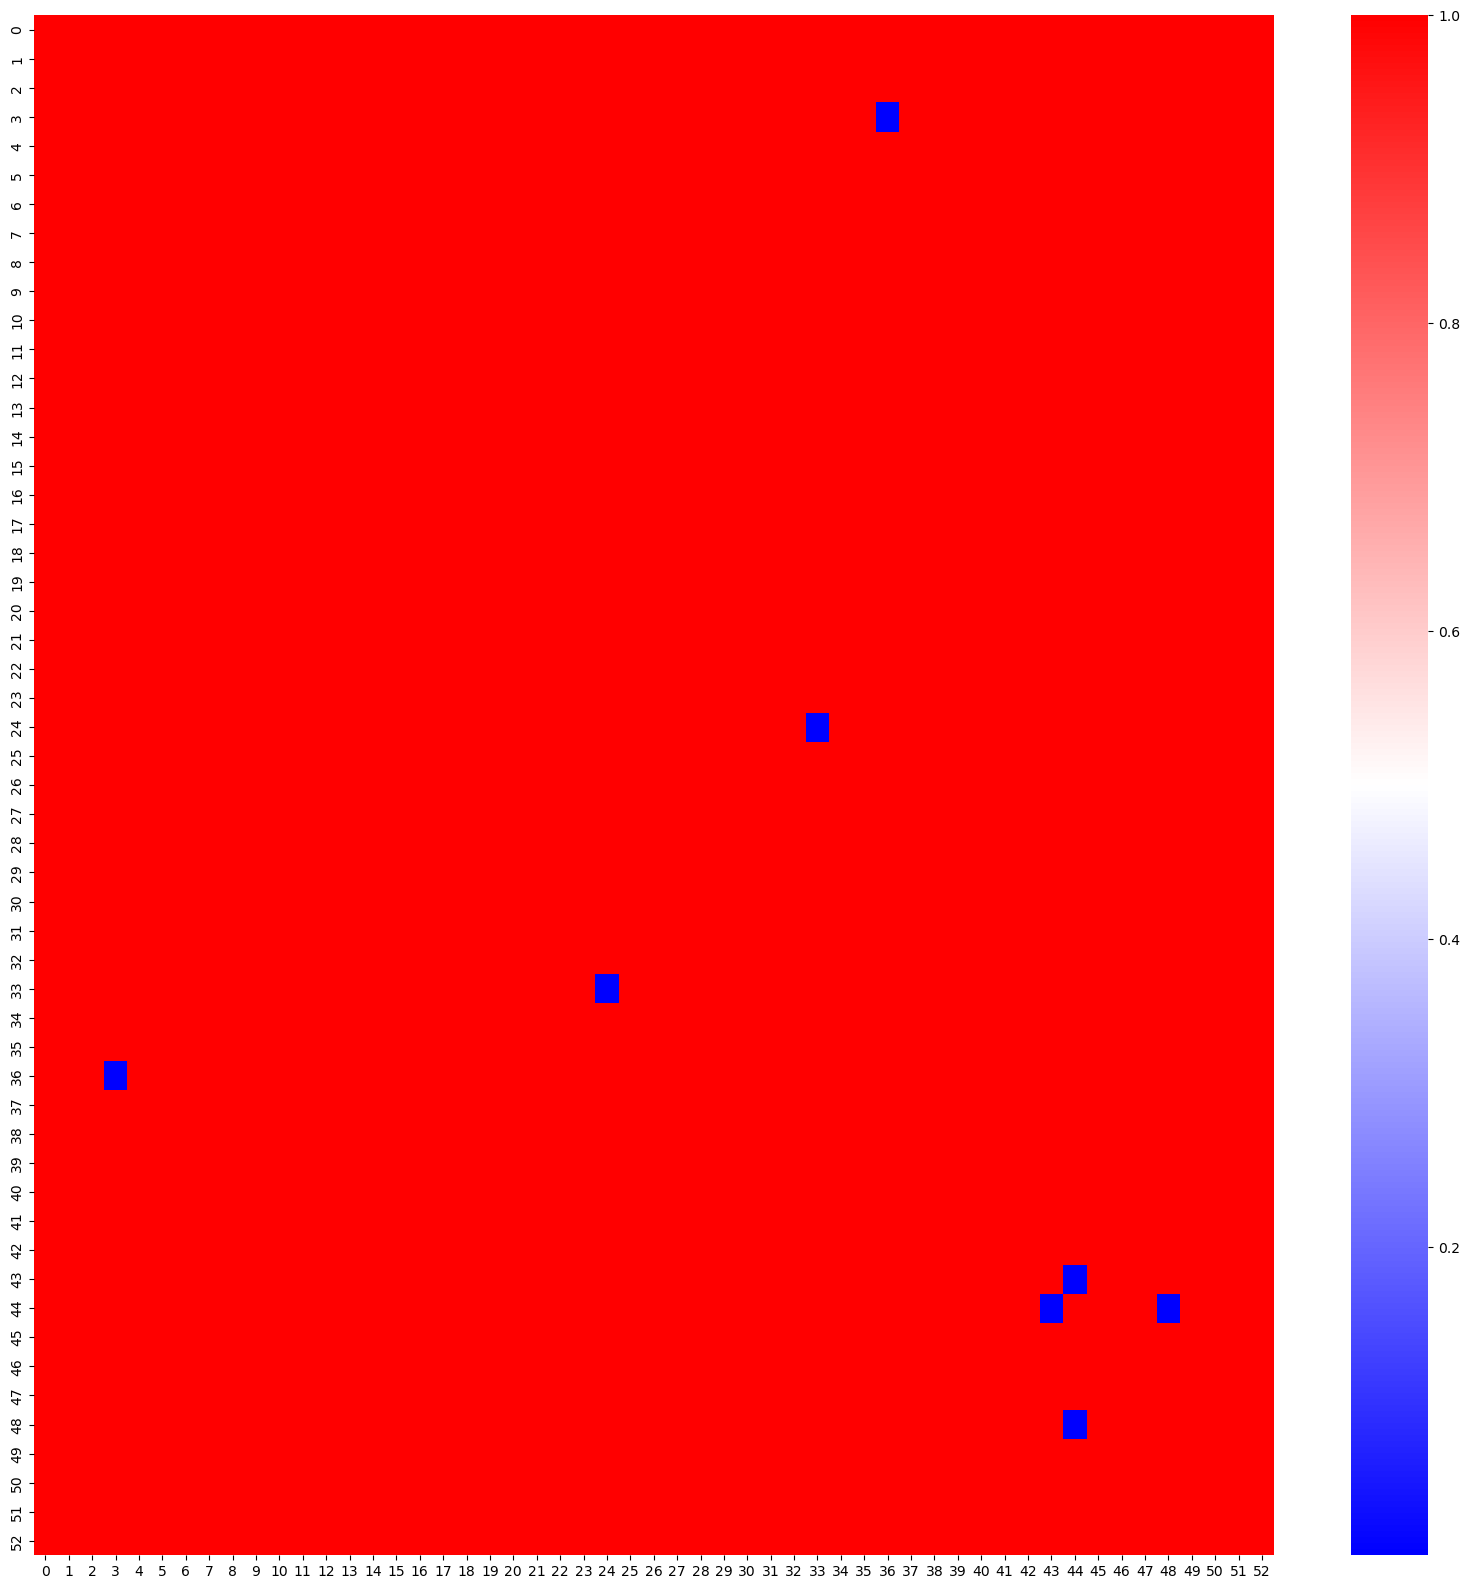

Python Indices of elements with significant connectivity : 


array([[ 4, 25, 34, 37, 44, 45, 45, 49],
       [37, 34, 25,  4, 45, 44, 49, 45]], dtype=uint32)

In [72]:
mat = utils.vec2mat(p2)
mat_threshold = utils.plot_matrix(mat, threshold = 0.0002)
print('Python Indices of elements with significant connectivity : ', )
np.array(np.where(mat_threshold < 1), dtype = 'uint32') + 1

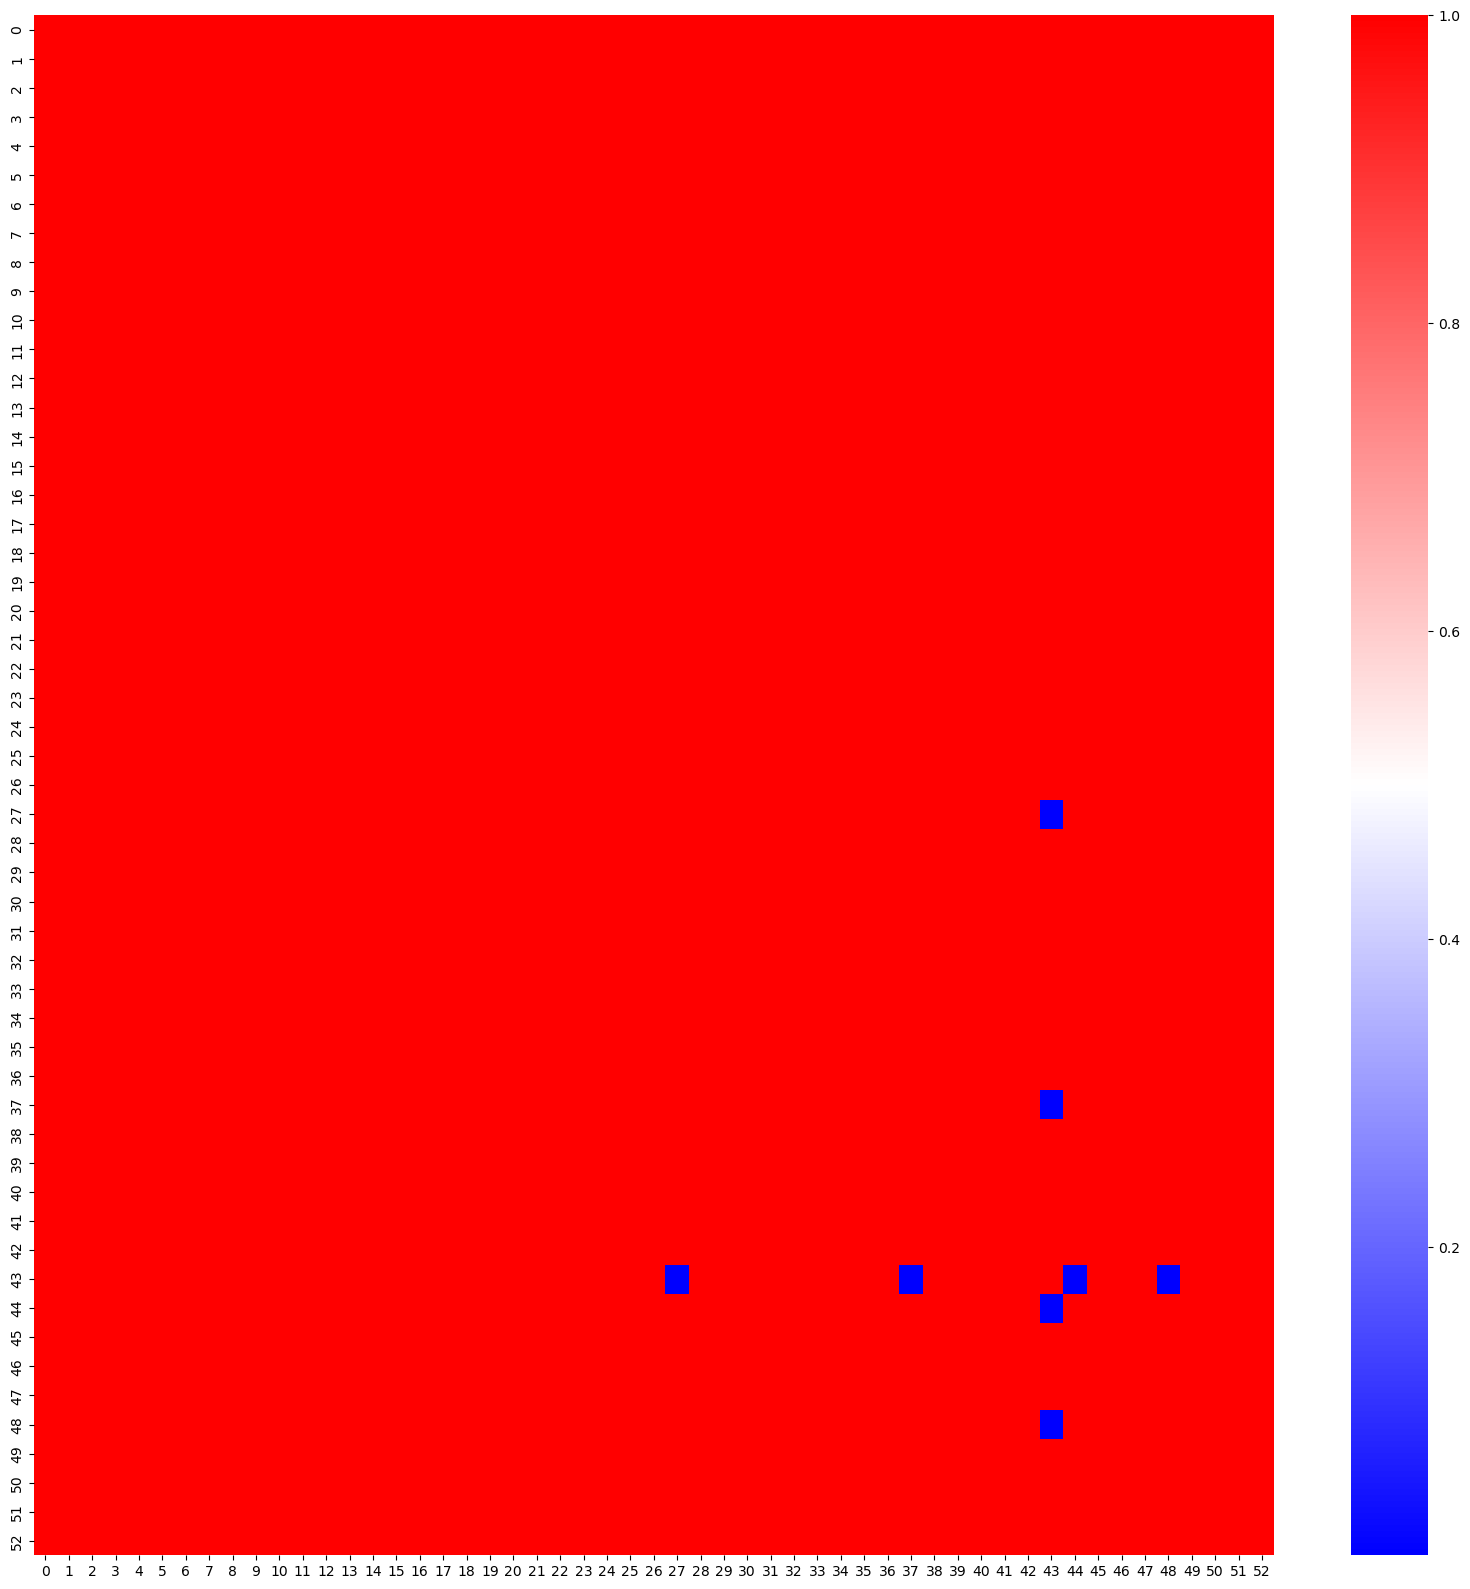

Python Indices of elements with significant connectivity : 


array([[28, 38, 44, 44, 44, 44, 45, 49],
       [44, 44, 28, 38, 45, 49, 44, 44]], dtype=uint32)

In [73]:
mat = utils.vec2mat(p3)
mat_threshold = utils.plot_matrix(mat, threshold = 0.00002)
print('Python Indices of elements with significant connectivity : ', )
np.array(np.where(mat_threshold < 1), dtype = 'uint32') + 1

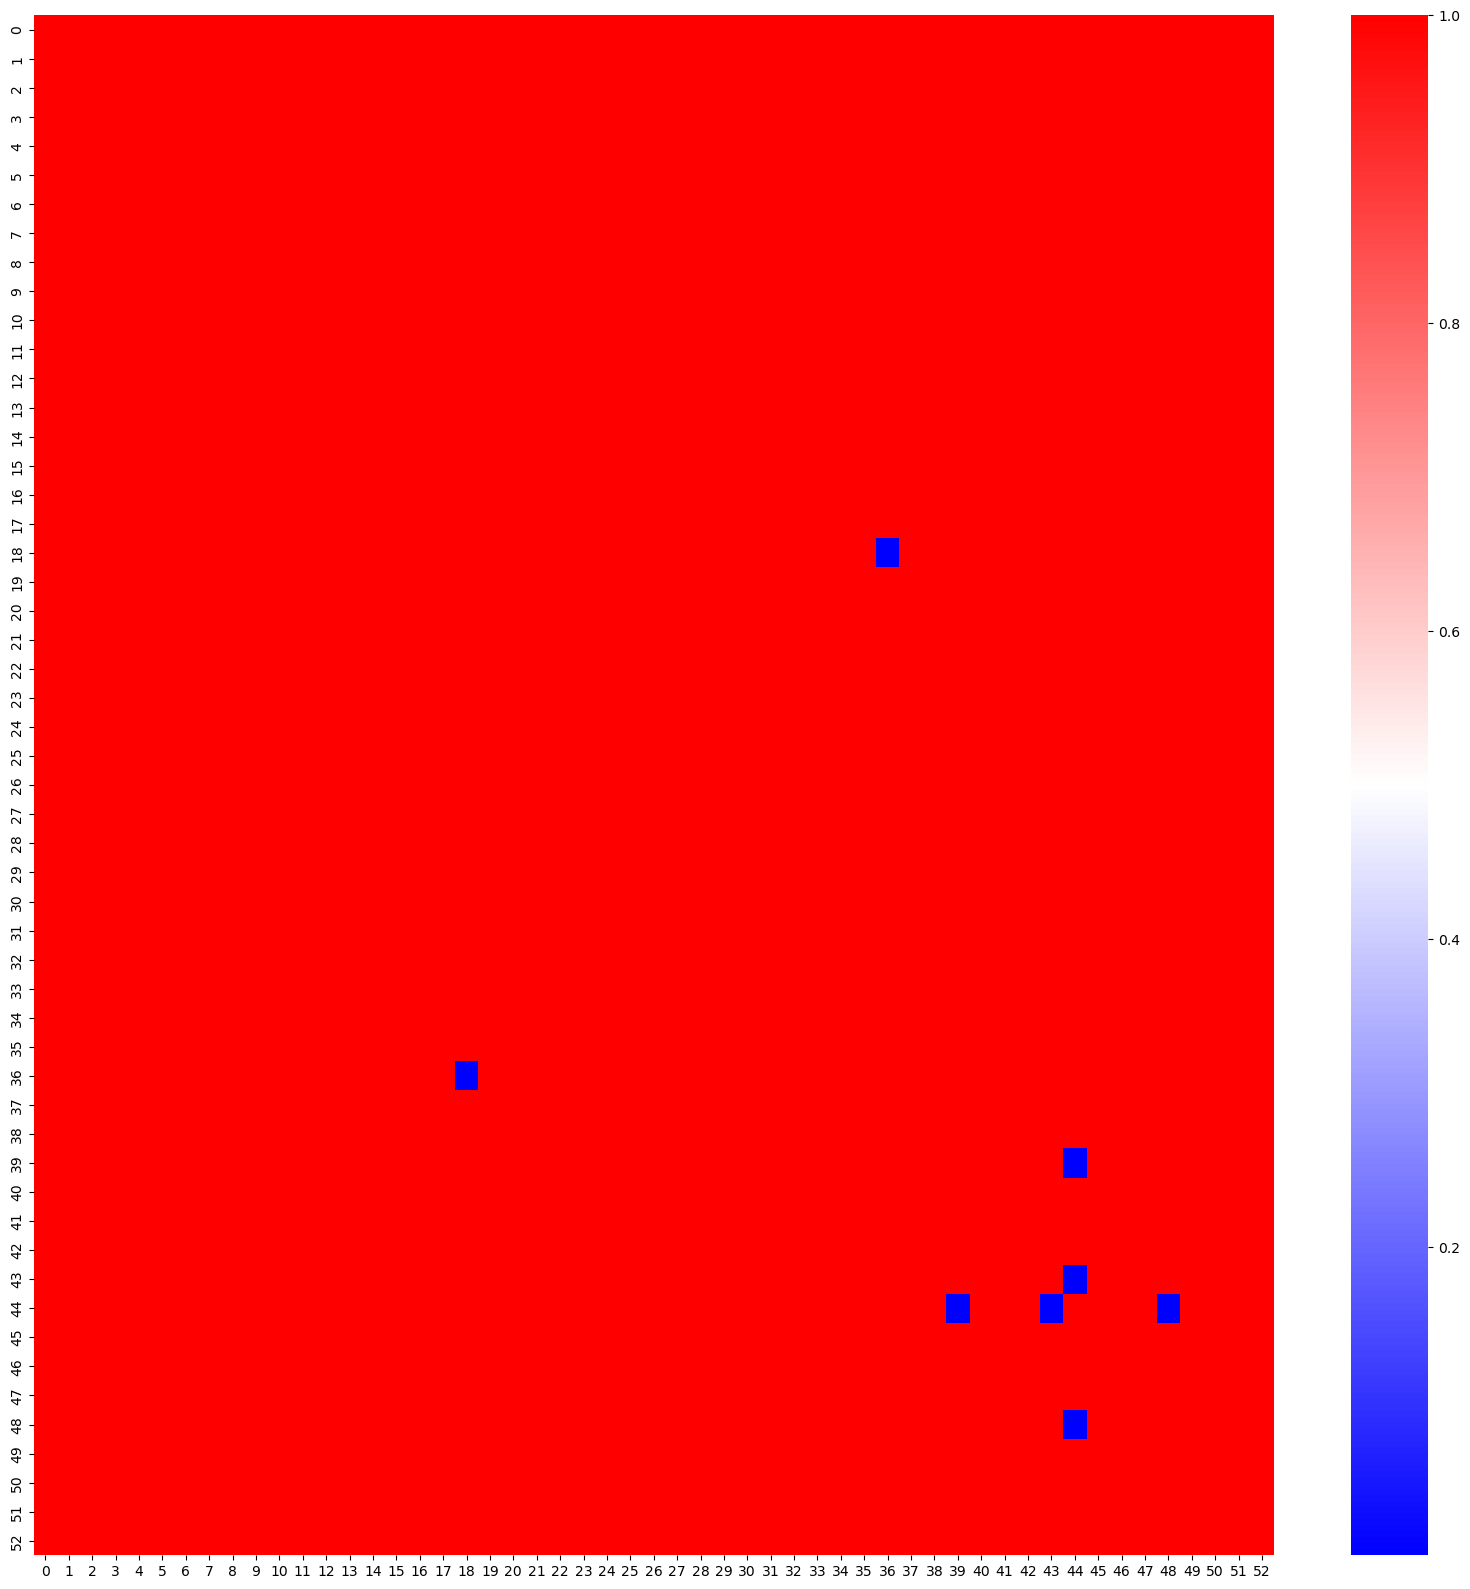

Matlab Indices of elements with significant connectivity : 


array([[19, 37, 40, 44, 45, 45, 45, 49],
       [37, 19, 45, 45, 40, 44, 49, 45]], dtype=uint32)

In [74]:
mat = utils.vec2mat(p4)
mat_threshold = utils.plot_matrix(mat, threshold = 0.00015)
print('Matlab Indices of elements with significant connectivity : ') # Index starts with 1
np.array(np.where(mat_threshold < 1), dtype = 'uint32') + 1       # we are interested in matlab indices. that's why we are adding one. 

**Checking the above p-values with GIFT generated p-values**

In [165]:
tt = scipy.io.loadmat(path + 'Stats_L1_ws20_city/All_age_ccs__dfnc_two_sample_ttest_results.mat')
print('Two sample ttest using GIFT mat file keys : ', tt.keys())

p_state1_gift = np.array(tt['p_u'][0][0][0], dtype = 'float64')
p_state2_gift = np.array(tt['p_u'][0][1][0], dtype = 'float64')
p_state3_gift = np.array(tt['p_u'][0][2][0], dtype = 'float64')
p_state4_gift = np.array(tt['p_u'][0][3][0], dtype = 'float64')

print('Shape of p_state1_gift : ', p_state1_gift.shape)
print('Shape of p_state2_gift : ', p_state2_gift.shape)
print('Shape of p_state3_gift : ', p_state3_gift.shape)
print('Shape of p_state4_gift : ', p_state4_gift.shape)

Two sample ttest using GIFT mat file keys :  dict_keys(['__header__', '__version__', '__globals__', 'groupNames', 'groupVals', 't_u', 'p_u', 'stats_u', 'N', 'mean_u', 'subject_indices'])
Shape of p_state1_gift :  (1378,)
Shape of p_state2_gift :  (1378,)
Shape of p_state3_gift :  (1378,)
Shape of p_state4_gift :  (1378,)


In [166]:
print(np.array_equal(np.round(p1, 8), np.round(p_state1_gift, 8)))
print(np.array_equal(np.round(p2, 8), np.round(p_state2_gift, 8)))
print(np.array_equal(np.round(p3, 8), np.round(p_state3_gift, 8)))
print(np.array_equal(np.round(p4, 8), np.round(p_state4_gift, 8)))

True
True
True
True


## POC PLot of ASD and TD

States array shape :  (155, 383)
States values :  [1 2 3 4]
['ASD', 'TD']
p-values of 4 states :  {0: 0.25464626081435643, 1: 0.35795803817080896, 2: 0.23156686985363978, 3: 4.783777066956203e-05}
Number of groups :  2
Group names : ['ASD', 'TD']
Shape of Mean value of occurences array shape :  (2, 4)
Shape of STD value of occurences array shape :  (2, 4)


/home/krishna/Downloads/MS_Thesis/Thesis/utils.py:559: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(new_ytick_labels)


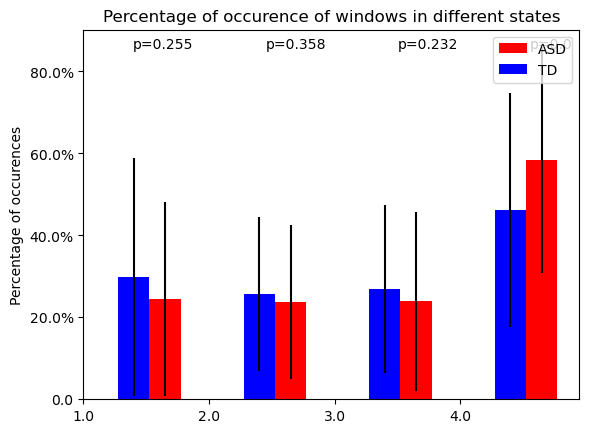

Successfully plotted !!!!


In [25]:
file_path = path + 'All_age_ccs__dfnc_post_process_K4_L1_ws20_city.mat'
save_path = None # './Final/Outputs_cpac_NFNG/POC_cpac_NFNG_K4.jpg'

groups = {'ASD' : asd_idx, 'TD' : td_idx}
n_states = 4
n_windows_per_sub = 155

poc_dict, p_dict = utils.get_poc(file_path, groups, n_states, n_windows_per_sub)
print('p-values of 4 states : ', p_dict)
utils.plot_poc(poc_dict, p_dict, save_path)

States array shape :  (155, 383)
States values :  [1 2 3 4]
['ASD', 'TD']
p-values of 4 states :  {0: 0.03990666053535636, 1: 0.08464692587427255, 2: 0.018784396961776452, 3: 1.5096095821139186e-05}
Number of groups :  2
Group names : ['ASD', 'TD']
Shape of Mean value of occurences array shape :  (2, 4)
Shape of STD value of occurences array shape :  (2, 4)


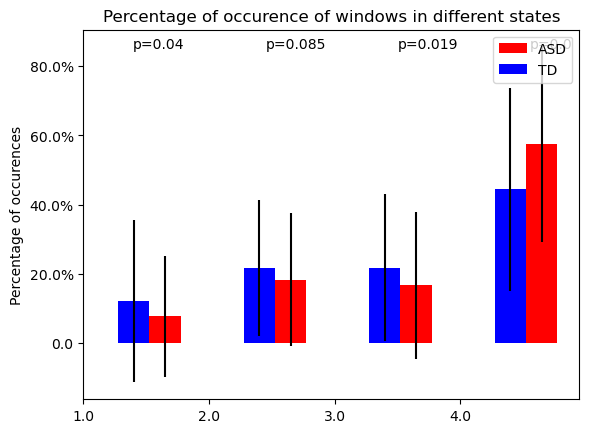

Successfully plotted !!!!


In [26]:
file_path = path + 'All_age_ccs__dfnc_post_process_K4_L1_ws20_city.mat'
save_path = None # './Final/Outputs_cpac_NFNG/POC_cpac_NFNG_K4.jpg'

groups = {'ASD' : asd_idx, 'TD' : td_idx}
n_states = 4
n_windows_per_sub = 155

poc_dict, p_dict = utils.get_poc(file_path, groups, n_states, n_windows_per_sub, consider_none = True)
print('p-values of 4 states : ', p_dict)
utils.plot_poc(poc_dict, p_dict, save_path)

## Analysis of State vector stats

In [6]:
cs = scipy.io.loadmat(path + 'Stats_L1_ws20_city/All_age_ccs__dfnc_cluster_stats.mat')
print('Cluster stats using GIFT mat file keys : ', cs.keys())

Cluster stats using GIFT mat file keys :  dict_keys(['__header__', '__version__', '__globals__', 'thresholdWindows', 'dfnc_corrs', 'state_vector_stats', 'nuisance_cov_file'])


In [7]:
frac_time_states = cs['state_vector_stats'][0][0][0]
print("Shape of fraction time states : ", frac_time_states.shape)

Shape of fraction time states :  (383, 4)


In [8]:
utils.print_details(frac_time_states)

Shape :  (383, 4)
Min Value : 0.0, Median Value : 0.14838709677419354 and  Max Value : 1.0
Mean Value : 0.25 and SD Value : 0.27857782919779234


['ASD', 'TD']
Groups :  ['ASD', 'TD']
[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9]
[0.35639998 0.41396016 0.43009698 0.8570032 ]


/home/krishna/Downloads/MS_Thesis/Thesis/utils.py:249: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(new_ytick_labels)


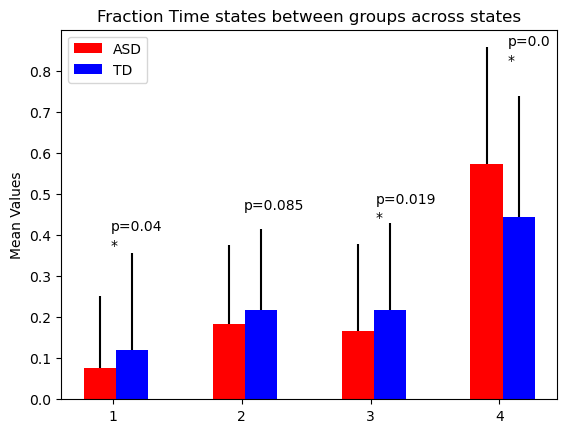

In [21]:
n_states = 4
pvalues_dict = utils.get_pvalues(frac_time_states, groups, n_states)   # P-values dictionary
mean_groups, std_groups = utils.get_mean_std(frac_time_states, groups, n_states)
utils.plot_groups(mean_groups, std_groups, pvalues_dict, title = 'Fraction Time states')

In [10]:
frac_time_states_ravel =  frac_time_states.ravel()
states_ravel = np.array(['State1', 'State2', 'State3', 'State4'] * 383)
groups_ravel = np.array(['ASD'] * 752 + ['TD'] * 780)
df_plot = pd.DataFrame({'Fractional' : frac_time_states_ravel, 'State' : states_ravel, 'Groups' : groups_ravel})
print('Shape of dataframe of fractional timestate : ', df_plot.shape)
df_plot.head()

Shape of dataframe of fractional timestate :  (1532, 3)


Fractional   State Groups
0     0.00000  State1    ASD
1     0.23871  State2    ASD
2     0.00000  State3    ASD
3     0.76129  State4    ASD
4     0.16129  State1    ASD

In [14]:
len(df_plot[(df_plot['State'] == 'State1') & (df_plot['Groups'] == 'ASD')])

188

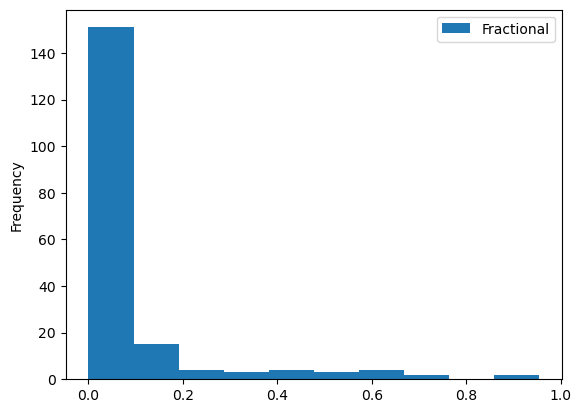

In [15]:
df_plot[(df_plot['State'] == 'State1') & (df_plot['Groups'] == 'ASD')].plot(kind = 'hist')
plt.show()

In [17]:
df_plot[(df_plot['State'] == 'State1') & (df_plot['Groups'] == 'ASD')][['Fractional']].mean()

Fractional    0.076905
dtype: float64

In [18]:
df_plot[(df_plot['State'] == 'State1') & (df_plot['Groups'] == 'TD')][['Fractional']].mean()

Fractional    0.12086
dtype: float64

In [22]:
mean_groups

{'ASD': [0.07690459849004803,
  0.18301304049416608,
  0.16640356897735073,
  0.5736787920384353],
 'TD': [0.12086021505376346,
  0.21753515301902399,
  0.2177998345740281,
  0.44380479735318457]}

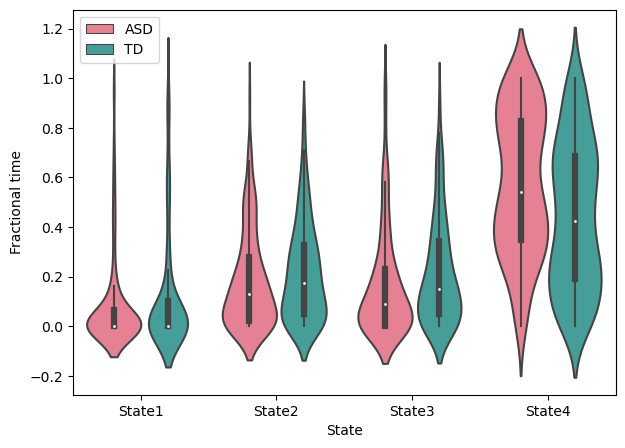

In [109]:
plt.figure(figsize = (7,5))
ax = sns.violinplot(data=df_plot, x="State", y="Fractional", hue="Groups", split=False, palette = 'husl')
ax.set_ylabel('Fractional time')
plt.legend(loc = 'upper left')
plt.show()
plt.close()

In [31]:
pvalues_dict

{0: 0.03990670709967639,
 1: 0.08464691980852608,
 2: 0.018784375456112973,
 3: 1.5096019170681216e-05}

In [110]:
mean_dwell_time = cs['state_vector_stats'][0][0][1]
print("Shape of fraction time states : ", mean_dwell_time.shape)

Shape of fraction time states :  (383, 4)


In [111]:
utils.print_details(mean_dwell_time)

Shape :  (383, 4)
Min Value : 0.0, Median Value : 11.0 and  Max Value : 155.0
Mean Value : 16.48475460027353 and SD Value : 24.76157887552236


['ASD', 'TD']
Groups :  ['ASD', 'TD']
[ 0. 10. 20. 30. 40. 50. 60. 70. 80. 90.]
[0.311439   0.2405275  0.28795505 0.81485045]


/home/krishna/Downloads/MS_Thesis/Thesis/utils.py:233: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(new_ytick_labels)


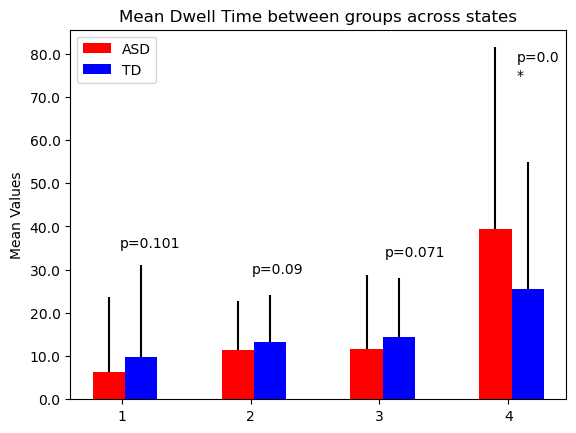

In [181]:
n_states = 4
pvalues_dict = utils.get_pvalues(mean_dwell_time, groups, n_states)   # P-values dictionary
mean_groups, std_groups = utils.get_mean_std(mean_dwell_time, groups, n_states)
utils.plot_groups(mean_groups, std_groups, pvalues_dict, title = 'Mean Dwell Time')

In [182]:
mean_groups 

{'ASD': [6.398492907801417,
  11.463563829787235,
  11.607446808510637,
  39.39024822695035],
 'TD': [9.683076923076921,
  13.372136752136752,
  14.47051282051282,
  25.597405372405373]}

In [183]:
std_groups

{'ASD': [17.168936341332834,
  11.221124782174533,
  17.188056394092634,
  42.09480451828317],
 'TD': [21.460824142346603,
  10.680612210948963,
  13.548045801375208,
  29.425902992019378]}

In [35]:
pvalues_dict

{0: 0.10060004941851128,
 1: 0.08977403014163536,
 2: 0.07121408718384936,
 3: 0.0002312384905394985}

In [114]:
mean_dwell_time_ravel =  mean_dwell_time.ravel()
states_ravel = np.array(['State1', 'State2', 'State3', 'State4'] * 383)
groups_ravel = np.array(['ASD'] * 752 + ['TD'] * 780)
df_mdt = pd.DataFrame({'Mean-Dwell-Time' : mean_dwell_time_ravel, 'State' : states_ravel, 'Groups' : groups_ravel})
print('Shape of dataframe of fractional timestate : ', df_mdt.shape)
df_mdt.head()

Shape of dataframe of fractional timestate :  (1532, 3)


Mean-Dwell-Time   State Groups
0         0.000000  State1    ASD
1        12.333333  State2    ASD
2         0.000000  State3    ASD
3        39.333333  State4    ASD
4        12.500000  State1    ASD

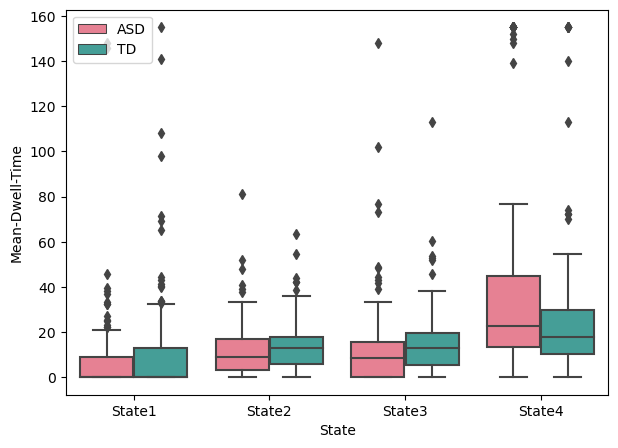

In [117]:
plt.figure(figsize = (7,5))
ax = sns.boxplot(data=df_mdt, x="State", y="Mean-Dwell-Time", hue="Groups", palette = 'husl')
ax.set_ylabel('Mean-Dwell-Time')
plt.legend(loc = 'upper left')
plt.show()
plt.close()

Shape of fraction time states :  (383, 4, 4)


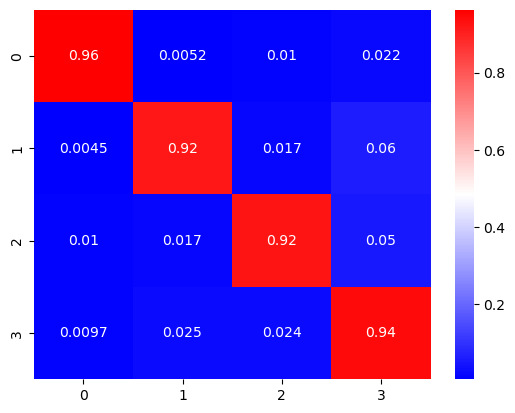

In [36]:
transition_matrix = cs['state_vector_stats'][0][0][2]
print("Shape of fraction time states : ", transition_matrix.shape)
transition_matrix_mean = np.mean(transition_matrix, axis = 0)
sns.heatmap(transition_matrix_mean, annot=True, cmap = 'bwr')
plt.show()
plt.close()

Mean of ASD Transition matrix shape :  (4, 4)
Mean of TD Transition matrix shape :  (4, 4)


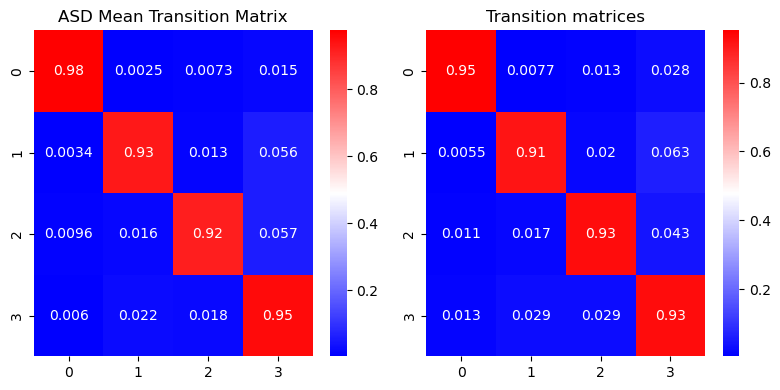

In [26]:
asd_tm = transition_matrix[asd_idx]     # ASD python indices
td_tm = transition_matrix[td_idx]       # TD python indices
asd_tm_mean = np.mean(asd_tm, axis = 0)
td_tm_mean = np.mean(td_tm, axis = 0)
print('Mean of ASD Transition matrix shape : ', asd_tm_mean.shape)
print('Mean of TD Transition matrix shape : ', td_tm_mean.shape)

fig, (ax1, ax2) = plt.subplots(1,2,  figsize=(8,4))

ax1 = sns.heatmap(asd_tm_mean, annot=True, cmap = 'bwr', ax = ax1)
ax1.set_title('ASD Mean Transition Matrix')
ax2 = sns.heatmap(td_tm_mean, annot=True, cmap = 'bwr', ax = ax2)
ax2.set_title('TD Mean Transition Matrix')
plt.title('Transition matrices')
plt.tight_layout()
plt.show()
plt.close()

In [20]:
reference_array = np.array([i for i in range(16)], dtype = 'int')
reference_matrix = reference_array.reshape(4,4)
reference_matrix

array([[ 0,  1,  2,  3],
       [ 4,  5,  6,  7],
       [ 8,  9, 10, 11],
       [12, 13, 14, 15]])

In [21]:
reference_matrix.reshape(-1)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15])

In [17]:
transition_matrix = cs['state_vector_stats'][0][0][2]
print("Shape of fraction time states : ", transition_matrix.shape)

Shape of fraction time states :  (383, 4, 4)


In [19]:
transition_array = transition_matrix.reshape(-1, 16)
transition_array.shape

(383, 16)

In [22]:
asd_transition = transition_array[asd_idx, :]
td_transition = transition_array[td_idx, :]
t_transition, p_transition = [], []
for i in range(16):
    t, p = scipy.stats.ttest_ind(asd_transition[:,i], td_transition[:, i])
    t_transition.append(t)
    p_transition.append(p)
t_transition = np.array(t_transition, dtype = 'float32')
p_transition = np.array(p_transition, dtype = 'float32')
p_transition

array([0.02522302, 0.10504302, 0.3742567 , 0.11281624, 0.2853302 ,
       0.19972703, 0.25669497, 0.5594267 , 0.6910322 , 0.9356584 ,
       0.36068386, 0.17237142, 0.04028009, 0.04915792, 0.1080868 ,
       0.00141795], dtype=float32)

In [30]:
asd_mean_ta = np.mean(asd_transition, axis = 0)
td_mean_ta = np.mean(td_transition, axis = 0)
asd_mean_ta.shape

(16,)

In [33]:
asd_std_ta = np.std(asd_transition, axis = 0)
td_std_ta = np.std(td_transition, axis = 0)
asd_std_ta.shape

(16,)

In [32]:
significant_transition = np.where(p_transition < 0.05)
print('Indices with significant difference : ', significant_transition)
print('Mean values of ASD Transition array {Significant indices only} : ', asd_mean_ta[significant_transition])
print('Mean values of TD Transition array {Significant indices only} : ', td_mean_ta[significant_transition])

Indices with significant difference :  (array([ 0, 12, 13, 15]),)
Mean values of ASD Transition array {Significant indices only} :  [0.97565853 0.00600954 0.02157203 0.95408569]
Mean values of TD Transition array {Significant indices only} :  [0.95140128 0.01316764 0.02892105 0.9285171 ]


In [24]:
reference_matrix

array([[ 0,  1,  2,  3],
       [ 4,  5,  6,  7],
       [ 8,  9, 10, 11],
       [12, 13, 14, 15]])

In [174]:
num_transitions = cs['state_vector_stats'][0][0][3]
print("Shape of fraction time states : ", num_transitions.shape)
asd_nt = num_transitions[asd_idx, :]
td_nt = num_transitions[td_idx, :]
_, pvalue_nt = scipy.stats.ttest_ind(asd_nt, td_nt)
print('P-value of Number of transitions : ', pvalue_nt)

Shape of fraction time states :  (383, 1)
P-value of Number of transitions :  [0.07117362]


In [175]:
print('Meanand std of ASD transitions: ', np.mean(asd_nt), np.std(asd_nt))
print('Meanand std of TD transitions: ', np.mean(td_nt), np.std(td_nt))

Meanand std of ASD transitions:  6.2712765957446805 3.683751624346811
Meanand std of TD transitions:  6.907692307692308 3.1706494210933025


# Connectivity Strengths

In [149]:
cs = scipy.io.loadmat(path + 'Stats_L1_ws20_city/All_age_ccs__dfnc_cluster_stats.mat')
print('Cluster stats using GIFT mat file keys : ', cs.keys())
dfnc_corrs = cs['dfnc_corrs']
dfnc_corrs = np.squeeze(dfnc_corrs)
dfnc_corrs.shape           # (n_subjects, states_vector_length, n_states)

Cluster stats using GIFT mat file keys :  dict_keys(['__header__', '__version__', '__globals__', 'thresholdWindows', 'dfnc_corrs', 'state_vector_stats', 'nuisance_cov_file'])


(383, 1378, 4)

In [150]:
print('Number of null values in dfnc_corr matrix : ', np.isnan(dfnc_corrs).sum())
print('Connectivities with median equal to zero per state :', np.where(dfnc_corrs == 0))

Number of null values in dfnc_corr matrix :  582894
Connectivities with median equal to zero per state : (array([], dtype=int64), array([], dtype=int64), array([], dtype=int64))


In [151]:
dfnc_dict = utils.get_groups_dfnc(dfnc_corrs, groups, n_states = 4, mode = 'all')
print('Keys in dfnc_dict : ', list(dfnc_dict.keys()))        # Keys = States
print('Keys in dfnc_dict[0] : ', list(dfnc_dict[0].keys()))  
print('Shape of dfnc_dict[0]["ASD"] : ',dfnc_dict[0]["ASD"].shape)
print('Shape of dfnc_dict[0]["TD"] : ',dfnc_dict[0]["TD"].shape)

State :  1
Group : ASD and DFNC shape : (59, 1378)
Group : TD and DFNC shape : (79, 1378)
------------------------------------------------
State :  2
Group : ASD and DFNC shape : (145, 1378)
Group : TD and DFNC shape : (165, 1378)
------------------------------------------------
State :  3
Group : ASD and DFNC shape : (131, 1378)
Group : TD and DFNC shape : (158, 1378)
------------------------------------------------
State :  4
Group : ASD and DFNC shape : (185, 1378)
Group : TD and DFNC shape : (187, 1378)
------------------------------------------------
Keys in dfnc_dict :  [0, 1, 2, 3]
Keys in dfnc_dict[0] :  ['ASD', 'TD']
Shape of dfnc_dict[0]["ASD"] :  (59, 1378)
Shape of dfnc_dict[0]["TD"] :  (79, 1378)


In [152]:
t1, p1 = utils.two_sample_ttest(dfnc_dict, state = 0)
t2, p2 = utils.two_sample_ttest(dfnc_dict, state = 1)
t3, p3 = utils.two_sample_ttest(dfnc_dict, state = 2)
t4, p4 = utils.two_sample_ttest(dfnc_dict, state = 3)
print('T-Values shape : ', t1.shape)
print('P-Values shape : ', p1.shape)

T-Values shape :  (1378,)
P-Values shape :  (1378,)


In [153]:
reference = np.array([i for i in range(1378)], dtype = 'int')
reference_mat = np.array(utils.vec2mat(reference), dtype='int')
np.fill_diagonal(reference_mat, -1)
reference_mat

array([[  -1,    0,    1, ...,   49,   50,   51],
       [   0,   -1,   52, ...,  100,  101,  102],
       [   1,   52,   -1, ...,  150,  151,  152],
       ...,
       [  49,  100,  150, ...,   -1, 1375, 1376],
       [  50,  101,  151, ..., 1375,   -1, 1377],
       [  51,  102,  152, ..., 1376, 1377,   -1]])

In [154]:
nm_labels = pd.read_excel('./Phenotypes/NM_Template_Labels.xlsx', index_col = 'Indices')
nm_labels.head()

ROI Network
Indices                                      
1                         Caudate (1)      SC
2        Subthalamus/hypothalamus (2)      SC
3                         Putamen (3)      SC
4                         Caudate (4)      SC
5                        Thalamus (5)      SC

In [161]:
p1_inds = np.argsort(p1)
conn_indices, p_values, asd_means, td_means, asd_stds, td_stds, dominant_group =  [], [],  [], [], [], [], []
first_roi_indices, second_roi_indices, first_roi_names, second_roi_names = [], [], [], []
for idx in p1_inds : 

    twod_indices = np.array(np.where(reference_mat == idx), dtype = 'uint32') + 1 
    first_idx = twod_indices[0,0]
    second_idx = twod_indices[0,1]
    first_roi = str(nm_labels.loc[first_idx]['ROI'])
    second_roi = str(nm_labels.loc[second_idx]['ROI'])
    p_val = p1[idx]

    asd_mean = np.mean(dfnc_dict[0]['ASD'][:, idx])
    td_mean = np.mean(dfnc_dict[0]['TD'][:, idx])
    asd_std = np.std(dfnc_dict[0]['ASD'][:, idx])
    td_std = np.std(dfnc_dict[0]['TD'][:, idx])
    dominant = 'ASD' if asd_mean > td_mean else 'TD'

    first_roi_indices.append(first_idx)
    second_roi_indices.append(second_idx)
    first_roi_names.append(first_roi)
    second_roi_names.append(second_roi)

    conn_indices.append(idx)
    p_values.append(p_val)
    asd_means.append(asd_mean)
    td_means.append(td_mean)
    asd_stds.append(asd_std)
    td_stds.append(td_std)
    dominant_group.append(dominant)

    
df_p1 = pd.DataFrame({'Connectivity_Index' : conn_indices, 'First_ROI_Index' : first_roi_indices,
                        'First_ROI_Name' : first_roi_names, 'Second_ROI_Index' : second_roi_indices, 
                        'Second_ROI_Name' : second_roi_names, 'P_Values' : p_values, 
                        'ASD_Mean' : asd_means, 'TD_Mean' : td_means, 'ASD_STD' : asd_stds, 
                        'TD_STD' : td_stds, 'Dominant_Group' : dominant_group})

                        
df_p1.to_csv('./Phenotypes/States/State1_P_Values.csv')    
df_p1.head()                    

Connectivity_Index  First_ROI_Index                        First_ROI_Name  \
0                1333               44                        Precuneus (44)   
1                1337               44                        Precuneus (44)   
2                 829               20                           Cuneus (20)   
3                 530               12  Superior parietal lobule ([SPL], 12)   
4                 951               24        Lingual gyrus ([LingualG], 24)   

   Second_ROI_Index                             Second_ROI_Name  P_Values  \
0                45       Anterior cingulate cortex ([ACC], 45)  0.001654   
1                49      Posterior cingulate cortex ([PCC], 49)  0.001739   
2                33  Left inferior parietal lobue ([R IPL], 33)  0.001849   
3                26        Inferior parietal lobule ([IPL], 26)  0.001952   
4                33  Left inferior parietal lobue ([R IPL], 33)  0.002261   

   ASD_Mean   TD_Mean   ASD_STD    TD_STD Dominant_Group  
0  0.087639  0.227200  0.238666  0.259502             TD  
1  0.283971  0.439757  0.312559  0.255523             TD  
2  0.207096  0.077664  0.225743  0.241910            ASD  
3 -0.027876 -0.172706  0.267758  0.262088            ASD  
4  0.164138  0.045473  0.219994  0.219914            ASD

In [162]:
p2_inds = np.argsort(p2)
conn_indices, p_values, asd_means, td_means, asd_stds, td_stds, dominant_group =  [], [],  [], [], [], [], []
first_roi_indices, second_roi_indices, first_roi_names, second_roi_names = [], [], [], []
for idx in p2_inds : 

    twod_indices = np.array(np.where(reference_mat == idx), dtype = 'uint32') + 1 
    first_idx = twod_indices[0,0]
    second_idx = twod_indices[0,1]
    first_roi = str(nm_labels.loc[first_idx]['ROI'])
    second_roi = str(nm_labels.loc[second_idx]['ROI'])
    p_val = p2[idx]

    asd_mean = np.mean(dfnc_dict[1]['ASD'][:, idx])
    td_mean = np.mean(dfnc_dict[1]['TD'][:, idx])
    asd_std = np.std(dfnc_dict[1]['ASD'][:, idx])
    td_std = np.std(dfnc_dict[1]['TD'][:, idx])
    dominant = 'ASD' if asd_mean > td_mean else 'TD'

    first_roi_indices.append(first_idx)
    second_roi_indices.append(second_idx)
    first_roi_names.append(first_roi)
    second_roi_names.append(second_roi)

    conn_indices.append(idx)
    p_values.append(p_val)
    asd_means.append(asd_mean)
    td_means.append(td_mean)
    asd_stds.append(asd_std)
    td_stds.append(td_std)
    dominant_group.append(dominant)

    
df_p2 = pd.DataFrame({'Connectivity_Index' : conn_indices, 'First_ROI_Index' : first_roi_indices,
                        'First_ROI_Name' : first_roi_names, 'Second_ROI_Index' : second_roi_indices, 
                        'Second_ROI_Name' : second_roi_names, 'P_Values' : p_values, 
                        'ASD_Mean' : asd_means, 'TD_Mean' : td_means, 'ASD_STD' : asd_stds, 
                        'TD_STD' : td_stds, 'Dominant_Group' : dominant_group})

                        
df_p2.to_csv('./Phenotypes/States/State2_P_Values.csv')    
df_p2.head()                    

Connectivity_Index  First_ROI_Index                         First_ROI_Name  \
0                1333               44                         Precuneus (44)   
1                1345               45  Anterior cingulate cortex ([ACC], 45)   
2                 185                4                            Caudate (4)   
3                 980               25      Middle temporal gyrus ([MTG], 25)   
4                 646               15   Superior parietal lobule ([SPL], 15)   

   Second_ROI_Index                         Second_ROI_Name  P_Values  \
0                45   Anterior cingulate cortex ([ACC], 45)  0.000048   
1                49  Posterior cingulate cortex ([PCC], 49)  0.000071   
2                37                Hippocampus ([HiPP], 37)  0.000113   
3                34    Supplementary motor area ([SMA], 34)  0.000194   
4                25       Middle temporal gyrus ([MTG], 25)  0.000215   

   ASD_Mean   TD_Mean   ASD_STD    TD_STD Dominant_Group  
0  0.206713  0.323506  0.247498  0.248582             TD  
1  0.306647  0.419108  0.244649  0.244476             TD  
2  0.172557  0.056622  0.251790  0.266238            ASD  
3 -0.013783 -0.111514  0.238268  0.216310            ASD  
4  0.087774  0.191444  0.241029  0.243638             TD

In [163]:
p3_inds = np.argsort(p3)
conn_indices, p_values, asd_means, td_means, asd_stds, td_stds, dominant_group =  [], [],  [], [], [], [], []
first_roi_indices, second_roi_indices, first_roi_names, second_roi_names = [], [], [], []
for idx in p3_inds : 

    twod_indices = np.array(np.where(reference_mat == idx), dtype = 'uint32') + 1 
    first_idx = twod_indices[0,0]
    second_idx = twod_indices[0,1]
    first_roi = str(nm_labels.loc[first_idx]['ROI'])
    second_roi = str(nm_labels.loc[second_idx]['ROI'])
    p_val = p3[idx]

    asd_mean = np.mean(dfnc_dict[2]['ASD'][:, idx])
    td_mean = np.mean(dfnc_dict[2]['TD'][:, idx])
    asd_std = np.std(dfnc_dict[2]['ASD'][:, idx])
    td_std = np.std(dfnc_dict[2]['TD'][:, idx])
    dominant = 'ASD' if asd_mean > td_mean else 'TD'

    first_roi_indices.append(first_idx)
    second_roi_indices.append(second_idx)
    first_roi_names.append(first_roi)
    second_roi_names.append(second_roi)

    conn_indices.append(idx)
    p_values.append(p_val)
    asd_means.append(asd_mean)
    td_means.append(td_mean)
    asd_stds.append(asd_std)
    td_stds.append(td_std)
    dominant_group.append(dominant)

    
df_p3 = pd.DataFrame({'Connectivity_Index' : conn_indices, 'First_ROI_Index' : first_roi_indices,
                        'First_ROI_Name' : first_roi_names, 'Second_ROI_Index' : second_roi_indices, 
                        'Second_ROI_Name' : second_roi_names, 'P_Values' : p_values, 
                        'ASD_Mean' : asd_means, 'TD_Mean' : td_means, 'ASD_STD' : asd_stds, 
                        'TD_STD' : td_stds, 'Dominant_Group' : dominant_group})

                        
df_p3.to_csv('./Phenotypes/States/State3_P_Values.csv')    
df_p3.head()                    

Connectivity_Index  First_ROI_Index  \
0                1333               44   
1                1068               28   
2                1337               44   
3                1263               38   
4                 587               13   

                                First_ROI_Name  Second_ROI_Index  \
0                               Precuneus (44)                45   
1   Superior medial frontal gyrus ([SMFG], 28)                44   
2                               Precuneus (44)                49   
3  Left inferior parietal lobule ([L IPL], 38)                44   
4            Paracentral lobule ([ParaCL], 13)                43   

                          Second_ROI_Name      P_Values  ASD_Mean   TD_Mean  \
0   Anterior cingulate cortex ([ACC], 45)  3.172546e-08  0.158746  0.316233   
1                          Precuneus (44)  2.848875e-06  0.129264  0.265077   
2  Posterior cingulate cortex ([PCC], 49)  5.889441e-06  0.359721  0.504184   
3                          Precuneus (44)  1.089352e-05 -0.153356 -0.267116   
4                          Precuneus (43)  3.104349e-05 -0.012822 -0.119173   

    ASD_STD    TD_STD Dominant_Group  
0  0.254281  0.214789             TD  
1  0.267628  0.213985             TD  
2  0.284777  0.245243             TD  
3  0.229787  0.200464            ASD  
4  0.216127  0.208285            ASD

In [164]:
p4_inds = np.argsort(p4)
conn_indices, p_values, asd_means, td_means, asd_stds, td_stds, dominant_group =  [], [],  [], [], [], [], []
first_roi_indices, second_roi_indices, first_roi_names, second_roi_names = [], [], [], []
for idx in p4_inds : 

    twod_indices = np.array(np.where(reference_mat == idx), dtype = 'uint32') + 1 
    first_idx = twod_indices[0,0]
    second_idx = twod_indices[0,1]
    first_roi = str(nm_labels.loc[first_idx]['ROI'])
    second_roi = str(nm_labels.loc[second_idx]['ROI'])
    p_val = p4[idx]

    asd_mean = np.mean(dfnc_dict[3]['ASD'][:, idx])
    td_mean = np.mean(dfnc_dict[3]['TD'][:, idx])
    asd_std = np.std(dfnc_dict[3]['ASD'][:, idx])
    td_std = np.std(dfnc_dict[3]['TD'][:, idx])
    dominant = 'ASD' if asd_mean > td_mean else 'TD'

    first_roi_indices.append(first_idx)
    second_roi_indices.append(second_idx)
    first_roi_names.append(first_roi)
    second_roi_names.append(second_roi)

    conn_indices.append(idx)
    p_values.append(p_val)
    asd_means.append(asd_mean)
    td_means.append(td_mean)
    asd_stds.append(asd_std)
    td_stds.append(td_std)
    dominant_group.append(dominant)

    
df_p4 = pd.DataFrame({'Connectivity_Index' : conn_indices, 'First_ROI_Index' : first_roi_indices,
                        'First_ROI_Name' : first_roi_names, 'Second_ROI_Index' : second_roi_indices, 
                        'Second_ROI_Name' : second_roi_names, 'P_Values' : p_values, 
                        'ASD_Mean' : asd_means, 'TD_Mean' : td_means, 'ASD_STD' : asd_stds, 
                        'TD_STD' : td_stds, 'Dominant_Group' : dominant_group})

                        
df_p4.to_csv('./Phenotypes/States/State4_P_Values.csv')    
df_p4.head()                    

Connectivity_Index  First_ROI_Index                         First_ROI_Name  \
0                1345               45  Anterior cingulate cortex ([ACC], 45)   
1                 800               19      Middle temporal gyrus ([MTG], 19)   
2                1333               44                         Precuneus (44)   
3                1291               40     Inferior frontal gyrus ([IFG], 40)   
4                 978               25      Middle temporal gyrus ([MTG], 25)   

   Second_ROI_Index                         Second_ROI_Name  P_Values  \
0                49  Posterior cingulate cortex ([PCC], 49)  0.000017   
1                37                Hippocampus ([HiPP], 37)  0.000038   
2                45   Anterior cingulate cortex ([ACC], 45)  0.000070   
3                45   Anterior cingulate cortex ([ACC], 45)  0.000105   
4                32    Inferior parietal lobule ([IPL], 32)  0.000179   

   ASD_Mean   TD_Mean   ASD_STD    TD_STD Dominant_Group  
0  0.209291  0.308101  0.201892  0.232854             TD  
1 -0.001453 -0.110373  0.239671  0.262385            ASD  
2  0.094856  0.181681  0.200226  0.214581             TD  
3  0.026513 -0.066442  0.227426  0.228509            ASD  
4 -0.056230  0.019635  0.166859  0.215369             TD

# Correlation with ADOS TOTAL score

In [2]:
df = pd.read_csv('./Phenotypes/Final_Subjects.csv', index_col='SUB_ID')
print('Shape of final dataset : ', df.shape)
df.head()

Shape of final dataset :  (383, 104)


subject SITE_ID       FILE_ID  DX_GROUP  DSM_IV_TR  AGE_AT_SCAN  SEX  \
SUB_ID                                                                         
50182     50182    SDSU  SDSU_0050182         1          2        16.61    0   
50183     50183    SDSU  SDSU_0050183         1          1        14.14    0   
50184     50184    SDSU  SDSU_0050184         1          2        17.15    0   
50186     50186    SDSU  SDSU_0050186         1          2        12.13    0   
50187     50187    SDSU  SDSU_0050187         1          2        16.48    0   

       HANDEDNESS_CATEGORY  HANDEDNESS_SCORES    FIQ  ...  \
SUB_ID                                                ...   
50182                    R                NaN  115.0  ...   
50183                    R                NaN  139.0  ...   
50184                    R                NaN  141.0  ...   
50186                    R                NaN  112.0  ...   
50187                    R                NaN  113.0  ...   

        qc_anat_notes_rater_2  qc_func_rater_2 qc_func_notes_rater_2  \
SUB_ID                                                                 
50182                     NaN               OK                   NaN   
50183                     NaN               OK                   NaN   
50184                     NaN               OK                   NaN   
50186                     NaN               OK                   NaN   
50187                     NaN               OK                   NaN   

       qc_anat_rater_3 qc_anat_notes_rater_3  qc_func_rater_3  \
SUB_ID                                                          
50182               OK                   NaN               OK   
50183               OK                   NaN               OK   
50184               OK                   NaN               OK   
50186               OK                   NaN               OK   
50187               OK                   NaN               OK   

        qc_func_notes_rater_3  SUB_IN_SMP      TR  Timeframes  
SUB_ID                                                         
50182                     NaN           1  2000.0       176.0  
50183                     NaN           1  2000.0       176.0  
50184                     NaN           0  2000.0       176.0  
50186                     NaN           1  2000.0       176.0  
50187                     NaN           1  2000.0       176.0  

[5 rows x 104 columns]

In [3]:
df.columns[20 : 30]

Index(['ADOS_MODULE', 'ADOS_TOTAL', 'ADOS_COMM', 'ADOS_SOCIAL',
       'ADOS_STEREO_BEHAV', 'ADOS_RSRCH_RELIABLE', 'ADOS_GOTHAM_SOCAFFECT',
       'ADOS_GOTHAM_RRB', 'ADOS_GOTHAM_TOTAL', 'ADOS_GOTHAM_SEVERITY'],
      dtype='object')

In [4]:
input_paths = np.loadtxt('./Data_CCS/All_age_groups_ccs/Mask_ccs_all/All_ccs__input_files.txt', dtype = 'str')
print('Total number of input files : ', len(input_paths))
input_paths = np.array(input_paths, dtype = 'str')
input_paths[ : 5]

Total number of input files :  383


array(['/scratch/Krishna/Data_CCS/All_age_groups_ccs/Inputs_ccs_nfng_all/ASD_ASP_NYU_0050969_func_preproc.nii',
       '/scratch/Krishna/Data_CCS/All_age_groups_ccs/Inputs_ccs_nfng_all/ASD_ASP_NYU_0050970_func_preproc.nii',
       '/scratch/Krishna/Data_CCS/All_age_groups_ccs/Inputs_ccs_nfng_all/ASD_ASP_NYU_0050972_func_preproc.nii',
       '/scratch/Krishna/Data_CCS/All_age_groups_ccs/Inputs_ccs_nfng_all/ASD_ASP_NYU_0050973_func_preproc.nii',
       '/scratch/Krishna/Data_CCS/All_age_groups_ccs/Inputs_ccs_nfng_all/ASD_ASP_NYU_0050974_func_preproc.nii'],
      dtype='<U103')

In [5]:
path = './Data_CCS/All_age_groups_ccs/Outputs_ccs_nfng_all/DFNC_all_ccs/'
cs = scipy.io.loadmat(path + 'Stats_L1_ws20_city/All_age_ccs__dfnc_cluster_stats.mat')
print('Cluster stats using GIFT mat file keys : ', cs.keys())
dfnc_corrs = cs['dfnc_corrs']
dfnc_corrs = np.squeeze(dfnc_corrs)
dfnc_corrs.shape           # (n_subjects, states_vector_length, n_states)

Cluster stats using GIFT mat file keys :  dict_keys(['__header__', '__version__', '__globals__', 'thresholdWindows', 'dfnc_corrs', 'state_vector_stats', 'nuisance_cov_file'])


(383, 1378, 4)

In [6]:
asd_idx = np.array(range(188), dtype = 'uint32')
td_idx = np.array(range(188,383), dtype = 'uint32')
groups = {'ASD' : asd_idx, 'TD' : td_idx}
print('Number of ASD subjects : ', len(asd_idx))
print('Number of TD subjects : ', len(td_idx))

Number of ASD subjects :  188
Number of TD subjects :  195


In [7]:
path = './Data_CCS/All_age_groups_ccs/Outputs_ccs_nfng_all/DFNC_all_ccs/'
tt = scipy.io.loadmat(path + 'Stats_L1_ws20_city/All_age_ccs__dfnc_two_sample_ttest_results.mat')
print('Two sample ttest using GIFT mat file keys : ', tt.keys())

p_state1_gift = np.array(tt['p_u'][0][0][0], dtype = 'float64')
p_state2_gift = np.array(tt['p_u'][0][1][0], dtype = 'float64')
p_state3_gift = np.array(tt['p_u'][0][2][0], dtype = 'float64')
p_state4_gift = np.array(tt['p_u'][0][3][0], dtype = 'float64')

print('Shape of p_state1_gift : ', p_state1_gift.shape)
print('Shape of p_state2_gift : ', p_state2_gift.shape)
print('Shape of p_state3_gift : ', p_state3_gift.shape)
print('Shape of p_state4_gift : ', p_state4_gift.shape)

p_gift = np.vstack([p_state1_gift, p_state2_gift, p_state3_gift, p_state4_gift])
print('Combined P-values obtained by GIFT toolbox shape : ', p_gift.shape)

Two sample ttest using GIFT mat file keys :  dict_keys(['__header__', '__version__', '__globals__', 'groupNames', 'groupVals', 't_u', 'p_u', 'stats_u', 'N', 'mean_u', 'subject_indices'])
Shape of p_state1_gift :  (1378,)
Shape of p_state2_gift :  (1378,)
Shape of p_state3_gift :  (1378,)
Shape of p_state4_gift :  (1378,)
Combined P-values obtained by GIFT toolbox shape :  (4, 1378)


In [8]:
all_states_ados_total = utils.get_ados_dict(dfnc_corrs, df, input_paths, groups,  n_states = 4, feature='ADOS_TOTAL')
all_states_ados_comm = utils.get_ados_dict(dfnc_corrs, df, input_paths, groups,  n_states = 4, feature='ADOS_COMM')
all_states_ados_social = utils.get_ados_dict(dfnc_corrs, df, input_paths, groups,  n_states = 4, feature='ADOS_SOCIAL')
all_states_ados_stereo = utils.get_ados_dict(dfnc_corrs, df, input_paths, groups,  n_states = 4, feature='ADOS_STEREO_BEHAV')

State :  1
Group: ASD and DFNC shape : (42, 1378)
ADOS minimum: 5.0, ADOS maximum: 19.0
------------------------------------------------
State :  2
Group: ASD and DFNC shape : (105, 1378)
ADOS minimum: 4.0, ADOS maximum: 22.0
------------------------------------------------
State :  3
Group: ASD and DFNC shape : (94, 1378)
ADOS minimum: 4.0, ADOS maximum: 22.0
------------------------------------------------
State :  4
Group: ASD and DFNC shape : (127, 1378)
ADOS minimum: 4.0, ADOS maximum: 22.0
------------------------------------------------
State :  1
Group: ASD and DFNC shape : (41, 1378)
ADOS minimum: 0.0, ADOS maximum: 7.0
------------------------------------------------
State :  2
Group: ASD and DFNC shape : (104, 1378)
ADOS minimum: 0.0, ADOS maximum: 8.0
------------------------------------------------
State :  3
Group: ASD and DFNC shape : (93, 1378)
ADOS minimum: 0.0, ADOS maximum: 8.0
------------------------------------------------
State :  4
Group: ASD and DFNC shape : (1

In [9]:
print('The keys of ADOS dict :', all_states_ados_total.keys())
print('The keys of ADOS dict state 1:', all_states_ados_total[0].keys())

The keys of ADOS dict : dict_keys([0, 1, 2, 3])
The keys of ADOS dict state 1: dict_keys(['File_Index', 'File_Id', 'Correlation', 'ADOS_TOTAL'])


In [10]:
states = [0,1,2,3]

for state in states :

    state_ados_corr_total, pvalues_total, state_indices_total = utils.get_ados_corr(all_states_ados_total, p_gift[state], state = state, feature='ADOS_TOTAL')
    print('-' * 8)
    state_ados_corr_comm, pvalues_comm, state_indices_comm = utils.get_ados_corr(all_states_ados_comm, p_gift[state], state = state, feature='ADOS_COMM')
    print('-' * 8)
    state_ados_corr_social, pvalues_social, state_indices_social = utils.get_ados_corr(all_states_ados_social, p_gift[state], state = state, feature='ADOS_SOCIAL')
    print('-' * 8)
    state_ados_corr_stereo, pvalues_stereo, state_indices_stereo = utils.get_ados_corr(all_states_ados_stereo, p_gift[state], state = state, feature='ADOS_STEREO_BEHAV')
    print('-' * 8)

    conn_indices, corrs_total, corrs_social, corrs_comm, corrs_stereo = [], [], [], [], []
    df = {}
    n_significant = len(state_indices_total)

    assert np.array_equal(state_indices_total, state_indices_comm), "Error !"
    assert np.array_equal(state_indices_social, state_indices_stereo), "Error !"
     
    assert np.array_equal(pvalues_total, pvalues_comm), "Error !"
    assert np.array_equal(pvalues_social, pvalues_stereo), "Error !"

    for index in  range(n_significant): 
        conn_index = state_indices_total[index]
        p = pvalues_total[index]
        total = state_ados_corr_total[index]
        comm = state_ados_corr_comm[index]
        social = state_ados_corr_social[index]
        stereo = state_ados_corr_stereo[index]


        conn_indices.append(conn_index)
        corrs_total.append(total)
        corrs_comm.append(comm)
        corrs_social.append(social)
        corrs_stereo.append(stereo)


    df['Connectivity_Index'] = conn_indices
    
    df['ADOS_TOTAL_Corr'] = np.array(corrs_total, dtype = 'float32')
    df['ADOS_COMM_Corr'] = np.array(corrs_comm, dtype = 'float32')
    df['ADOS_SOCIAL_Corr'] = np.array(corrs_social, dtype = 'float32')
    df['ADOS_STEREO_Corr'] = np.array(corrs_stereo, dtype = 'float32')

    df = pd.DataFrame(df, columns = ['Connectivity_Index', 'ADOS_TOTAL_Corr', 'ADOS_COMM_Corr', 'ADOS_SOCIAL_Corr', 'ADOS_STEREO_Corr'])
    df.sort_values(by=['ADOS_TOTAL_Corr'], axis = 0, inplace = True)
    print('Shape of  ADOS dataset : ', df.shape)

    temp = pd.read_csv(f'./Phenotypes/States/State{state+1}_P_Values.csv')
    print('Shape of P_values dataset : ', temp.shape)

    df_merge = df.merge(temp, how = 'left', on = 'Connectivity_Index')
    print('Shape after merge : ', df_merge.shape)
    df_merge.to_csv(f'./Phenotypes/States/State{state+1}_Analysis.csv')

State correlations matrix :  (42, 1378)
State ados array shape :  (42,)
Number of connectivities turned to be significant :  96
ADOS correlation scores array shape :  (96,)
Max correlation value :  0.4031445
Max correlation p-value :  0.016713254
Min correlation value :  -0.4736543
Min correlation p-value :  0.035829585
--------
State correlations matrix :  (41, 1378)
State ados array shape :  (41,)
Number of connectivities turned to be significant :  96
ADOS correlation scores array shape :  (96,)
Max correlation value :  0.36554626
Max correlation p-value :  0.033333115
Min correlation value :  -0.3735408
Min correlation p-value :  0.035829585
--------
State correlations matrix :  (42, 1378)
State ados array shape :  (42,)
Number of connectivities turned to be significant :  96
ADOS correlation scores array shape :  (96,)
Max correlation value :  0.37224993
Max correlation p-value :  0.016713254
Min correlation value :  -0.4523293
Min correlation p-value :  0.035829585
--------
State

In [11]:
df_merge.iloc[-10 : ]

Connectivity_Index  ADOS_TOTAL_Corr  ADOS_COMM_Corr  ADOS_SOCIAL_Corr  \
128                 971         0.116137        0.088513          0.110997   
129                 451         0.121655        0.106848          0.108144   
130                 143         0.122215        0.187774          0.062515   
131                1157         0.130486        0.110749          0.118242   
132                 978         0.132628        0.168472          0.089220   
133                 903         0.132707        0.170768          0.086744   
134                 516         0.134528        0.103552          0.128763   
135                1303         0.142292        0.129511          0.123891   
136                  63         0.158437        0.140630          0.139863   
137                 204         0.199648        0.213098          0.155555   

     ADOS_STEREO_Corr  Unnamed: 0  First_ROI_Index  \
128         -0.169993          95               24   
129          0.109110          23               10   
130          0.180649          33                3   
131         -0.012607          15               32   
132          0.038506           4               25   
133          0.079198          29               22   
134          0.105079         132               11   
135          0.118630           5               41   
136         -0.053111         137                2   
137          0.113343         121                5   

                             First_ROI_Name  Second_ROI_Index  \
128          Lingual gyrus ([LingualG], 24)                53   
129       Paracentral lobule ([ParaCL], 10)                30   
130                             Putamen (3)                44   
131    Inferior parietal lobule ([IPL], 32)                43   
132       Middle temporal gyrus ([MTG], 25)                32   
133                     Fusiform gyrus (22)                44   
134  Right postcentral gyrus ([R PoCG], 11)                53   
135       Middle frontal gyrus ([MiFG], 41)                45   
136            Subthalamus/hypothalamus (2)                14   
137                            Thalamus (5)                 8   

                                Second_ROI_Name  P_Values  ASD_Mean   TD_Mean  \
128                       Cerebellum ([CB], 53)  0.028520 -0.020289 -0.060857   
129  Right inferior frontal gyrus ([R IFG], 30)  0.003524 -0.022260 -0.075660   
130                              Precuneus (44)  0.007227  0.002700 -0.051504   
131                              Precuneus (43)  0.001771  0.100015  0.036545   
132        Inferior parietal lobule ([IPL], 32)  0.000179 -0.056230  0.019635   
133                              Precuneus (44)  0.006627  0.082004  0.024277   
134                       Cerebellum ([CB], 53)  0.048359 -0.033496 -0.072700   
135       Anterior cingulate cortex ([ACC], 45)  0.000243  0.142625  0.056981   
136              Precentral gyrus ([PreCG], 14)  0.049803  0.005779 -0.044693   
137               Postcentral gyrus ([PoCG], 8)  0.041228  0.049915  0.003627   

      ASD_STD    TD_STD Dominant_Group  
128  0.170593  0.183985            ASD  
129  0.176497  0.173269            ASD  
130  0.186322  0.199373            ASD  
131  0.182958  0.204036            ASD  
132  0.166859  0.215369             TD  
133  0.181570  0.222778            ASD  
134  0.162489  0.214386            ASD  
135  0.228310  0.216097            ASD  
136  0.251344  0.241901            ASD  
137  0.189961  0.241368            ASD

# State Analysis of differnt connectivity strengths

In [38]:
networks = {'SC' : np.arange(1,6), 'AUD' : np.arange(6,8), 'SM' : np.arange(8,17), 'VIS' : np.arange(17,26), 'CC' : np.arange(26,43), 
                'DM' : np.arange(43,50), 'CB' : np.arange(50,54)}
networks

{'SC': array([1, 2, 3, 4, 5]),
 'AUD': array([6, 7]),
 'SM': array([ 8,  9, 10, 11, 12, 13, 14, 15, 16]),
 'VIS': array([17, 18, 19, 20, 21, 22, 23, 24, 25]),
 'CC': array([26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42]),
 'DM': array([43, 44, 45, 46, 47, 48, 49]),
 'CB': array([50, 51, 52, 53])}

In [25]:
nm_labels = pd.read_excel('./Phenotypes/NM_Template_Labels.xlsx', index_col = 'Indices')
nm_labels.head()

ROI Network
Indices                                      
1                         Caudate (1)      SC
2        Subthalamus/hypothalamus (2)      SC
3                         Putamen (3)      SC
4                         Caudate (4)      SC
5                        Thalamus (5)      SC

In [ ]:
# # To check Network assignement is done correctly or not. 
# first_network = state['First_ROI_Network'].values
# first_index = state['First_ROI_Index'].values
# second_network = state['Second_ROI_Network'].values
# second_index = state['Second_ROI_Index'].values
# for index, key in enumerate(first_network):
#     # print(index, key)
#     if(first_index[index] in networks[key]):
#         continue
#     else : 
#         print('Error!')

# for index, key in enumerate(second_network):
#     # print(index, key)
#     if(second_index[index] in networks[key]):
#         continue
#     else : 
#         print('Error!')

**State4**

In [151]:
state = pd.read_csv(f'./Phenotypes/States/State4_Analysis.csv')
state['First_ROI_Network'] = nm_labels.loc[state['First_ROI_Index']]['Network'].values
state['Second_ROI_Network'] = nm_labels.loc[state['Second_ROI_Index']]['Network'].values
state[['First_ROI_Network', 'First_ROI_Index', 'Second_ROI_Index', 'Second_ROI_Network']]

First_ROI_Network  First_ROI_Index  Second_ROI_Index Second_ROI_Network
0                  DM               43                44                 DM
1                  CC               28                35                 CC
2                  SM               12                44                 DM
3                  SC                1                 5                 SC
4                  DM               44                48                 DM
..                ...              ...               ...                ...
133               VIS               22                44                 DM
134                SM               11                53                 CB
135                CC               41                45                 DM
136                SC                2                14                 SM
137                SC                5                 8                 SM

[138 rows x 4 columns]

In [152]:
print(f"Number of distinct connectivities less than 0.05: {(state['P_Values'] < 0.05).sum()}")
state['ROI-Pair'] = state['First_ROI_Network'] + '-' + state['Second_ROI_Network'] 
all_pairs = pd.DataFrame(state['ROI-Pair'].value_counts())
asd_pairs = pd.DataFrame(state[state['Dominant_Group'] == 'ASD']['ROI-Pair'].value_counts())
asd_pairs.rename(columns={'ROI-Pair' : 'ASD-Dominant'}, inplace = True)
td_pairs = pd.DataFrame(state[state['Dominant_Group'] == 'TD']['ROI-Pair'].value_counts())
td_pairs.rename(columns={'ROI-Pair' : 'TD-Dominant'}, inplace = True)
combined_df = pd.concat([all_pairs, asd_pairs, td_pairs], axis=1)
combined_df

Number of distinct connectivities less than 0.05: 138


ROI-Pair  ASD-Dominant  TD-Dominant
CC-CC          21          14.0          7.0
VIS-CC         20           6.0         14.0
CC-DM          18          12.0          6.0
VIS-DM         14          10.0          4.0
SM-CC           9           3.0          6.0
DM-DM           8           NaN          8.0
SC-CC           8           3.0          5.0
VIS-VIS         6           6.0          NaN
SM-DM           5           1.0          4.0
SC-VIS          4           4.0          NaN
CC-CB           4           NaN          4.0
SM-CB           4           3.0          1.0
SC-SM           3           2.0          1.0
SM-SM           2           1.0          1.0
SC-DM           2           1.0          1.0
SM-VIS          2           NaN          2.0
VIS-CB          2           2.0          NaN
AUD-CC          1           1.0          NaN
SC-SC           1           NaN          1.0
AUD-AUD         1           NaN          1.0
SC-CB           1           NaN          1.0
AUD-VIS         1           NaN          1.0
AUD-CB          1           1.0          NaN

In [153]:
combined_df.sum()

ROI-Pair        138.0
ASD-Dominant     70.0
TD-Dominant      68.0
dtype: float64

In [154]:
state.columns

Index(['Unnamed: 0', 'Connectivity_Index', 'ADOS_TOTAL_Corr', 'ADOS_COMM_Corr',
       'ADOS_SOCIAL_Corr', 'ADOS_STEREO_Corr', 'Unnamed: 0.1',
       'First_ROI_Index', 'First_ROI_Name', 'Second_ROI_Index',
       'Second_ROI_Name', 'P_Values', 'ASD_Mean', 'TD_Mean', 'ASD_STD',
       'TD_STD', 'Dominant_Group', 'First_ROI_Network', 'Second_ROI_Network',
       'ROI-Pair'],
      dtype='object')

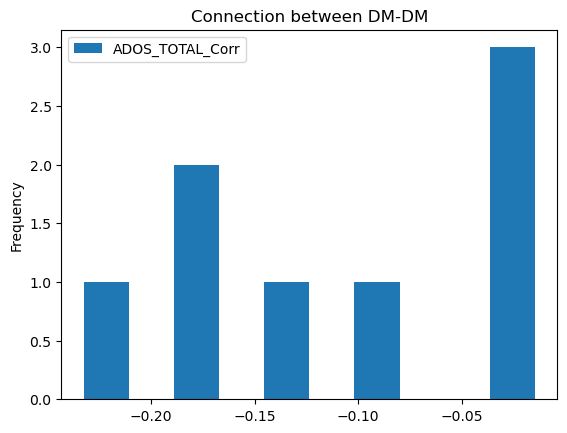

In [160]:
state[state['ROI-Pair'] == 'DM-DM'][['ADOS_TOTAL_Corr']].plot(kind = 'hist')
plt.title('Connection between DM-DM')
plt.show()

In [131]:
state_rois = state[state['ROI-Pair'] == 'CC-CC'][['First_ROI_Index', 'First_ROI_Name', 'Second_ROI_Index', 'Second_ROI_Name']]
state_rois.head()

First_ROI_Index                              First_ROI_Name  \
1                28  Superior medial frontal gyrus ([SMFG], 28)   
9                34        Supplementary motor area ([SMA], 34)   
19               27                                 Insula (27)   
60               30  Right inferior frontal gyrus ([R IFG], 30)   
63               28  Superior medial frontal gyrus ([SMFG], 28)   

    Second_ROI_Index                             Second_ROI_Name  
1                 35          Superior frontal gyrus ([SFG], 35)  
9                 37                    Hippocampus ([HiPP], 37)  
19                30  Right inferior frontal gyrus ([R IFG], 30)  
60                37                    Hippocampus ([HiPP], 37)  
63                40          Inferior frontal gyrus ([IFG], 40)

In [137]:
state_rois['First_ROI_Index'].value_counts()

28    4
27    3
29    3
34    2
39    2
30    1
38    1
36    1
35    1
40    1
31    1
33    1
Name: First_ROI_Index, dtype: int64

In [139]:
state_rois['Second_ROI_Index'].value_counts()

39    4
37    3
41    3
34    3
40    2
36    2
35    1
30    1
42    1
33    1
Name: Second_ROI_Index, dtype: int64

**State3**

In [107]:
state = pd.read_csv(f'./Phenotypes/States/State3_Analysis.csv')
state['First_ROI_Network'] = nm_labels.loc[state['First_ROI_Index']]['Network'].values
state['Second_ROI_Network'] = nm_labels.loc[state['Second_ROI_Index']]['Network'].values
state[['First_ROI_Network', 'First_ROI_Index', 'Second_ROI_Index', 'Second_ROI_Network']]

First_ROI_Network  First_ROI_Index  Second_ROI_Index Second_ROI_Network
0                  CC               32                44                 DM
1                  CC               32                49                 DM
2                  CC               30                47                 DM
3                  CC               32                45                 DM
4                  SM               12                37                 CC
..                ...              ...               ...                ...
192                CC               34                42                 CC
193                CC               31                37                 CC
194               VIS               22                44                 DM
195               VIS               18                32                 CC
196                CC               32                33                 CC

[197 rows x 4 columns]

In [108]:
print(f"Number of distinct connectivities less than 0.05: {(state['P_Values'] < 0.05).sum()}")
state['ROI-Pair'] = state['First_ROI_Network'] + '-' + state['Second_ROI_Network'] 
all_pairs = pd.DataFrame(state['ROI-Pair'].value_counts())
asd_pairs = pd.DataFrame(state[state['Dominant_Group'] == 'ASD']['ROI-Pair'].value_counts())
asd_pairs.rename(columns={'ROI-Pair' : 'ASD-Dominant'}, inplace = True)
td_pairs = pd.DataFrame(state[state['Dominant_Group'] == 'TD']['ROI-Pair'].value_counts())
td_pairs.rename(columns={'ROI-Pair' : 'TD-Dominant'}, inplace = True)
combined_df = pd.concat([all_pairs, asd_pairs, td_pairs], axis=1)
combined_df

Number of distinct connectivities less than 0.05: 197


ROI-Pair  ASD-Dominant  TD-Dominant
CC-DM          35          21.0         14.0
CC-CC          34          21.0         13.0
VIS-CC         24           6.0         18.0
VIS-DM         19          17.0          2.0
DM-DM          13           NaN         13.0
VIS-VIS        10           5.0          5.0
SC-SM           8           8.0          NaN
SC-CC           8           2.0          6.0
SM-DM           7           7.0          NaN
SM-CC           6           1.0          5.0
SM-CB           5           3.0          2.0
AUD-CC          4           1.0          3.0
AUD-VIS         3           NaN          3.0
SM-VIS          3           2.0          1.0
SM-SM           3           NaN          3.0
SC-DM           2           1.0          1.0
SC-CB           2           NaN          2.0
DM-CB           2           NaN          2.0
SC-AUD          2           2.0          NaN
AUD-DM          2           2.0          NaN
SC-VIS          2           2.0          NaN
CC-CB           2           2.0          NaN
CB-CB           1           NaN          1.0

In [110]:
combined_df.sum()

ROI-Pair        197.0
ASD-Dominant    103.0
TD-Dominant      94.0
dtype: float64

**State2**

In [111]:
state = pd.read_csv(f'./Phenotypes/States/State2_Analysis.csv')
state['First_ROI_Network'] = nm_labels.loc[state['First_ROI_Index']]['Network'].values
state['Second_ROI_Network'] = nm_labels.loc[state['Second_ROI_Index']]['Network'].values
state[['First_ROI_Network', 'First_ROI_Index', 'Second_ROI_Index', 'Second_ROI_Network']]

First_ROI_Network  First_ROI_Index  Second_ROI_Index Second_ROI_Network
0                  DM               43                44                 DM
1                  DM               43                49                 DM
2                 VIS               24                49                 DM
3                  CC               28                45                 DM
4                  CC               26                31                 CC
..                ...              ...               ...                ...
182                SM               12                48                 DM
183                SM                8                32                 CC
184                SC                2                14                 SM
185                SM               12                43                 DM
186               VIS               17                25                VIS

[187 rows x 4 columns]

In [112]:
print(f"Number of distinct connectivities less than 0.05: {(state['P_Values'] < 0.05).sum()}")
state['ROI-Pair'] = state['First_ROI_Network'] + '-' + state['Second_ROI_Network'] 
all_pairs = pd.DataFrame(state['ROI-Pair'].value_counts())
asd_pairs = pd.DataFrame(state[state['Dominant_Group'] == 'ASD']['ROI-Pair'].value_counts())
asd_pairs.rename(columns={'ROI-Pair' : 'ASD-Dominant'}, inplace = True)
td_pairs = pd.DataFrame(state[state['Dominant_Group'] == 'TD']['ROI-Pair'].value_counts())
td_pairs.rename(columns={'ROI-Pair' : 'TD-Dominant'}, inplace = True)
combined_df = pd.concat([all_pairs, asd_pairs, td_pairs], axis=1)
combined_df

Number of distinct connectivities less than 0.05: 187


ROI-Pair  ASD-Dominant  TD-Dominant
CC-DM          30          20.0         10.0
CC-CC          26          17.0          9.0
SC-CC          13           9.0          4.0
VIS-CC         13           6.0          7.0
SM-CC          11           4.0          7.0
SM-DM          10          10.0          NaN
DM-DM          10           NaN         10.0
VIS-DM          9           6.0          3.0
SM-VIS          9           1.0          8.0
SM-SM           8           2.0          6.0
CC-CB           8           1.0          7.0
SC-SM           8           8.0          NaN
VIS-VIS         7           3.0          4.0
AUD-VIS         4           NaN          4.0
SC-CB           3           NaN          3.0
SC-DM           3           3.0          NaN
SC-AUD          3           3.0          NaN
SC-VIS          3           NaN          3.0
AUD-CC          2           2.0          NaN
SM-CB           2           1.0          1.0
AUD-DM          2           2.0          NaN
VIS-CB          2           1.0          1.0
DM-CB           1           1.0          NaN

In [114]:
combined_df.sum()

ROI-Pair        187.0
ASD-Dominant    100.0
TD-Dominant      87.0
dtype: float64

**State1**

In [115]:
state = pd.read_csv(f'./Phenotypes/States/State1_Analysis.csv')
state['First_ROI_Network'] = nm_labels.loc[state['First_ROI_Index']]['Network'].values
state['Second_ROI_Network'] = nm_labels.loc[state['Second_ROI_Index']]['Network'].values
state[['First_ROI_Network', 'First_ROI_Index', 'Second_ROI_Index', 'Second_ROI_Network']]

First_ROI_Network  First_ROI_Index  Second_ROI_Index Second_ROI_Network
0                 CC               36                49                 DM
1                 SM               16                26                 CC
2                 CC               40                48                 DM
3                 SM               13                52                 CB
4                VIS               24                40                 CC
..               ...              ...               ...                ...
91                SM                8                24                VIS
92                SM                8                20                VIS
93                SM               14                20                VIS
94                SM               14                17                VIS
95                SM               14                24                VIS

[96 rows x 4 columns]

In [116]:
print(f"Number of distinct connectivities less than 0.05: {(state['P_Values'] < 0.05).sum()}")
state['ROI-Pair'] = state['First_ROI_Network'] + '-' + state['Second_ROI_Network'] 
all_pairs = pd.DataFrame(state['ROI-Pair'].value_counts())
asd_pairs = pd.DataFrame(state[state['Dominant_Group'] == 'ASD']['ROI-Pair'].value_counts())
asd_pairs.rename(columns={'ROI-Pair' : 'ASD-Dominant'}, inplace = True)
td_pairs = pd.DataFrame(state[state['Dominant_Group'] == 'TD']['ROI-Pair'].value_counts())
td_pairs.rename(columns={'ROI-Pair' : 'TD-Dominant'}, inplace = True)
combined_df = pd.concat([all_pairs, asd_pairs, td_pairs], axis=1)
combined_df

Number of distinct connectivities less than 0.05: 96


ROI-Pair  ASD-Dominant  TD-Dominant
VIS-CC         15           8.0          7.0
CC-DM          13           8.0          5.0
SM-CC          12          10.0          2.0
SC-CC          11           4.0          7.0
CC-CC          10           8.0          2.0
CC-CB           8           1.0          7.0
SM-VIS          5           5.0          NaN
DM-DM           4           NaN          4.0
SM-DM           3           3.0          NaN
AUD-CC          3           3.0          NaN
SC-VIS          2           2.0          NaN
SM-CB           2           NaN          2.0
DM-CB           2           NaN          2.0
VIS-VIS         2           1.0          1.0
VIS-DM          1           1.0          NaN
SM-SM           1           1.0          NaN
AUD-VIS         1           NaN          1.0
VIS-CB          1           1.0          NaN

In [118]:
combined_df.sum()

ROI-Pair        96.0
ASD-Dominant    56.0
TD-Dominant     40.0
dtype: float64

# ADOS Correlation vs Networks

In [164]:
state = pd.read_csv(f'./Phenotypes/States/State1_Analysis.csv')
state['First_ROI_Network'] = nm_labels.loc[state['First_ROI_Index']]['Network'].values
state['Second_ROI_Network'] = nm_labels.loc[state['Second_ROI_Index']]['Network'].values
print(f"Number of distinct connectivities less than 0.05: {(state['P_Values'] < 0.05).sum()}")
state['ROI-Pair'] = state['First_ROI_Network'] + '-' + state['Second_ROI_Network'] 
state1 = state.copy()
state1.head()

Number of distinct connectivities less than 0.05: 96


Unnamed: 0  Connectivity_Index  ADOS_TOTAL_Corr  ADOS_COMM_Corr  \
0           0                1237        -0.473654       -0.373541   
1           1                 684        -0.371133       -0.238901   
2           2                1294        -0.334476       -0.180433   
3           3                 596        -0.322997       -0.372276   
4           4                 958        -0.316729       -0.228717   

   ADOS_SOCIAL_Corr  ADOS_STEREO_Corr  Unnamed: 0.1  First_ROI_Index  \
0         -0.452329         -0.193284            72               36   
1         -0.386477         -0.254195            55               16   
2         -0.369286         -0.012168            89               40   
3         -0.238628         -0.093170            80               13   
4         -0.314615         -0.023277            30               24   

                       First_ROI_Name  Second_ROI_Index  \
0   Middle frontal gyrus ([MiFG], 36)                49   
1      Postcentral gyrus ([PoCG], 16)                26   
2  Inferior frontal gyrus ([IFG], 40)                48   
3   Paracentral lobule ([ParaCL], 13)                52   
4      Lingual gyrus ([LingualG], 24)                40   

                          Second_ROI_Name  P_Values  ASD_Mean   TD_Mean  \
0  Posterior cingulate cortex ([PCC], 49)  0.035830 -0.086633 -0.174265   
1    Inferior parietal lobule ([IPL], 26)  0.027966  0.003119 -0.094838   
2                          Precuneus (48)  0.044729 -0.017139 -0.106732   
3                   Cerebellum ([CB], 52)  0.038548  0.024874  0.120928   
4      Inferior frontal gyrus ([IFG], 40)  0.011015 -0.020595 -0.121668   

    ASD_STD    TD_STD Dominant_Group First_ROI_Network Second_ROI_Network  \
0  0.239782  0.237524            ASD                CC                 DM   
1  0.263090  0.247699            ASD                SM                 CC   
2  0.243278  0.263656            ASD                CC                 DM   
3  0.263059  0.266871             TD                SM                 CB   
4  0.233138  0.220936            ASD               VIS                 CC   

  ROI-Pair  
0    CC-DM  
1    SM-CC  
2    CC-DM  
3    SM-CB  
4   VIS-CC

In [165]:
state = pd.read_csv(f'./Phenotypes/States/State2_Analysis.csv')
state['First_ROI_Network'] = nm_labels.loc[state['First_ROI_Index']]['Network'].values
state['Second_ROI_Network'] = nm_labels.loc[state['Second_ROI_Index']]['Network'].values
print(f"Number of distinct connectivities less than 0.05: {(state['P_Values'] < 0.05).sum()}")
state['ROI-Pair'] = state['First_ROI_Network'] + '-' + state['Second_ROI_Network'] 
state2 = state.copy()
state2.head()

Number of distinct connectivities less than 0.05: 187


Unnamed: 0  Connectivity_Index  ADOS_TOTAL_Corr  ADOS_COMM_Corr  \
0           0                1323        -0.314952       -0.297352   
1           1                1328        -0.263409       -0.265450   
2           2                 967        -0.262553       -0.082809   
3           3                1069        -0.228019       -0.187399   
4           4                1004        -0.200388       -0.219937   

   ADOS_SOCIAL_Corr  ADOS_STEREO_Corr  Unnamed: 0.1  First_ROI_Index  \
0         -0.262644         -0.194523            41               43   
1         -0.209429         -0.088939           135               43   
2         -0.318333         -0.091001            80               24   
3         -0.206744         -0.172611            27               28   
4         -0.148562          0.111055           115               26   

                               First_ROI_Name  Second_ROI_Index  \
0                              Precuneus (43)                44   
1                              Precuneus (43)                49   
2              Lingual gyrus ([LingualG], 24)                49   
3  Superior medial frontal gyrus ([SMFG], 28)                45   
4        Inferior parietal lobule ([IPL], 26)                31   

                          Second_ROI_Name  P_Values  ASD_Mean   TD_Mean  \
0                          Precuneus (44)  0.005429  0.314874  0.390277   
1  Posterior cingulate cortex ([PCC], 49)  0.026523  0.331939  0.395897   
2  Posterior cingulate cortex ([PCC], 49)  0.013457  0.165875  0.109986   
3   Anterior cingulate cortex ([ACC], 45)  0.003503  0.302088  0.385854   
4       Middle frontal gyrus ([MiFG], 31)  0.021892  0.247529  0.186692   

    ASD_STD    TD_STD Dominant_Group First_ROI_Network Second_ROI_Network  \
0  0.229691  0.241029             TD                DM                 DM   
1  0.255541  0.247402             TD                DM                 DM   
2  0.186978  0.205192            ASD               VIS                 DM   
3  0.251980  0.246885             TD                CC                 DM   
4  0.216913  0.243113            ASD                CC                 CC   

  ROI-Pair  
0    DM-DM  
1    DM-DM  
2   VIS-DM  
3    CC-DM  
4    CC-CC

In [166]:
state = pd.read_csv(f'./Phenotypes/States/State3_Analysis.csv')
state['First_ROI_Network'] = nm_labels.loc[state['First_ROI_Index']]['Network'].values
state['Second_ROI_Network'] = nm_labels.loc[state['Second_ROI_Index']]['Network'].values
print(f"Number of distinct connectivities less than 0.05: {(state['P_Values'] < 0.05).sum()}")
state['ROI-Pair'] = state['First_ROI_Network'] + '-' + state['Second_ROI_Network'] 
state3 = state.copy()
state3.head()

Number of distinct connectivities less than 0.05: 197


Unnamed: 0  Connectivity_Index  ADOS_TOTAL_Corr  ADOS_COMM_Corr  \
0           0                1158        -0.301563       -0.212691   
1           1                1163        -0.297818       -0.354215   
2           2                1118        -0.274173       -0.164381   
3           3                1159        -0.271935       -0.232755   
4           4                 541        -0.222533       -0.147282   

   ADOS_SOCIAL_Corr  ADOS_STEREO_Corr  Unnamed: 0.1  First_ROI_Index  \
0         -0.293828         -0.079805            46               32   
1         -0.204393         -0.239636           104               32   
2         -0.284904          0.008126           135               30   
3         -0.240907         -0.114987           125               32   
4         -0.222900         -0.179211           185               12   

                               First_ROI_Name  Second_ROI_Index  \
0        Inferior parietal lobule ([IPL], 32)                44   
1        Inferior parietal lobule ([IPL], 32)                49   
2  Right inferior frontal gyrus ([R IFG], 30)                47   
3        Inferior parietal lobule ([IPL], 32)                45   
4        Superior parietal lobule ([SPL], 12)                37   

                          Second_ROI_Name  P_Values  ASD_Mean   TD_Mean  \
0                          Precuneus (44)  0.002938 -0.123648 -0.206394   
1  Posterior cingulate cortex ([PCC], 49)  0.014767  0.023350 -0.056310   
2   Anterior cingulate cortex ([ACC], 47)  0.027381  0.017130 -0.037501   
3   Anterior cingulate cortex ([ACC], 45)  0.023446 -0.015243 -0.081683   
4                Hippocampus ([HiPP], 37)  0.045139 -0.005911  0.037516   

    ASD_STD    TD_STD Dominant_Group First_ROI_Network Second_ROI_Network  \
0  0.218632  0.243620            ASD                CC                 DM   
1  0.229444  0.305875            ASD                CC                 DM   
2  0.193189  0.219144            ASD                CC                 DM   
3  0.235448  0.254312            ASD                CC                 DM   
4  0.188661  0.176321             TD                SM                 CC   

  ROI-Pair  
0    CC-DM  
1    CC-DM  
2    CC-DM  
3    CC-DM  
4    SM-CC

In [167]:
state = pd.read_csv(f'./Phenotypes/States/State4_Analysis.csv')
state['First_ROI_Network'] = nm_labels.loc[state['First_ROI_Index']]['Network'].values
state['Second_ROI_Network'] = nm_labels.loc[state['Second_ROI_Index']]['Network'].values
print(f"Number of distinct connectivities less than 0.05: {(state['P_Values'] < 0.05).sum()}")
state['ROI-Pair'] = state['First_ROI_Network'] + '-' + state['Second_ROI_Network'] 
state4 = state.copy()
state4.head()

Number of distinct connectivities less than 0.05: 138


Unnamed: 0  Connectivity_Index  ADOS_TOTAL_Corr  ADOS_COMM_Corr  \
0           0                1323        -0.232388       -0.149147   
1           1                1059        -0.205246       -0.158968   
2           2                 548        -0.202174       -0.161681   
3           3                   3        -0.195163       -0.138386   
4           4                1336        -0.181657       -0.046825   

   ADOS_SOCIAL_Corr  ADOS_STEREO_Corr  Unnamed: 0.1  First_ROI_Index  \
0         -0.238175         -0.196992             9               43   
1         -0.196612         -0.253324           123               28   
2         -0.189141         -0.105226            47               12   
3         -0.192467          0.012123            81                1   
4         -0.226222         -0.035140            79               44   

                               First_ROI_Name  Second_ROI_Index  \
0                              Precuneus (43)                44   
1  Superior medial frontal gyrus ([SMFG], 28)                35   
2        Superior parietal lobule ([SPL], 12)                44   
3                                 Caudate (1)                 5   
4                              Precuneus (44)                48   

                      Second_ROI_Name  P_Values  ASD_Mean   TD_Mean   ASD_STD  \
0                      Precuneus (44)  0.000600  0.153177  0.230096  0.195604   
1  Superior frontal gyrus ([SFG], 35)  0.042961  0.200912  0.251807  0.253627   
2                      Precuneus (44)  0.012230 -0.036339  0.010978  0.178648   
3                        Thalamus (5)  0.021841  0.168024  0.231613  0.251439   
4                      Precuneus (48)  0.020809  0.041718  0.089914  0.180083   

     TD_STD Dominant_Group First_ROI_Network Second_ROI_Network ROI-Pair  
0  0.230218             TD                DM                 DM    DM-DM  
1  0.227820             TD                CC                 CC    CC-CC  
2  0.182788             TD                SM                 DM    SM-DM  
3  0.278850             TD                SC                 SC    SC-SC  
4  0.217333             TD                DM                 DM    DM-DM

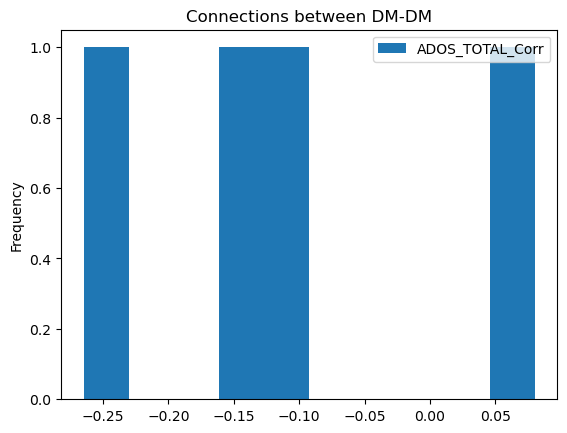

In [172]:
state1[state1['ROI-Pair'] == 'DM-DM'][['ADOS_TOTAL_Corr']].plot(kind = 'hist')
plt.title('Connections between DM-DM')
plt.show()

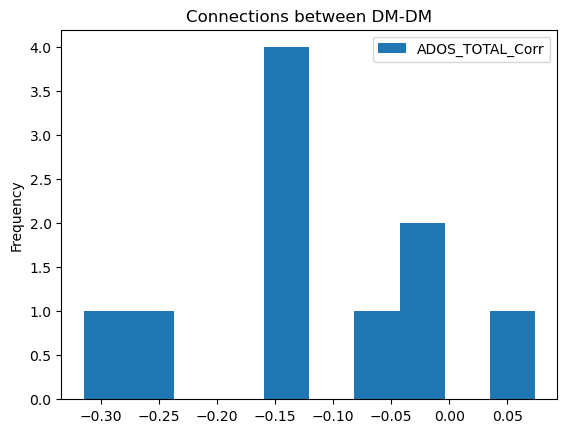

In [171]:
state2[state2['ROI-Pair'] == 'DM-DM'][['ADOS_TOTAL_Corr']].plot(kind = 'hist')
plt.title('Connections between DM-DM')
plt.show()

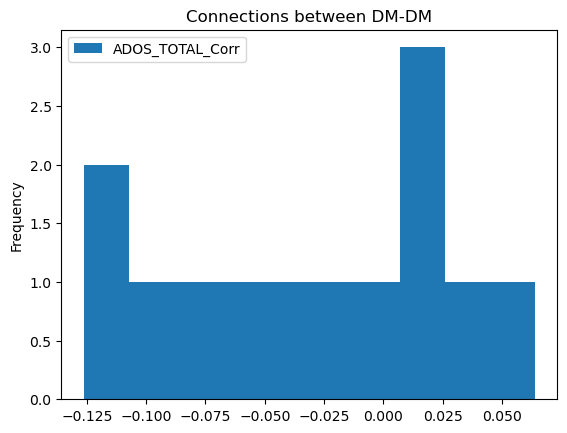

In [173]:
state3[state3['ROI-Pair'] == 'DM-DM'][['ADOS_TOTAL_Corr']].plot(kind = 'hist')
plt.title('Connections between DM-DM')
plt.show()

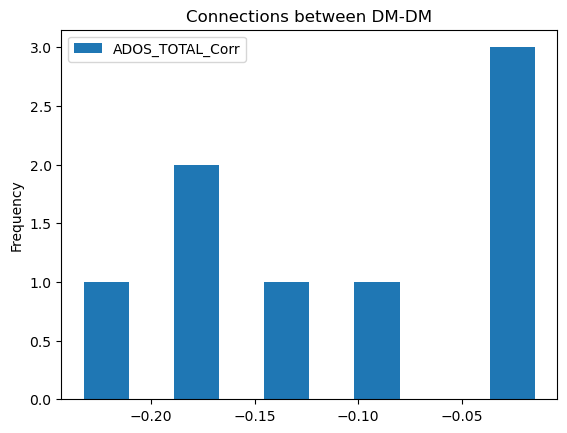

In [169]:
state4[state4['ROI-Pair'] == 'DM-DM'][['ADOS_TOTAL_Corr']].plot(kind = 'hist')
plt.title('Connections between DM-DM')
plt.show()

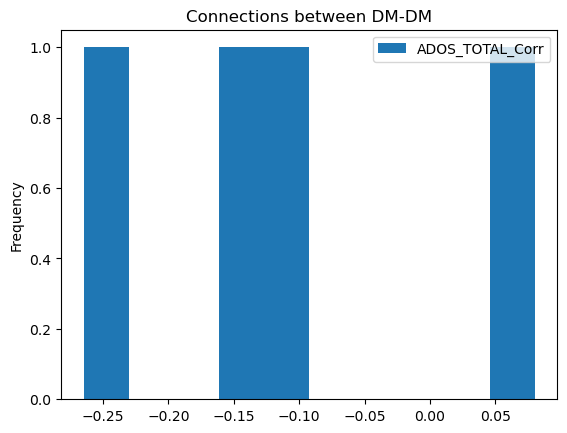

# Region level analysis

### State1

In [64]:
state = pd.read_csv(f'./Phenotypes/States/State1_Analysis.csv')
state['First_ROI_Network'] = nm_labels.loc[state['First_ROI_Index']]['Network'].values
state['Second_ROI_Network'] = nm_labels.loc[state['Second_ROI_Index']]['Network'].values
print(f"Number of distinct connectivities less than 0.05: {(state['P_Values'] < 0.05).sum()}")
state['ROI-Pair'] = state['First_ROI_Network'] + '-' + state['Second_ROI_Network'] 
state1 = state.copy()
state1.head()

Number of distinct connectivities less than 0.05: 96


Unnamed: 0  Connectivity_Index  ADOS_TOTAL_Corr  ADOS_COMM_Corr  \
0           0                1237        -0.473654       -0.373541   
1           1                 684        -0.371133       -0.238901   
2           2                1294        -0.334476       -0.180433   
3           3                 596        -0.322997       -0.372276   
4           4                 958        -0.316729       -0.228717   

   ADOS_SOCIAL_Corr  ADOS_STEREO_Corr  Unnamed: 0.1  First_ROI_Index  \
0         -0.452329         -0.193284            72               36   
1         -0.386477         -0.254195            55               16   
2         -0.369286         -0.012168            89               40   
3         -0.238628         -0.093170            80               13   
4         -0.314615         -0.023277            30               24   

                       First_ROI_Name  Second_ROI_Index  \
0   Middle frontal gyrus ([MiFG], 36)                49   
1      Postcentral gyrus ([PoCG], 16)                26   
2  Inferior frontal gyrus ([IFG], 40)                48   
3   Paracentral lobule ([ParaCL], 13)                52   
4      Lingual gyrus ([LingualG], 24)                40   

                          Second_ROI_Name  P_Values  ASD_Mean   TD_Mean  \
0  Posterior cingulate cortex ([PCC], 49)  0.035830 -0.086633 -0.174265   
1    Inferior parietal lobule ([IPL], 26)  0.027966  0.003119 -0.094838   
2                          Precuneus (48)  0.044729 -0.017139 -0.106732   
3                   Cerebellum ([CB], 52)  0.038548  0.024874  0.120928   
4      Inferior frontal gyrus ([IFG], 40)  0.011015 -0.020595 -0.121668   

    ASD_STD    TD_STD Dominant_Group First_ROI_Network Second_ROI_Network  \
0  0.239782  0.237524            ASD                CC                 DM   
1  0.263090  0.247699            ASD                SM                 CC   
2  0.243278  0.263656            ASD                CC                 DM   
3  0.263059  0.266871             TD                SM                 CB   
4  0.233138  0.220936            ASD               VIS                 CC   

  ROI-Pair  
0    CC-DM  
1    SM-CC  
2    CC-DM  
3    SM-CB  
4   VIS-CC

In [65]:
state1[state1['ROI-Pair'] == 'CC-CC'][['First_ROI_Name', 'Second_ROI_Name', 'Dominant_Group']].sort_values(by = 'Dominant_Group')

First_ROI_Name  \
25          Superior frontal gyrus ([SFG], 35)   
33        Supplementary motor area ([SMA], 34)   
48                                 Insula (27)   
54          Inferior frontal gyrus ([IFG], 29)   
56  Superior medial frontal gyrus ([SMFG], 28)   
57        Supplementary motor area ([SMA], 34)   
63           Middle frontal gyrus ([MiFG], 36)   
86           Middle frontal gyrus ([MiFG], 31)   
30                                 Insula (27)   
71        Inferior parietal lobule ([IPL], 26)   

                               Second_ROI_Name Dominant_Group  
25           Middle frontal gyrus ([MiFG], 36)            ASD  
33           Middle frontal gyrus ([MiFG], 36)            ASD  
48         Middle cingulate cortex ([MCC], 39)            ASD  
54          Inferior frontal gyrus ([IFG], 40)            ASD  
56           Middle frontal gyrus ([MiFG], 41)            ASD  
57           Middle frontal gyrus ([MiFG], 41)            ASD  
63         Middle cingulate cortex ([MCC], 39)            ASD  
86           Middle frontal gyrus ([MiFG], 36)            ASD  
30  Left inferior parietal lobue ([R IPL], 33)             TD  
71         Middle cingulate cortex ([MCC], 39)             TD

In [66]:
state1[(state1['ROI-Pair'] == 'CC-CC') & (state1['Dominant_Group'] == 'ASD')][['First_ROI_Index']].value_counts()

First_ROI_Index
34                 2
27                 1
28                 1
29                 1
31                 1
35                 1
36                 1
dtype: int64

In [67]:
state1[(state1['ROI-Pair'] == 'CC-CC') & (state1['Dominant_Group'] == 'ASD')][['Second_ROI_Index']].value_counts()

Second_ROI_Index
36                  3
39                  2
41                  2
40                  1
dtype: int64

In [68]:
state1[state1['ROI-Pair'] == 'CC-DM'][['First_ROI_Name', 'Second_ROI_Name', 'Dominant_Group']].sort_values(by = 'Dominant_Group')

First_ROI_Name  \
0             Middle frontal gyrus ([MiFG], 36)   
2            Inferior frontal gyrus ([IFG], 40)   
8    Right inferior frontal gyrus ([R IFG], 30)   
14         Inferior parietal lobule ([IPL], 32)   
39   Left inferior parietal lobue ([R IPL], 33)   
47   Left inferior parietal lobue ([R IPL], 33)   
69           Inferior frontal gyrus ([IFG], 40)   
76  Left inferior parietal lobule ([L IPL], 38)   
19          Middle cingulate cortex ([MCC], 39)   
36         Supplementary motor area ([SMA], 34)   
49         Inferior parietal lobule ([IPL], 26)   
72           Superior frontal gyrus ([SFG], 35)   
77                     Hippocampus ([HiPP], 37)   

                           Second_ROI_Name Dominant_Group  
0   Posterior cingulate cortex ([PCC], 49)            ASD  
2                           Precuneus (48)            ASD  
8   Posterior cingulate cortex ([PCC], 49)            ASD  
14                          Precuneus (43)            ASD  
39                          Precuneus (44)            ASD  
47                          Precuneus (48)            ASD  
69   Anterior cingulate cortex ([ACC], 45)            ASD  
76   Anterior cingulate cortex ([ACC], 45)            ASD  
19   Anterior cingulate cortex ([ACC], 47)             TD  
36  Posterior cingulate cortex ([PCC], 49)             TD  
49   Anterior cingulate cortex ([ACC], 47)             TD  
72   Anterior cingulate cortex ([ACC], 47)             TD  
77                          Precuneus (43)             TD

In [69]:
state1[(state1['ROI-Pair'] == 'CC-DM') & (state1['Dominant_Group'] == 'ASD')][['First_ROI_Index']].value_counts()

First_ROI_Index
33                 2
40                 2
30                 1
32                 1
36                 1
38                 1
dtype: int64

In [70]:
state1[(state1['ROI-Pair'] == 'CC-DM') & (state1['Dominant_Group'] == 'ASD')][['Second_ROI_Index']].value_counts()

Second_ROI_Index
45                  2
48                  2
49                  2
43                  1
44                  1
dtype: int64

In [71]:
state1[state1['ROI-Pair'] == 'DM-DM'][['First_ROI_Name', 'Second_ROI_Name', 'Dominant_Group']].sort_values(by = 'Dominant_Group')

First_ROI_Name  \
6                           Precuneus (43)   
22  Posterior cingulate cortex ([PCC], 46)   
26                          Precuneus (44)   
51                          Precuneus (44)   

                           Second_ROI_Name Dominant_Group  
6    Anterior cingulate cortex ([ACC], 45)             TD  
22   Anterior cingulate cortex ([ACC], 47)             TD  
26   Anterior cingulate cortex ([ACC], 45)             TD  
51  Posterior cingulate cortex ([PCC], 49)             TD

In [72]:
state1[(state1['ROI-Pair'] == 'DM-DM') & (state1['Dominant_Group'] == 'TD')][['First_ROI_Index']].value_counts()

First_ROI_Index
44                 2
43                 1
46                 1
dtype: int64

In [73]:
state1[(state1['ROI-Pair'] == 'DM-DM') & (state1['Dominant_Group'] == 'TD')][['Second_ROI_Index']].value_counts()

Second_ROI_Index
45                  2
47                  1
49                  1
dtype: int64

### State2

In [84]:
state = pd.read_csv(f'./Phenotypes/States/State2_Analysis.csv')
state['First_ROI_Network'] = nm_labels.loc[state['First_ROI_Index']]['Network'].values
state['Second_ROI_Network'] = nm_labels.loc[state['Second_ROI_Index']]['Network'].values
print(f"Number of distinct connectivities less than 0.05: {(state['P_Values'] < 0.05).sum()}")
state['ROI-Pair'] = state['First_ROI_Network'] + '-' + state['Second_ROI_Network'] 
state2 = state.copy()
state2.head()

Number of distinct connectivities less than 0.05: 187


Unnamed: 0  Connectivity_Index  ADOS_TOTAL_Corr  ADOS_COMM_Corr  \
0           0                1323        -0.314952       -0.297352   
1           1                1328        -0.263409       -0.265450   
2           2                 967        -0.262553       -0.082809   
3           3                1069        -0.228019       -0.187399   
4           4                1004        -0.200388       -0.219937   

   ADOS_SOCIAL_Corr  ADOS_STEREO_Corr  Unnamed: 0.1  First_ROI_Index  \
0         -0.262644         -0.194523            41               43   
1         -0.209429         -0.088939           135               43   
2         -0.318333         -0.091001            80               24   
3         -0.206744         -0.172611            27               28   
4         -0.148562          0.111055           115               26   

                               First_ROI_Name  Second_ROI_Index  \
0                              Precuneus (43)                44   
1                              Precuneus (43)                49   
2              Lingual gyrus ([LingualG], 24)                49   
3  Superior medial frontal gyrus ([SMFG], 28)                45   
4        Inferior parietal lobule ([IPL], 26)                31   

                          Second_ROI_Name  P_Values  ASD_Mean   TD_Mean  \
0                          Precuneus (44)  0.005429  0.314874  0.390277   
1  Posterior cingulate cortex ([PCC], 49)  0.026523  0.331939  0.395897   
2  Posterior cingulate cortex ([PCC], 49)  0.013457  0.165875  0.109986   
3   Anterior cingulate cortex ([ACC], 45)  0.003503  0.302088  0.385854   
4       Middle frontal gyrus ([MiFG], 31)  0.021892  0.247529  0.186692   

    ASD_STD    TD_STD Dominant_Group First_ROI_Network Second_ROI_Network  \
0  0.229691  0.241029             TD                DM                 DM   
1  0.255541  0.247402             TD                DM                 DM   
2  0.186978  0.205192            ASD               VIS                 DM   
3  0.251980  0.246885             TD                CC                 DM   
4  0.216913  0.243113            ASD                CC                 CC   

  ROI-Pair  
0    DM-DM  
1    DM-DM  
2   VIS-DM  
3    CC-DM  
4    CC-CC

In [85]:
state2[state2['ROI-Pair'] == 'CC-CC'][['First_ROI_Name', 'Second_ROI_Name', 'Dominant_Group']].sort_values(by = 'Dominant_Group')

First_ROI_Name  \
4          Inferior parietal lobule ([IPL], 26)   
159  Left inferior parietal lobue ([R IPL], 33)   
147         Middle cingulate cortex ([MCC], 39)   
146  Right inferior frontal gyrus ([R IFG], 30)   
136  Superior medial frontal gyrus ([SMFG], 28)   
126          Inferior frontal gyrus ([IFG], 29)   
125           Middle frontal gyrus ([MiFG], 36)   
113        Inferior parietal lobule ([IPL], 32)   
95                                  Insula (27)   
111           Middle frontal gyrus ([MiFG], 31)   
85         Inferior parietal lobule ([IPL], 26)   
81         Supplementary motor area ([SMA], 34)   
77           Superior frontal gyrus ([SFG], 35)   
56           Inferior frontal gyrus ([IFG], 40)   
47           Inferior frontal gyrus ([IFG], 29)   
45   Right inferior frontal gyrus ([R IFG], 30)   
91           Superior frontal gyrus ([SFG], 35)   
89   Right inferior frontal gyrus ([R IFG], 30)   
99   Right inferior frontal gyrus ([R IFG], 30)   
174        Inferior parietal lobule ([IPL], 32)   
78   Right inferior frontal gyrus ([R IFG], 30)   
135  Right inferior frontal gyrus ([R IFG], 30)   
143  Left inferior parietal lobue ([R IPL], 33)   
144          Inferior frontal gyrus ([IFG], 29)   
168         Middle cingulate cortex ([MCC], 39)   
178        Inferior parietal lobule ([IPL], 32)   

                                 Second_ROI_Name Dominant_Group  
4              Middle frontal gyrus ([MiFG], 31)            ASD  
159          Middle cingulate cortex ([MCC], 39)            ASD  
147           Inferior frontal gyrus ([IFG], 40)            ASD  
146                     Hippocampus ([HiPP], 37)            ASD  
136   Left inferior parietal lobue ([R IPL], 33)            ASD  
126                     Hippocampus ([HiPP], 37)            ASD  
125          Middle cingulate cortex ([MCC], 39)            ASD  
113           Superior frontal gyrus ([SFG], 35)            ASD  
95           Middle cingulate cortex ([MCC], 39)            ASD  
111           Superior frontal gyrus ([SFG], 35)            ASD  
85            Inferior frontal gyrus ([IFG], 40)            ASD  
81           Middle cingulate cortex ([MCC], 39)            ASD  
77             Middle frontal gyrus ([MiFG], 36)            ASD  
56             Middle frontal gyrus ([MiFG], 41)            ASD  
47           Middle cingulate cortex ([MCC], 39)            ASD  
45           Middle cingulate cortex ([MCC], 39)            ASD  
91            Inferior frontal gyrus ([IFG], 40)            ASD  
89          Inferior parietal lobule ([IPL], 32)             TD  
99             Middle frontal gyrus ([MiFG], 36)             TD  
174   Left inferior parietal lobue ([R IPL], 33)             TD  
78            Inferior frontal gyrus ([IFG], 40)             TD  
135   Left inferior parietal lobue ([R IPL], 33)             TD  
143           Inferior frontal gyrus ([IFG], 40)             TD  
144   Left inferior parietal lobue ([R IPL], 33)             TD  
168                     Hippocampus ([HiPP], 42)             TD  
178  Left inferior parietal lobule ([L IPL], 38)             TD

In [86]:
state2[(state2['ROI-Pair'] == 'CC-CC') & (state2['Dominant_Group'] == 'ASD')][['First_ROI_Index']].value_counts()

First_ROI_Index
26                 2
29                 2
30                 2
35                 2
27                 1
28                 1
31                 1
32                 1
33                 1
34                 1
36                 1
39                 1
40                 1
dtype: int64

In [87]:
state2[(state2['ROI-Pair'] == 'CC-CC') & (state2['Dominant_Group'] == 'ASD')][['Second_ROI_Index']].value_counts()

Second_ROI_Index
39                  6
40                  3
35                  2
37                  2
31                  1
33                  1
36                  1
41                  1
dtype: int64

In [88]:
state2[state2['ROI-Pair'] == 'CC-DM'][['First_ROI_Name', 'Second_ROI_Name', 'Dominant_Group']].sort_values(by = 'Dominant_Group')

First_ROI_Name  \
181        Inferior parietal lobule ([IPL], 32)   
82   Right inferior frontal gyrus ([R IFG], 30)   
79   Left inferior parietal lobue ([R IPL], 33)   
74           Inferior frontal gyrus ([IFG], 40)   
70   Left inferior parietal lobue ([R IPL], 33)   
175  Left inferior parietal lobue ([R IPL], 33)   
62                                  Insula (27)   
140          Inferior frontal gyrus ([IFG], 40)   
51   Left inferior parietal lobue ([R IPL], 33)   
106                                 Insula (27)   
50            Middle frontal gyrus ([MiFG], 36)   
160  Left inferior parietal lobue ([R IPL], 33)   
21   Left inferior parietal lobue ([R IPL], 33)   
162          Inferior frontal gyrus ([IFG], 29)   
18         Inferior parietal lobule ([IPL], 32)   
17           Inferior frontal gyrus ([IFG], 40)   
10            Middle frontal gyrus ([MiFG], 36)   
167        Inferior parietal lobule ([IPL], 32)   
33   Right inferior frontal gyrus ([R IFG], 30)   
107          Inferior frontal gyrus ([IFG], 40)   
149                    Hippocampus ([HiPP], 37)   
127          Superior frontal gyrus ([SFG], 35)   
3    Superior medial frontal gyrus ([SMFG], 28)   
59         Inferior parietal lobule ([IPL], 26)   
26   Superior medial frontal gyrus ([SMFG], 28)   
24           Superior frontal gyrus ([SFG], 35)   
20          Middle cingulate cortex ([MCC], 39)   
7            Superior frontal gyrus ([SFG], 35)   
88          Middle cingulate cortex ([MCC], 39)   
68           Superior frontal gyrus ([SFG], 35)   

                            Second_ROI_Name Dominant_Group  
181                          Precuneus (48)            ASD  
82   Posterior cingulate cortex ([PCC], 49)            ASD  
79                           Precuneus (43)            ASD  
74                           Precuneus (44)            ASD  
70    Anterior cingulate cortex ([ACC], 45)            ASD  
175                          Precuneus (48)            ASD  
62    Anterior cingulate cortex ([ACC], 45)            ASD  
140   Anterior cingulate cortex ([ACC], 45)            ASD  
51   Posterior cingulate cortex ([PCC], 49)            ASD  
106                          Precuneus (48)            ASD  
50                           Precuneus (48)            ASD  
160  Posterior cingulate cortex ([PCC], 46)            ASD  
21                           Precuneus (44)            ASD  
162                          Precuneus (44)            ASD  
18    Anterior cingulate cortex ([ACC], 45)            ASD  
17    Anterior cingulate cortex ([ACC], 47)            ASD  
10    Anterior cingulate cortex ([ACC], 45)            ASD  
167                          Precuneus (43)            ASD  
33                           Precuneus (44)            ASD  
107                          Precuneus (48)            ASD  
149                          Precuneus (43)             TD  
127   Anterior cingulate cortex ([ACC], 47)             TD  
3     Anterior cingulate cortex ([ACC], 45)             TD  
59   Posterior cingulate cortex ([PCC], 46)             TD  
26   Posterior cingulate cortex ([PCC], 46)             TD  
24    Anterior cingulate cortex ([ACC], 45)             TD  
20                           Precuneus (44)             TD  
7    Posterior cingulate cortex ([PCC], 49)             TD  
88    Anterior cingulate cortex ([ACC], 47)             TD  
68                           Precuneus (44)             TD

In [89]:
state2[(state2['ROI-Pair'] == 'CC-DM') & (state2['Dominant_Group'] == 'ASD')][['First_ROI_Index']].value_counts()

First_ROI_Index
33                 6
40                 4
32                 3
27                 2
30                 2
36                 2
29                 1
dtype: int64

In [90]:
state2[(state2['ROI-Pair'] == 'CC-DM') & (state2['Dominant_Group'] == 'ASD')][['Second_ROI_Index']].value_counts()

Second_ROI_Index
45                  5
48                  5
44                  4
43                  2
49                  2
46                  1
47                  1
dtype: int64

In [91]:
state2[state2['ROI-Pair'] == 'DM-DM'][['First_ROI_Name', 'Second_ROI_Name', 'Dominant_Group']].sort_values(by = 'Dominant_Group')

First_ROI_Name  \
0                           Precuneus (43)   
1                           Precuneus (43)   
12                          Precuneus (44)   
13   Anterior cingulate cortex ([ACC], 45)   
15                          Precuneus (43)   
16   Anterior cingulate cortex ([ACC], 45)   
43                          Precuneus (48)   
65                          Precuneus (44)   
86                          Precuneus (44)   
148  Anterior cingulate cortex ([ACC], 45)   

                            Second_ROI_Name Dominant_Group  
0                            Precuneus (44)             TD  
1    Posterior cingulate cortex ([PCC], 49)             TD  
12                           Precuneus (48)             TD  
13   Posterior cingulate cortex ([PCC], 49)             TD  
15    Anterior cingulate cortex ([ACC], 45)             TD  
16                           Precuneus (48)             TD  
43   Posterior cingulate cortex ([PCC], 49)             TD  
65    Anterior cingulate cortex ([ACC], 45)             TD  
86   Posterior cingulate cortex ([PCC], 49)             TD  
148   Anterior cingulate cortex ([ACC], 47)             TD

In [92]:
state2[(state2['ROI-Pair'] == 'DM-DM') & (state2['Dominant_Group'] == 'TD')][['First_ROI_Index']].value_counts()

First_ROI_Index
43                 3
44                 3
45                 3
48                 1
dtype: int64

In [93]:
state2[(state2['ROI-Pair'] == 'DM-DM') & (state2['Dominant_Group'] == 'TD')][['Second_ROI_Index']].value_counts()

Second_ROI_Index
49                  4
45                  2
48                  2
44                  1
47                  1
dtype: int64

### State 3

In [ ]:
state = pd.read_csv(f'./Phenotypes/States/State3_Analysis.csv')
state['First_ROI_Network'] = nm_labels.loc[state['First_ROI_Index']]['Network'].values
state['Second_ROI_Network'] = nm_labels.loc[state['Second_ROI_Index']]['Network'].values
print(f"Number of distinct connectivities less than 0.05: {(state['P_Values'] < 0.05).sum()}")
state['ROI-Pair'] = state['First_ROI_Network'] + '-' + state['Second_ROI_Network'] 
state3 = state.copy()
state3.head()

Number of distinct connectivities less than 0.05: 197


Unnamed: 0  Connectivity_Index  ADOS_TOTAL_Corr  ADOS_COMM_Corr  \
0           0                1158        -0.301563       -0.212691   
1           1                1163        -0.297818       -0.354215   
2           2                1118        -0.274173       -0.164381   
3           3                1159        -0.271935       -0.232755   
4           4                 541        -0.222533       -0.147282   

   ADOS_SOCIAL_Corr  ADOS_STEREO_Corr  Unnamed: 0.1  First_ROI_Index  \
0         -0.293828         -0.079805            46               32   
1         -0.204393         -0.239636           104               32   
2         -0.284904          0.008126           135               30   
3         -0.240907         -0.114987           125               32   
4         -0.222900         -0.179211           185               12   

                               First_ROI_Name  Second_ROI_Index  \
0        Inferior parietal lobule ([IPL], 32)                44   
1        Inferior parietal lobule ([IPL], 32)                49   
2  Right inferior frontal gyrus ([R IFG], 30)                47   
3        Inferior parietal lobule ([IPL], 32)                45   
4        Superior parietal lobule ([SPL], 12)                37   

                          Second_ROI_Name  P_Values  ASD_Mean   TD_Mean  \
0                          Precuneus (44)  0.002938 -0.123648 -0.206394   
1  Posterior cingulate cortex ([PCC], 49)  0.014767  0.023350 -0.056310   
2   Anterior cingulate cortex ([ACC], 47)  0.027381  0.017130 -0.037501   
3   Anterior cingulate cortex ([ACC], 45)  0.023446 -0.015243 -0.081683   
4                Hippocampus ([HiPP], 37)  0.045139 -0.005911  0.037516   

    ASD_STD    TD_STD Dominant_Group First_ROI_Network Second_ROI_Network  \
0  0.218632  0.243620            ASD                CC                 DM   
1  0.229444  0.305875            ASD                CC                 DM   
2  0.193189  0.219144            ASD                CC                 DM   
3  0.235448  0.254312            ASD                CC                 DM   
4  0.188661  0.176321             TD                SM                 CC   

  ROI-Pair  
0    CC-DM  
1    CC-DM  
2    CC-DM  
3    CC-DM  
4    SM-CC

In [ ]:
state3[state3['ROI-Pair'] == 'CC-CC'][['First_ROI_Name', 'Second_ROI_Name', 'Dominant_Group']].sort_values(by = 'Dominant_Group')

First_ROI_Name  \
6            Superior frontal gyrus ([SFG], 35)   
192        Supplementary motor area ([SMA], 34)   
181                                 Insula (27)   
173  Superior medial frontal gyrus ([SMFG], 28)   
168           Middle frontal gyrus ([MiFG], 36)   
165  Right inferior frontal gyrus ([R IFG], 30)   
164          Superior frontal gyrus ([SFG], 35)   
163                    Hippocampus ([HiPP], 37)   
149  Superior medial frontal gyrus ([SMFG], 28)   
147  Right inferior frontal gyrus ([R IFG], 30)   
193           Middle frontal gyrus ([MiFG], 31)   
108          Inferior frontal gyrus ([IFG], 29)   
128         Middle cingulate cortex ([MCC], 39)   
8          Inferior parietal lobule ([IPL], 32)   
99           Superior frontal gyrus ([SFG], 35)   
94           Superior frontal gyrus ([SFG], 35)   
10         Inferior parietal lobule ([IPL], 32)   
69   Superior medial frontal gyrus ([SMFG], 28)   
65   Superior medial frontal gyrus ([SMFG], 28)   
104  Superior medial frontal gyrus ([SMFG], 28)   
36           Superior frontal gyrus ([SFG], 35)   
103  Right inferior frontal gyrus ([R IFG], 30)   
188         Middle cingulate cortex ([MCC], 39)   
185  Left inferior parietal lobue ([R IPL], 33)   
176  Right inferior frontal gyrus ([R IFG], 30)   
59   Left inferior parietal lobue ([R IPL], 33)   
170           Middle frontal gyrus ([MiFG], 41)   
77   Superior medial frontal gyrus ([SMFG], 28)   
89                                  Insula (27)   
133          Inferior frontal gyrus ([IFG], 40)   
121                                 Insula (27)   
110           Middle frontal gyrus ([MiFG], 36)   
172        Inferior parietal lobule ([IPL], 32)   
196        Inferior parietal lobule ([IPL], 32)   

                                 Second_ROI_Name Dominant_Group  
6            Middle cingulate cortex ([MCC], 39)            ASD  
192                     Hippocampus ([HiPP], 42)            ASD  
181          Middle cingulate cortex ([MCC], 39)            ASD  
173                     Hippocampus ([HiPP], 37)            ASD  
168          Middle cingulate cortex ([MCC], 39)            ASD  
165           Superior frontal gyrus ([SFG], 35)            ASD  
164                     Hippocampus ([HiPP], 37)            ASD  
163            Middle frontal gyrus ([MiFG], 41)            ASD  
149           Inferior frontal gyrus ([IFG], 40)            ASD  
147                     Hippocampus ([HiPP], 37)            ASD  
193                     Hippocampus ([HiPP], 37)            ASD  
108          Middle cingulate cortex ([MCC], 39)            ASD  
128           Inferior frontal gyrus ([IFG], 40)            ASD  
8            Middle cingulate cortex ([MCC], 39)            ASD  
99   Left inferior parietal lobule ([L IPL], 38)            ASD  
94            Inferior frontal gyrus ([IFG], 40)            ASD  
10             Middle frontal gyrus ([MiFG], 41)            ASD  
69   Left inferior parietal lobule ([L IPL], 38)            ASD  
65    Right inferior frontal gyrus ([R IFG], 30)            ASD  
104   Left inferior parietal lobue ([R IPL], 33)            ASD  
36             Middle frontal gyrus ([MiFG], 36)            ASD  
103            Middle frontal gyrus ([MiFG], 36)             TD  
188                     Hippocampus ([HiPP], 42)             TD  
185            Middle frontal gyrus ([MiFG], 36)             TD  
176           Inferior frontal gyrus ([IFG], 40)             TD  
59   Left inferior parietal lobule ([L IPL], 38)             TD  
170                     Hippocampus ([HiPP], 42)             TD  
77            Superior frontal gyrus ([SFG], 35)             TD  
89            Inferior frontal gyrus ([IFG], 29)             TD  
133                     Hippocampus ([HiPP], 42)             TD  
121   Right inferior frontal gyrus ([R IFG], 30)             TD  
110  Left inferior parietal lobule ([L IPL], 38)             TD  
172  Left inferior parietal lobule ([L IPL], 38)             TD  
196

In [ ]:
state3[(state3['ROI-Pair'] == 'CC-CC') & (state3['Dominant_Group'] == 'ASD')][['First_ROI_Index']].value_counts()

First_ROI_Index
28                 5
35                 5
30                 2
32                 2
27                 1
29                 1
31                 1
34                 1
36                 1
37                 1
39                 1
dtype: int64

In [ ]:
state3[(state3['ROI-Pair'] == 'CC-CC') & (state3['Dominant_Group'] == 'ASD')][['Second_ROI_Index']].value_counts()

Second_ROI_Index
39                  5
37                  4
40                  3
38                  2
41                  2
30                  1
33                  1
35                  1
36                  1
42                  1
dtype: int64

In [ ]:
state3[state3['ROI-Pair'] == 'CC-DM'][['First_ROI_Name', 'Second_ROI_Name', 'Dominant_Group']].sort_values(by = 'Dominant_Group')

First_ROI_Name  \
0           Inferior parietal lobule ([IPL], 32)   
153            Middle frontal gyrus ([MiFG], 31)   
148           Inferior frontal gyrus ([IFG], 40)   
126   Right inferior frontal gyrus ([R IFG], 30)   
122  Left inferior parietal lobule ([L IPL], 38)   
90   Left inferior parietal lobule ([L IPL], 38)   
80    Left inferior parietal lobue ([R IPL], 33)   
154  Left inferior parietal lobule ([L IPL], 38)   
56   Left inferior parietal lobule ([L IPL], 38)   
53    Left inferior parietal lobue ([R IPL], 33)   
52            Inferior frontal gyrus ([IFG], 40)   
43           Middle cingulate cortex ([MCC], 39)   
64            Inferior frontal gyrus ([IFG], 40)   
37    Left inferior parietal lobue ([R IPL], 33)   
1           Inferior parietal lobule ([IPL], 32)   
2     Right inferior frontal gyrus ([R IFG], 30)   
3           Inferior parietal lobule ([IPL], 32)   
24    Left inferior parietal lobue ([R IPL], 33)   
183  Left inferior parietal lobule ([L IPL], 38)   
32            Inferior frontal gyrus ([IFG], 40)   
35             Middle frontal gyrus ([MiFG], 36)   
75    Superior medial frontal gyrus ([SMFG], 28)   
26    Superior medial frontal gyrus ([SMFG], 28)   
84             Middle frontal gyrus ([MiFG], 41)   
85           Middle cingulate cortex ([MCC], 39)   
41            Superior frontal gyrus ([SFG], 35)   
112         Supplementary motor area ([SMA], 34)   
113   Superior medial frontal gyrus ([SMFG], 28)   
118           Superior frontal gyrus ([SFG], 35)   
120           Superior frontal gyrus ([SFG], 35)   
5           Inferior parietal lobule ([IPL], 26)   
57    Superior medial frontal gyrus ([SMFG], 28)   
140           Superior frontal gyrus ([SFG], 35)   
71          Inferior parietal lobule ([IPL], 26)   
7     Superior medial frontal gyrus ([SMFG], 28)   

                            Second_ROI_Name Dominant_Group  
0                            Precuneus (44)            ASD  
153   Anterior cingulate cortex ([ACC], 47)            ASD  
148   Anterior cingulate cortex ([ACC], 45)            ASD  
126  Posterior cingulate cortex ([PCC], 49)            ASD  
122   Anterior cingulate cortex ([ACC], 47)            ASD  
90   Posterior cingulate cortex ([PCC], 49)            ASD  
80    Anterior cingulate cortex ([ACC], 45)            ASD  
154   Anterior cingulate cortex ([ACC], 45)            ASD  
56                           Precuneus (44)            ASD  
53    Anterior cingulate cortex ([ACC], 47)            ASD  
52                           Precuneus (44)            ASD  
43   Posterior cingulate cortex ([PCC], 46)            ASD  
64   Posterior cingulate cortex ([PCC], 49)            ASD  
37   Posterior cingulate cortex ([PCC], 49)            ASD  
1    Posterior cingulate cortex ([PCC], 49)            ASD  
2     Anterior cingulate cortex ([ACC], 47)            ASD  
3     Anterior cingulate cortex ([ACC], 45)            ASD  
24                           Precuneus (44)            ASD  
183                          Precuneus (43)            ASD  
32    Anterior cingulate cortex ([ACC], 47)            ASD  
35    Anterior cingulate cortex ([ACC], 45)            ASD  
75   Posterior cingulate cortex ([PCC], 46)             TD  
26    Anterior cingulate cortex ([ACC], 45)             TD  
84   Posterior cingulate cortex ([PCC], 46)             TD  
85    Anterior cingulate cortex ([ACC], 47)             TD  
41    Anterior cingulate cortex ([ACC], 45)             TD  
112                          Precuneus (44)             TD  
113                          Precuneus (44)             TD  
118  Posterior cingulate cortex ([PCC], 49)             TD  
120                          Precuneus (44)             TD  
5                            Precuneus (43)             TD  
57   Posterior cingulate cortex ([PCC], 49)             TD  
140   Anterior cingulate cortex ([ACC], 47)             TD  
71   Posterior cingulate cortex ([PCC], 46)             TD  
7                         

In [ ]:
state3[(state3['ROI-Pair'] == 'CC-DM') & (state3['Dominant_Group'] == 'ASD')][['First_ROI_Index']].value_counts()

First_ROI_Index
38                 5
33                 4
40                 4
32                 3
30                 2
31                 1
36                 1
39                 1
dtype: int64

In [ ]:
state3[(state3['ROI-Pair'] == 'CC-DM') & (state3['Dominant_Group'] == 'ASD')][['Second_ROI_Index']].value_counts()

Second_ROI_Index
45                  5
47                  5
49                  5
44                  4
43                  1
46                  1
dtype: int64

In [ ]:
state3[state3['ROI-Pair'] == 'DM-DM'][['First_ROI_Name', 'Second_ROI_Name', 'Dominant_Group']].sort_values(by = 'Dominant_Group')

First_ROI_Name  \
17                           Precuneus (43)   
21                           Precuneus (43)   
25                           Precuneus (43)   
34                           Precuneus (43)   
39    Anterior cingulate cortex ([ACC], 45)   
60    Anterior cingulate cortex ([ACC], 45)   
66                           Precuneus (44)   
96                           Precuneus (44)   
101   Anterior cingulate cortex ([ACC], 45)   
107  Posterior cingulate cortex ([PCC], 46)   
111                          Precuneus (43)   
119  Posterior cingulate cortex ([PCC], 46)   
146                          Precuneus (44)   

                            Second_ROI_Name Dominant_Group  
17   Posterior cingulate cortex ([PCC], 49)             TD  
21    Anterior cingulate cortex ([ACC], 45)             TD  
25                           Precuneus (44)             TD  
34    Anterior cingulate cortex ([ACC], 47)             TD  
39   Posterior cingulate cortex ([PCC], 49)             TD  
60   Posterior cingulate cortex ([PCC], 46)             TD  
66    Anterior cingulate cortex ([ACC], 45)             TD  
96   Posterior cingulate cortex ([PCC], 49)             TD  
101   Anterior cingulate cortex ([ACC], 47)             TD  
107  Posterior cingulate cortex ([PCC], 49)             TD  
111  Posterior cingulate cortex ([PCC], 46)             TD  
119   Anterior cingulate cortex ([ACC], 47)             TD  
146   Anterior cingulate cortex ([ACC], 47)             TD

In [ ]:
state3[(state3['ROI-Pair'] == 'DM-DM') & (state3['Dominant_Group'] == 'TD')][['First_ROI_Index']].value_counts()

First_ROI_Index
43                 5
44                 3
45                 3
46                 2
dtype: int64

In [ ]:
state3[(state3['ROI-Pair'] == 'DM-DM') & (state3['Dominant_Group'] == 'TD')][['Second_ROI_Index']].value_counts()

Second_ROI_Index
47                  4
49                  4
45                  2
46                  2
44                  1
dtype: int64

### State 4

In [94]:
state = pd.read_csv(f'./Phenotypes/States/State4_Analysis.csv')
state['First_ROI_Network'] = nm_labels.loc[state['First_ROI_Index']]['Network'].values
state['Second_ROI_Network'] = nm_labels.loc[state['Second_ROI_Index']]['Network'].values
print(f"Number of distinct connectivities less than 0.05: {(state['P_Values'] < 0.05).sum()}")
state['ROI-Pair'] = state['First_ROI_Network'] + '-' + state['Second_ROI_Network'] 
state4 = state.copy()
state4.head()

Number of distinct connectivities less than 0.05: 138


Unnamed: 0  Connectivity_Index  ADOS_TOTAL_Corr  ADOS_COMM_Corr  \
0           0                1323        -0.232388       -0.149147   
1           1                1059        -0.205246       -0.158968   
2           2                 548        -0.202174       -0.161681   
3           3                   3        -0.195163       -0.138386   
4           4                1336        -0.181657       -0.046825   

   ADOS_SOCIAL_Corr  ADOS_STEREO_Corr  Unnamed: 0.1  First_ROI_Index  \
0         -0.238175         -0.196992             9               43   
1         -0.196612         -0.253324           123               28   
2         -0.189141         -0.105226            47               12   
3         -0.192467          0.012123            81                1   
4         -0.226222         -0.035140            79               44   

                               First_ROI_Name  Second_ROI_Index  \
0                              Precuneus (43)                44   
1  Superior medial frontal gyrus ([SMFG], 28)                35   
2        Superior parietal lobule ([SPL], 12)                44   
3                                 Caudate (1)                 5   
4                              Precuneus (44)                48   

                      Second_ROI_Name  P_Values  ASD_Mean   TD_Mean   ASD_STD  \
0                      Precuneus (44)  0.000600  0.153177  0.230096  0.195604   
1  Superior frontal gyrus ([SFG], 35)  0.042961  0.200912  0.251807  0.253627   
2                      Precuneus (44)  0.012230 -0.036339  0.010978  0.178648   
3                        Thalamus (5)  0.021841  0.168024  0.231613  0.251439   
4                      Precuneus (48)  0.020809  0.041718  0.089914  0.180083   

     TD_STD Dominant_Group First_ROI_Network Second_ROI_Network ROI-Pair  
0  0.230218             TD                DM                 DM    DM-DM  
1  0.227820             TD                CC                 CC    CC-CC  
2  0.182788             TD                SM                 DM    SM-DM  
3  0.278850             TD                SC                 SC    SC-SC  
4  0.217333             TD                DM                 DM    DM-DM

In [95]:
state4[state4['ROI-Pair'] == 'CC-CC'][['First_ROI_Name', 'Second_ROI_Name', 'Dominant_Group']].sort_values(by = 'Dominant_Group')

First_ROI_Name  \
88             Middle frontal gyrus ([MiFG], 36)   
118         Supplementary motor area ([SMA], 34)   
106   Superior medial frontal gyrus ([SMFG], 28)   
104           Inferior frontal gyrus ([IFG], 40)   
103           Superior frontal gyrus ([SFG], 35)   
98           Middle cingulate cortex ([MCC], 39)   
86   Left inferior parietal lobule ([L IPL], 38)   
121                                  Insula (27)   
77                                   Insula (27)   
66            Inferior frontal gyrus ([IFG], 29)   
63    Superior medial frontal gyrus ([SMFG], 28)   
60    Right inferior frontal gyrus ([R IFG], 30)   
9           Supplementary motor area ([SMA], 34)   
80            Inferior frontal gyrus ([IFG], 29)   
83           Middle cingulate cortex ([MCC], 39)   
119   Left inferior parietal lobue ([R IPL], 33)   
19                                   Insula (27)   
109   Superior medial frontal gyrus ([SMFG], 28)   
113           Inferior frontal gyrus ([IFG], 29)   
116            Middle frontal gyrus ([MiFG], 31)   
1     Superior medial frontal gyrus ([SMFG], 28)   

                                Second_ROI_Name Dominant_Group  
88          Middle cingulate cortex ([MCC], 39)            ASD  
118         Middle cingulate cortex ([MCC], 39)            ASD  
106  Left inferior parietal lobue ([R IPL], 33)            ASD  
104           Middle frontal gyrus ([MiFG], 41)            ASD  
103           Middle frontal gyrus ([MiFG], 36)            ASD  
98           Inferior frontal gyrus ([IFG], 40)            ASD  
86            Middle frontal gyrus ([MiFG], 41)            ASD  
121         Middle cingulate cortex ([MCC], 39)            ASD  
77            Middle frontal gyrus ([MiFG], 41)            ASD  
66          Middle cingulate cortex ([MCC], 39)            ASD  
63           Inferior frontal gyrus ([IFG], 40)            ASD  
60                     Hippocampus ([HiPP], 37)            ASD  
9                      Hippocampus ([HiPP], 37)            ASD  
80                     Hippocampus ([HiPP], 37)            ASD  
83                     Hippocampus ([HiPP], 42)             TD  
119           Middle frontal gyrus ([MiFG], 36)             TD  
19   Right inferior frontal gyrus ([R IFG], 30)             TD  
109        Supplementary motor area ([SMA], 34)             TD  
113        Supplementary motor area ([SMA], 34)             TD  
116        Supplementary motor area ([SMA], 34)             TD  
1            Superior frontal gyrus ([SFG], 35)             TD

In [96]:
state4[(state4['ROI-Pair'] == 'CC-CC') & (state4['Dominant_Group'] == 'ASD')][['First_ROI_Index']].value_counts()

First_ROI_Index
27                 2
28                 2
29                 2
34                 2
30                 1
35                 1
36                 1
38                 1
39                 1
40                 1
dtype: int64

In [97]:
state4[(state4['ROI-Pair'] == 'CC-CC') & (state4['Dominant_Group'] == 'ASD')][['Second_ROI_Index']].value_counts()

Second_ROI_Index
39                  4
37                  3
41                  3
40                  2
33                  1
36                  1
dtype: int64

In [98]:
state4[state4['ROI-Pair'] == 'CC-DM'][['First_ROI_Name', 'Second_ROI_Name', 'Dominant_Group']].sort_values(by = 'Dominant_Group')

First_ROI_Name  \
48            Inferior frontal gyrus ([IFG], 40)   
126            Middle frontal gyrus ([MiFG], 31)   
82            Inferior frontal gyrus ([IFG], 40)   
76             Middle frontal gyrus ([MiFG], 41)   
72   Left inferior parietal lobule ([L IPL], 38)   
131         Inferior parietal lobule ([IPL], 32)   
44            Inferior frontal gyrus ([IFG], 40)   
135            Middle frontal gyrus ([MiFG], 41)   
32             Middle frontal gyrus ([MiFG], 36)   
16           Middle cingulate cortex ([MCC], 39)   
8           Inferior parietal lobule ([IPL], 32)   
43    Left inferior parietal lobue ([R IPL], 33)   
40    Superior medial frontal gyrus ([SMFG], 28)   
70    Superior medial frontal gyrus ([SMFG], 28)   
17            Superior frontal gyrus ([SFG], 35)   
78          Supplementary motor area ([SMA], 34)   
99          Inferior parietal lobule ([IPL], 26)   
6             Superior frontal gyrus ([SFG], 35)   

                            Second_ROI_Name Dominant_Group  
48                           Precuneus (44)            ASD  
126   Anterior cingulate cortex ([ACC], 47)            ASD  
82    Anterior cingulate cortex ([ACC], 45)            ASD  
76    Anterior cingulate cortex ([ACC], 47)            ASD  
72                           Precuneus (44)            ASD  
131                          Precuneus (43)            ASD  
44    Anterior cingulate cortex ([ACC], 47)            ASD  
135   Anterior cingulate cortex ([ACC], 45)            ASD  
32    Anterior cingulate cortex ([ACC], 45)            ASD  
16    Anterior cingulate cortex ([ACC], 45)            ASD  
8     Anterior cingulate cortex ([ACC], 45)            ASD  
43    Anterior cingulate cortex ([ACC], 47)            ASD  
40   Posterior cingulate cortex ([PCC], 46)             TD  
70   Posterior cingulate cortex ([PCC], 49)             TD  
17                           Precuneus (44)             TD  
78   Posterior cingulate cortex ([PCC], 49)             TD  
99   Posterior cingulate cortex ([PCC], 46)             TD  
6    Posterior cingulate cortex ([PCC], 49)             TD

In [99]:
state4[(state4['ROI-Pair'] == 'CC-DM') & (state4['Dominant_Group'] == 'ASD')][['First_ROI_Index']].value_counts()

First_ROI_Index
40                 3
32                 2
41                 2
31                 1
33                 1
36                 1
38                 1
39                 1
dtype: int64

In [100]:
state4[(state4['ROI-Pair'] == 'CC-DM') & (state4['Dominant_Group'] == 'ASD')][['Second_ROI_Index']].value_counts()

Second_ROI_Index
45                  5
47                  4
44                  2
43                  1
dtype: int64

In [101]:
state4[state4['ROI-Pair'] == 'DM-DM'][['First_ROI_Name', 'Second_ROI_Name', 'Dominant_Group']].sort_values(by = 'Dominant_Group')

First_ROI_Name  \
0                          Precuneus (43)   
4                          Precuneus (44)   
5   Anterior cingulate cortex ([ACC], 45)   
10                         Precuneus (43)   
27  Anterior cingulate cortex ([ACC], 45)   
61                         Precuneus (48)   
64                         Precuneus (44)   
69                         Precuneus (44)   

                           Second_ROI_Name Dominant_Group  
0                           Precuneus (44)             TD  
4                           Precuneus (48)             TD  
5   Posterior cingulate cortex ([PCC], 46)             TD  
10  Posterior cingulate cortex ([PCC], 49)             TD  
27  Posterior cingulate cortex ([PCC], 49)             TD  
61  Posterior cingulate cortex ([PCC], 49)             TD  
64  Posterior cingulate cortex ([PCC], 49)             TD  
69   Anterior cingulate cortex ([ACC], 45)             TD

In [102]:
state4[(state4['ROI-Pair'] == 'DM-DM') & (state4['Dominant_Group'] == 'TD')][['First_ROI_Index']].value_counts()

First_ROI_Index
44                 3
43                 2
45                 2
48                 1
dtype: int64

In [103]:
state4[(state4['ROI-Pair'] == 'DM-DM') & (state4['Dominant_Group'] == 'TD')][['Second_ROI_Index']].value_counts()

Second_ROI_Index
49                  4
44                  1
45                  1
46                  1
48                  1
dtype: int64

# Plotting centroids

In [146]:
## Plotting ASD and TD centroids
cs = scipy.io.loadmat(path + 'Stats_L1_ws20_city/All_age_ccs__dfnc_cluster_stats.mat')
print('Cluster stats using GIFT mat file keys : ', cs.keys())
dfnc_corrs = cs['dfnc_corrs']
dfnc_corrs = np.squeeze(dfnc_corrs)
dfnc_corrs.shape           # (n_subjects, states_vector_length, n_states)

Cluster stats using GIFT mat file keys :  dict_keys(['__header__', '__version__', '__globals__', 'thresholdWindows', 'dfnc_corrs', 'state_vector_stats', 'nuisance_cov_file'])


(383, 1378, 4)

In [147]:
dfnc_dict = utils.get_groups_dfnc(dfnc_corrs, groups, n_states = 4, mode = 'all')
print('Keys in dfnc_dict : ', list(dfnc_dict.keys()))        # Keys = States
print('Keys in dfnc_dict[0] : ', list(dfnc_dict[0].keys()))  
print('Shape of dfnc_dict[0]["ASD"] : ',dfnc_dict[0]["ASD"].shape)
print('Shape of dfnc_dict[0]["TD"] : ',dfnc_dict[0]["TD"].shape)

State :  1
Group : ASD and DFNC shape : (59, 1378)
Group : TD and DFNC shape : (79, 1378)
------------------------------------------------
State :  2
Group : ASD and DFNC shape : (145, 1378)
Group : TD and DFNC shape : (165, 1378)
------------------------------------------------
State :  3
Group : ASD and DFNC shape : (131, 1378)
Group : TD and DFNC shape : (158, 1378)
------------------------------------------------
State :  4
Group : ASD and DFNC shape : (185, 1378)
Group : TD and DFNC shape : (187, 1378)
------------------------------------------------
Keys in dfnc_dict :  [0, 1, 2, 3]
Keys in dfnc_dict[0] :  ['ASD', 'TD']
Shape of dfnc_dict[0]["ASD"] :  (59, 1378)
Shape of dfnc_dict[0]["TD"] :  (79, 1378)


In [148]:
nm_labels = pd.read_excel('./Phenotypes/NM_Template_Labels.xlsx', index_col = 'Indices')
nm_labels.head()

ROI Network
Indices                                      
1                         Caudate (1)      SC
2        Subthalamus/hypothalamus (2)      SC
3                         Putamen (3)      SC
4                         Caudate (4)      SC
5                        Thalamus (5)      SC

In [157]:
for state in range(4):
    for group in ['ASD', 'TD']:
        data = dfnc_dict[state][group]
        centroid = np.mean(data, axis = 0)
        centroid_mat = utils.vec2mat(centroid)
        labels = nm_labels['Network'].values
        df = pd.DataFrame(centroid_mat, columns = labels, index = labels)
        df.to_csv(f'./Phenotypes/Centroids/{group}_{state+1}.csv')
        

In [25]:
labels = nm_labels['Network'].values
labels

array(['SC', 'SC', 'SC', 'SC', 'SC', 'AUD', 'AUD', 'SM', 'SM', 'SM', 'SM',
       'SM', 'SM', 'SM', 'SM', 'SM', 'VIS', 'VIS', 'VIS', 'VIS', 'VIS',
       'VIS', 'VIS', 'VIS', 'VIS', 'CC', 'CC', 'CC', 'CC', 'CC', 'CC',
       'CC', 'CC', 'CC', 'CC', 'CC', 'CC', 'CC', 'CC', 'CC', 'CC', 'CC',
       'DM', 'DM', 'DM', 'DM', 'DM', 'DM', 'DM', 'CB', 'CB', 'CB', 'CB'],
      dtype=object)

In [26]:
asd1 = pd.read_csv(f'./Phenotypes/Centroids/ASD_1.csv', index_col = 'Unnamed: 0')
asd1.columns = labels
asd1.head()

SC        SC        SC        SC        SC       AUD       AUD  \
SC  1.000000  0.284037  0.257854  0.469293  0.306561 -0.227521 -0.063775   
SC  0.284037  1.000000  0.293363  0.303681  0.180109 -0.164567  0.017766   
SC  0.257854  0.293363  1.000000  0.417678  0.229603 -0.112914  0.075851   
SC  0.469293  0.303681  0.417678  1.000000  0.284812 -0.156923 -0.001481   
SC  0.306561  0.180109  0.229603  0.284812  1.000000 -0.112908 -0.027739   

          SM        SM        SM  ...        DM        DM        DM        DM  \
SC -0.200994 -0.229770 -0.259678  ...  0.019403  0.150775 -0.034169  0.142892   
SC -0.081222 -0.154549 -0.247653  ...  0.021391  0.026548 -0.064041  0.053390   
SC -0.055262 -0.175168 -0.247470  ... -0.029530  0.116388  0.003945  0.030605   
SC -0.156597 -0.210135 -0.240998  ...  0.011525  0.197941 -0.033274  0.149151   
SC -0.092820 -0.117959 -0.126817  ...  0.015895  0.081666  0.048146  0.038587   

          DM        DM        CB        CB        CB        CB  
SC -0.238360 -0.013817  0.202311  0.172434  0.224161  0.222111  
SC -0.223573 -0.089909  0.135867  0.039515  0.279934  0.163323  
SC -0.195556 -0.031100  0.138384 -0.028877  0.167181  0.132284  
SC -0.195505  0.022018  0.167078  0.088106  0.191152  0.170856  
SC -0.093455  0.031026  0.139687  0.121174  0.109320  0.172114  

[5 rows x 53 columns]

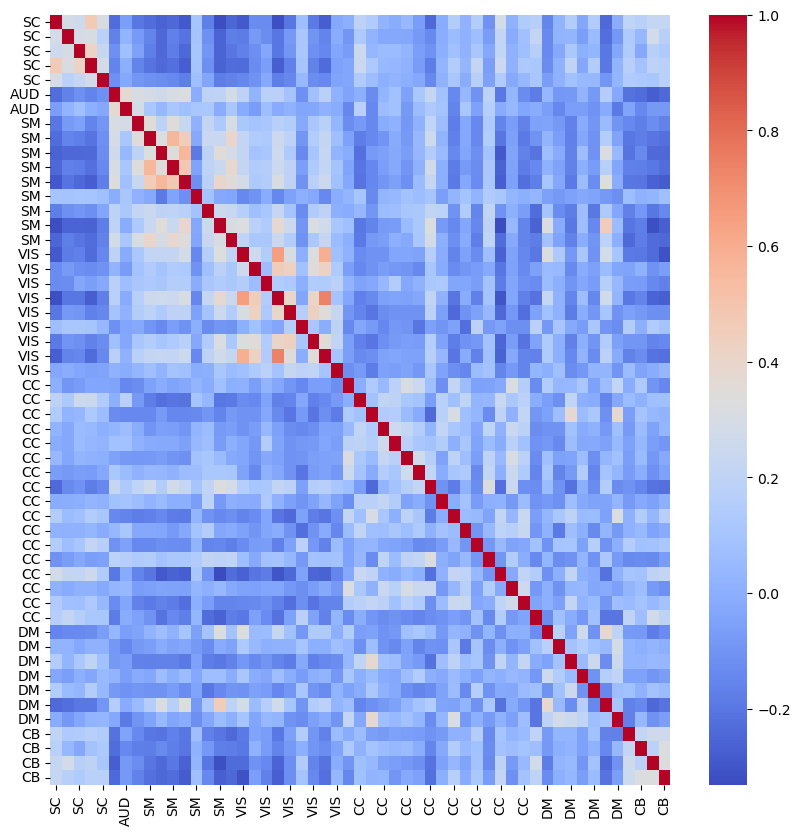

In [31]:
plt.figure(figsize = (10,10))
color = sns.color_palette("coolwarm", as_cmap=True)
sns.heatmap(asd1, cmap = color)
plt.show()

# Classification

# Circular plots

In [6]:
nm_labels = pd.read_excel('./Phenotypes/NM_Template_Labels.xlsx', index_col = 'Indices')
nm_labels.head()

ROI Network
Indices                                      
1                         Caudate (1)      SC
2        Subthalamus/hypothalamus (2)      SC
3                         Putamen (3)      SC
4                         Caudate (4)      SC
5                        Thalamus (5)      SC

Number of distinct connectivities less than 0.05: 96
Number of significant connection within and between CC, DM networks :  27
Number of non zero values in the above matrix : 54
Shape of centroid of CC-DM networks only (24, 24)
Number of non zero values in the Centroid CC-DM matrix : 54


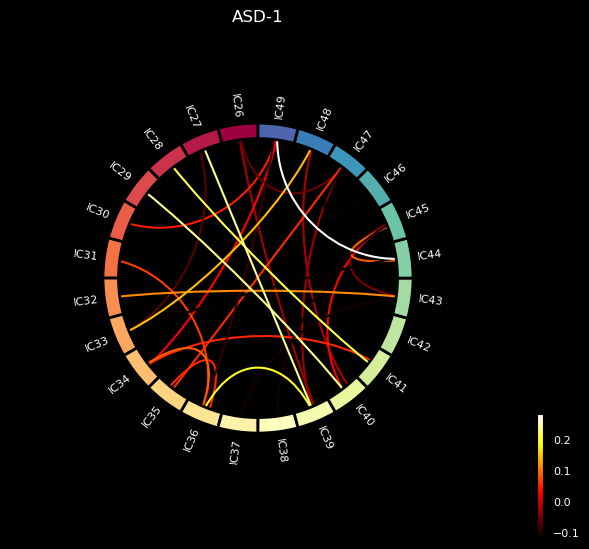

Number of distinct connectivities less than 0.05: 96
Number of significant connection within and between CC, DM networks :  27
Number of non zero values in the above matrix : 54
Shape of centroid of CC-DM networks only (24, 24)
Number of non zero values in the Centroid CC-DM matrix : 54


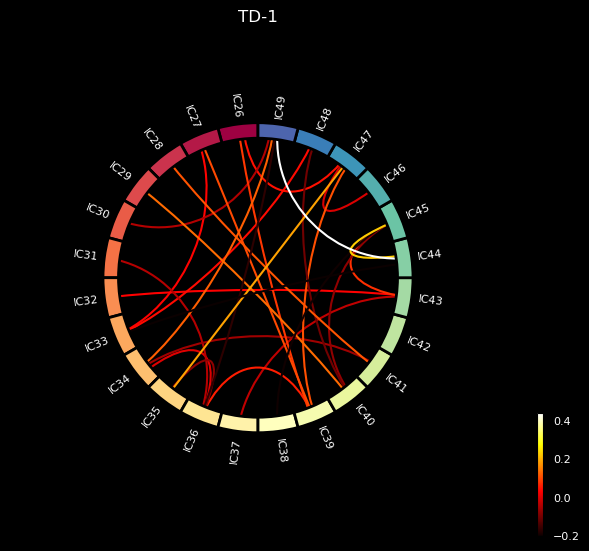

Number of distinct connectivities less than 0.05: 187
Number of significant connection within and between CC, DM networks :  66
Number of non zero values in the above matrix : 132
Shape of centroid of CC-DM networks only (24, 24)
Number of non zero values in the Centroid CC-DM matrix : 132


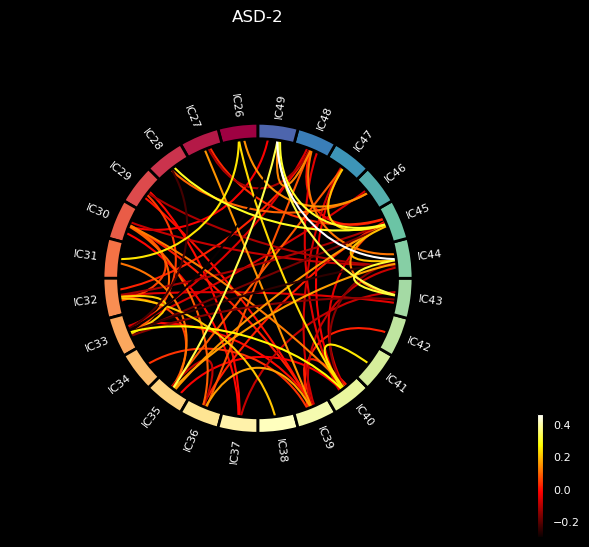

Number of distinct connectivities less than 0.05: 187
Number of significant connection within and between CC, DM networks :  66
Number of non zero values in the above matrix : 132
Shape of centroid of CC-DM networks only (24, 24)
Number of non zero values in the Centroid CC-DM matrix : 132


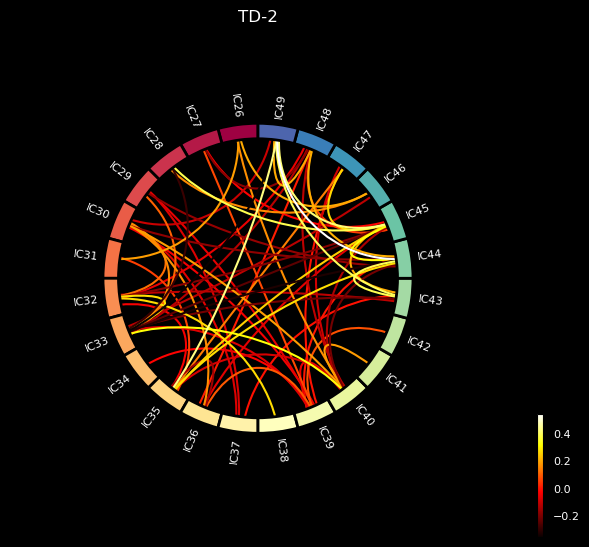

Number of distinct connectivities less than 0.05: 197
Number of significant connection within and between CC, DM networks :  82
Number of non zero values in the above matrix : 164
Shape of centroid of CC-DM networks only (24, 24)
Number of non zero values in the Centroid CC-DM matrix : 164


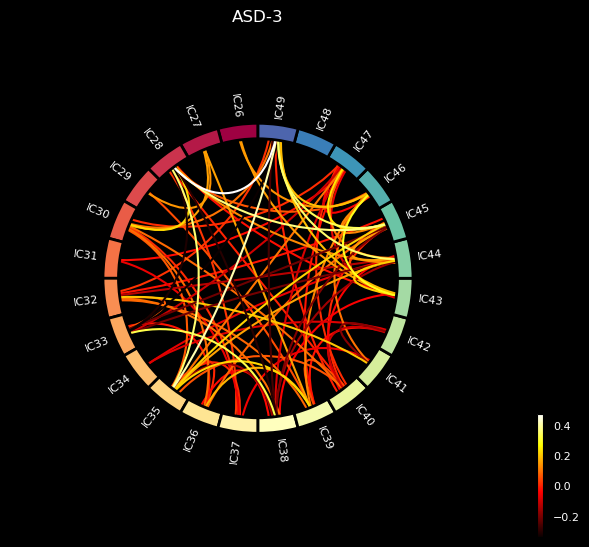

Number of distinct connectivities less than 0.05: 197
Number of significant connection within and between CC, DM networks :  82
Number of non zero values in the above matrix : 164
Shape of centroid of CC-DM networks only (24, 24)
Number of non zero values in the Centroid CC-DM matrix : 164


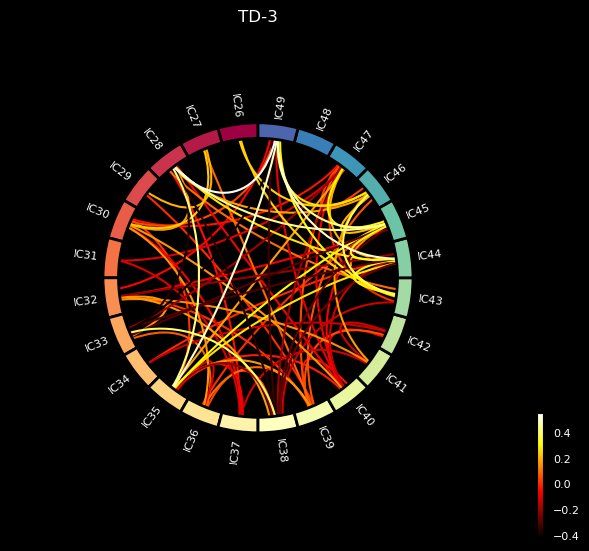

Number of distinct connectivities less than 0.05: 138
Number of significant connection within and between CC, DM networks :  47
Number of non zero values in the above matrix : 94
Shape of centroid of CC-DM networks only (24, 24)
Number of non zero values in the Centroid CC-DM matrix : 94


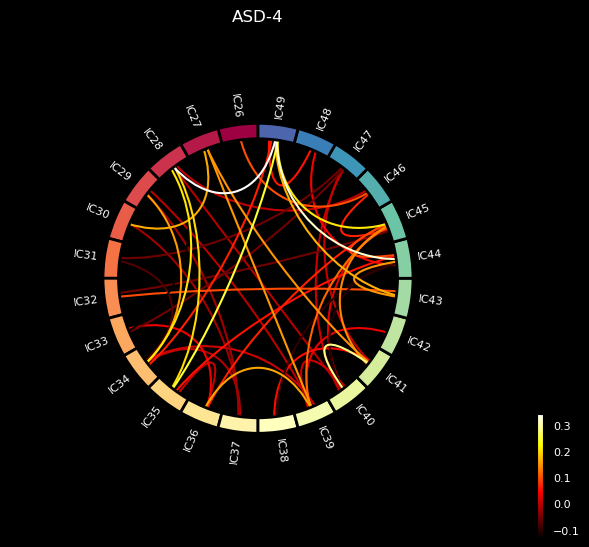

Number of distinct connectivities less than 0.05: 138
Number of significant connection within and between CC, DM networks :  47
Number of non zero values in the above matrix : 94
Shape of centroid of CC-DM networks only (24, 24)
Number of non zero values in the Centroid CC-DM matrix : 94


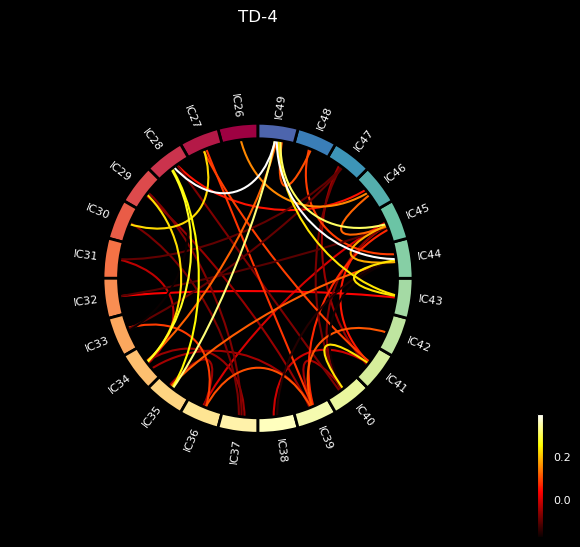

In [6]:
for i in range(1,5):
    for group in ['ASD', 'TD']:
        state = pd.read_csv(f'./Phenotypes/States/State{i}_Analysis.csv')
        state['First_ROI_Network'] = nm_labels.loc[state['First_ROI_Index']]['Network'].values
        state['Second_ROI_Network'] = nm_labels.loc[state['Second_ROI_Index']]['Network'].values
        print(f"Number of distinct connectivities less than 0.05: {(state['P_Values'] < 0.05).sum()}")
        state['ROI-Pair'] = state['First_ROI_Network'] + '-' + state['Second_ROI_Network'] 
        centroid = pd.read_csv(f'./Phenotypes/Centroids/{group}_{i}.csv', index_col='Unnamed: 0')
        utils.plot_CC_DM_connections(state, centroid, title = f'{group}-{i}', format = 'svg')

Number of distinct connectivities less than 0.05: 96
Number of significant connection within and between CC, DM networks :  27
Number of non zero values in the above matrix : 54
Shape of centroid of CC-DM networks only (24, 24)
Number of non zero values in the Centroid CC-DM matrix : 54


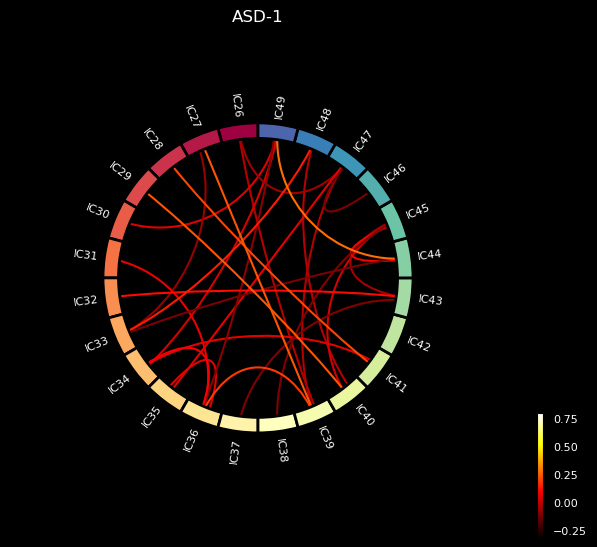

Number of distinct connectivities less than 0.05: 96
Number of significant connection within and between CC, DM networks :  27
Number of non zero values in the above matrix : 54
Shape of centroid of CC-DM networks only (24, 24)
Number of non zero values in the Centroid CC-DM matrix : 54


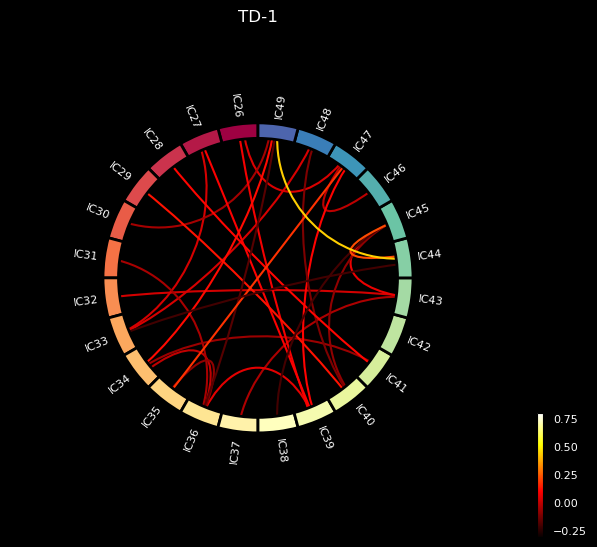

Number of distinct connectivities less than 0.05: 187
Number of significant connection within and between CC, DM networks :  66
Number of non zero values in the above matrix : 132
Shape of centroid of CC-DM networks only (24, 24)
Number of non zero values in the Centroid CC-DM matrix : 132


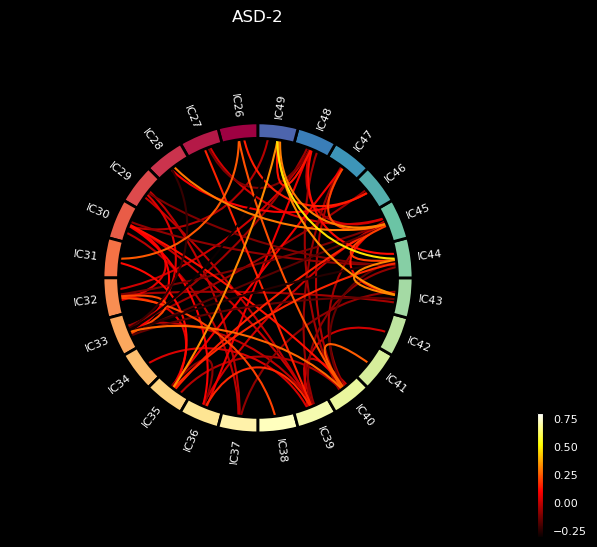

Number of distinct connectivities less than 0.05: 187
Number of significant connection within and between CC, DM networks :  66
Number of non zero values in the above matrix : 132
Shape of centroid of CC-DM networks only (24, 24)
Number of non zero values in the Centroid CC-DM matrix : 132


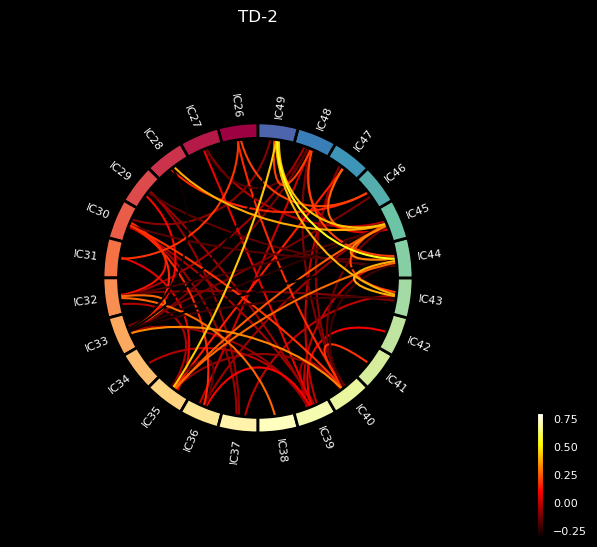

Number of distinct connectivities less than 0.05: 197
Number of significant connection within and between CC, DM networks :  82
Number of non zero values in the above matrix : 164
Shape of centroid of CC-DM networks only (24, 24)
Number of non zero values in the Centroid CC-DM matrix : 164


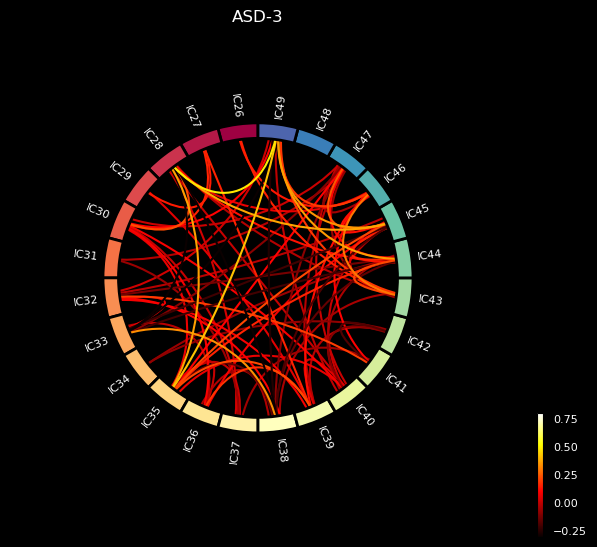

Number of distinct connectivities less than 0.05: 197
Number of significant connection within and between CC, DM networks :  82
Number of non zero values in the above matrix : 164
Shape of centroid of CC-DM networks only (24, 24)
Number of non zero values in the Centroid CC-DM matrix : 164


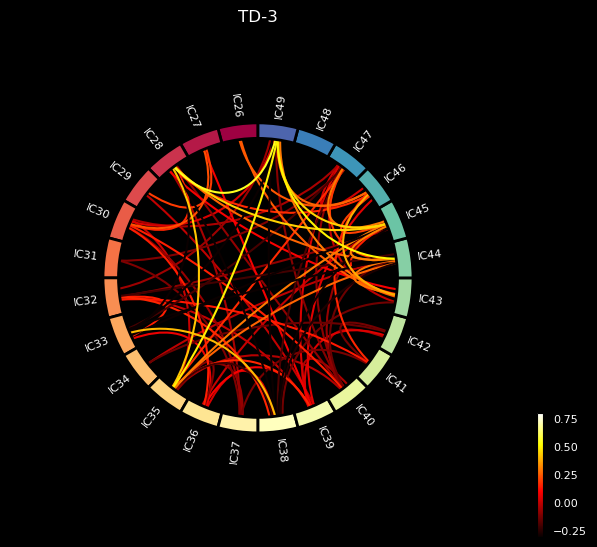

Number of distinct connectivities less than 0.05: 138
Number of significant connection within and between CC, DM networks :  47
Number of non zero values in the above matrix : 94
Shape of centroid of CC-DM networks only (24, 24)
Number of non zero values in the Centroid CC-DM matrix : 94


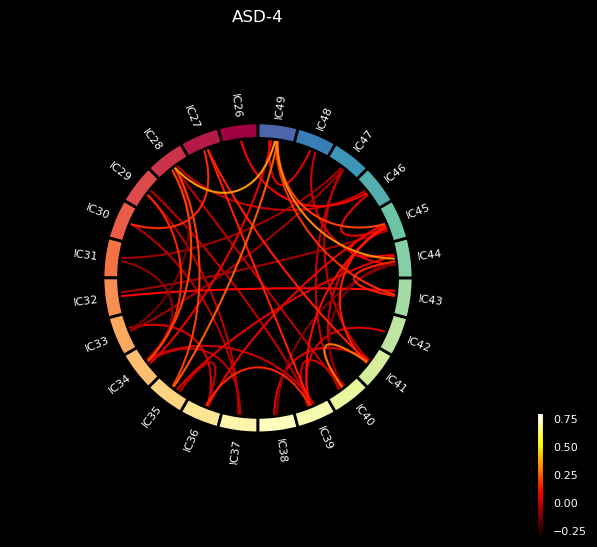

Number of distinct connectivities less than 0.05: 138
Number of significant connection within and between CC, DM networks :  47
Number of non zero values in the above matrix : 94
Shape of centroid of CC-DM networks only (24, 24)
Number of non zero values in the Centroid CC-DM matrix : 94


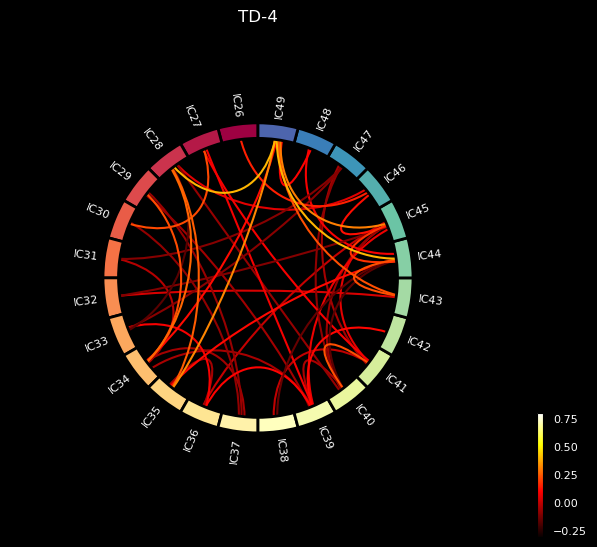

In [7]:
for i in range(1,5):
    for group in ['ASD', 'TD']:
        state = pd.read_csv(f'./Phenotypes/States/State{i}_Analysis.csv')
        state['First_ROI_Network'] = nm_labels.loc[state['First_ROI_Index']]['Network'].values
        state['Second_ROI_Network'] = nm_labels.loc[state['Second_ROI_Index']]['Network'].values
        print(f"Number of distinct connectivities less than 0.05: {(state['P_Values'] < 0.05).sum()}")
        state['ROI-Pair'] = state['First_ROI_Network'] + '-' + state['Second_ROI_Network'] 
        centroid = pd.read_csv(f'./Phenotypes/Centroids/{group}_{i}.csv', index_col='Unnamed: 0')
        utils.plot_CC_DM_connections(state, centroid, title = f'{group}-{i}', format = 'svg')

In [7]:
for i in range(1,5):
    state = pd.read_csv(f'./Phenotypes/States/State{i}_Analysis.csv')
    state['First_ROI_Network'] = nm_labels.loc[state['First_ROI_Index']]['Network'].values
    state['Second_ROI_Network'] = nm_labels.loc[state['Second_ROI_Index']]['Network'].values
    print(f"Number of distinct connectivities less than 0.05: {(state['P_Values'] < 0.05).sum()}")
    state['Networks'] = state['First_ROI_Network'] + '-' + state['Second_ROI_Network'] 
    state.to_csv(f'./Phenotypes/States/State{i}_Analysis.csv')

Number of distinct connectivities less than 0.05: 96
Number of distinct connectivities less than 0.05: 187
Number of distinct connectivities less than 0.05: 197
Number of distinct connectivities less than 0.05: 138


Number of distinct connectivities less than 0.05: 96
Number of significant connection within and between CC, DM networks :  16
Number of non zero values in the above matrix : 32
Shape of centroid of CC-DM networks only (24, 24)
Number of non zero values in the Centroid CC-DM matrix : 32


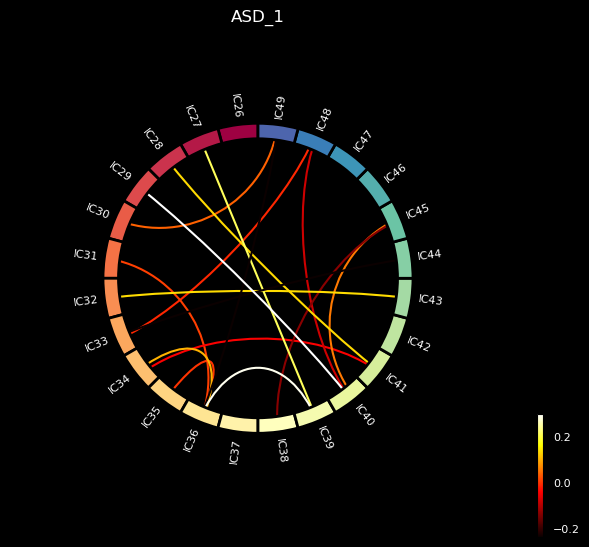

Number of distinct connectivities less than 0.05: 96
Number of significant connection within and between CC, DM networks :  11
Number of non zero values in the above matrix : 22
Shape of centroid of CC-DM networks only (24, 24)
Number of non zero values in the Centroid CC-DM matrix : 22


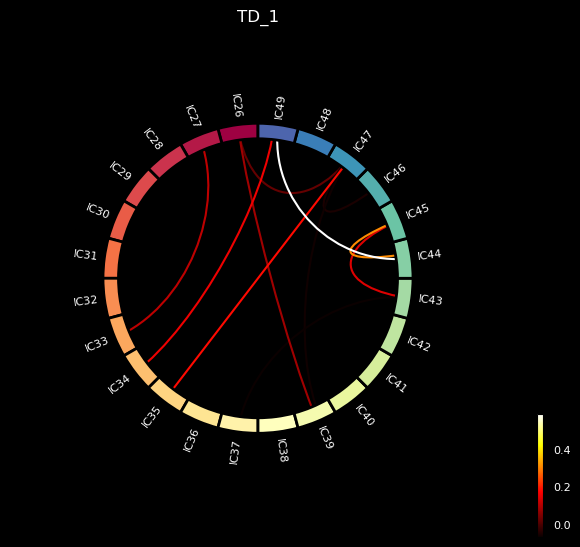

Number of distinct connectivities less than 0.05: 187
Number of significant connection within and between CC, DM networks :  37
Number of non zero values in the above matrix : 74
Shape of centroid of CC-DM networks only (24, 24)
Number of non zero values in the Centroid CC-DM matrix : 74


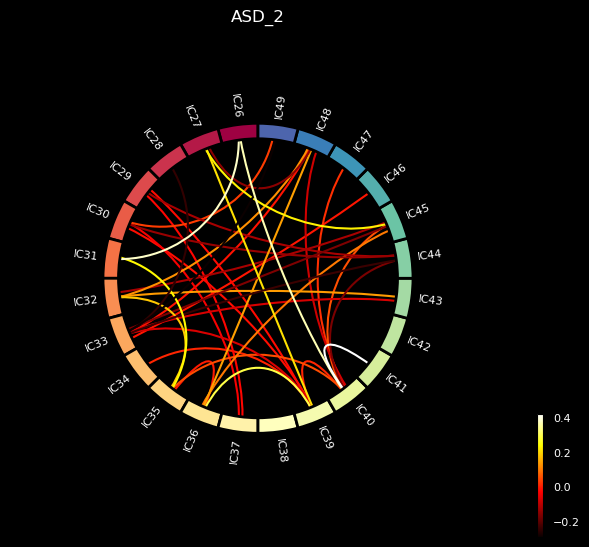

Number of distinct connectivities less than 0.05: 187
Number of significant connection within and between CC, DM networks :  29
Number of non zero values in the above matrix : 58
Shape of centroid of CC-DM networks only (24, 24)
Number of non zero values in the Centroid CC-DM matrix : 58


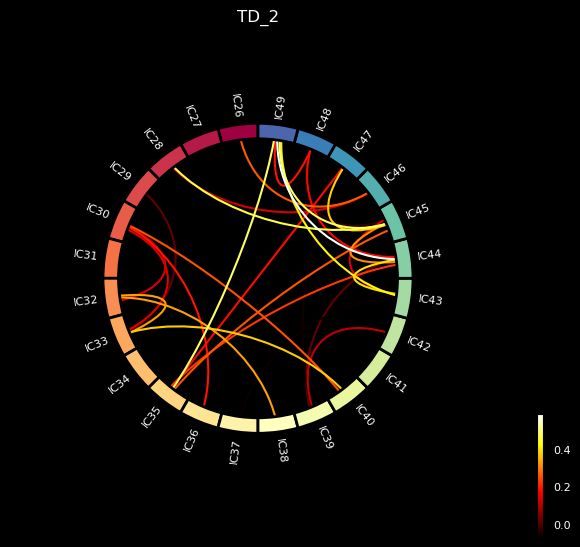

Number of distinct connectivities less than 0.05: 197
Number of significant connection within and between CC, DM networks :  42
Number of non zero values in the above matrix : 84
Shape of centroid of CC-DM networks only (24, 24)
Number of non zero values in the Centroid CC-DM matrix : 84


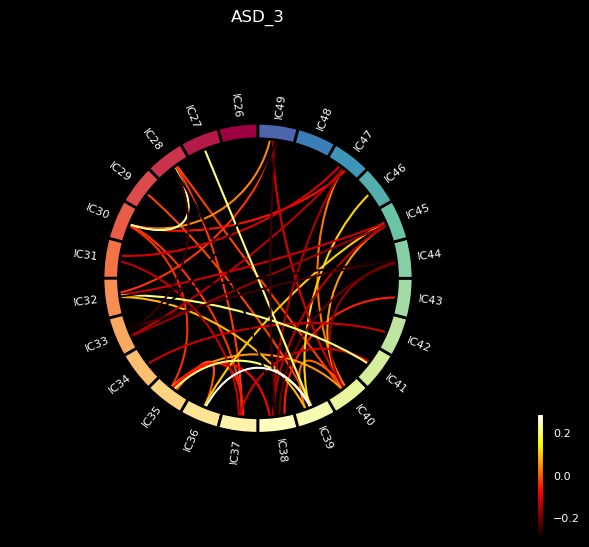

Number of distinct connectivities less than 0.05: 197
Number of significant connection within and between CC, DM networks :  40
Number of non zero values in the above matrix : 80
Shape of centroid of CC-DM networks only (24, 24)
Number of non zero values in the Centroid CC-DM matrix : 80


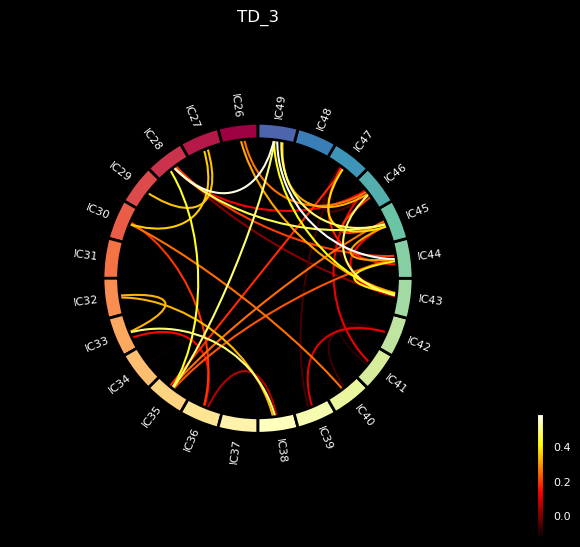

Number of distinct connectivities less than 0.05: 138
Number of significant connection within and between CC, DM networks :  26
Number of non zero values in the above matrix : 52
Shape of centroid of CC-DM networks only (24, 24)
Number of non zero values in the Centroid CC-DM matrix : 52


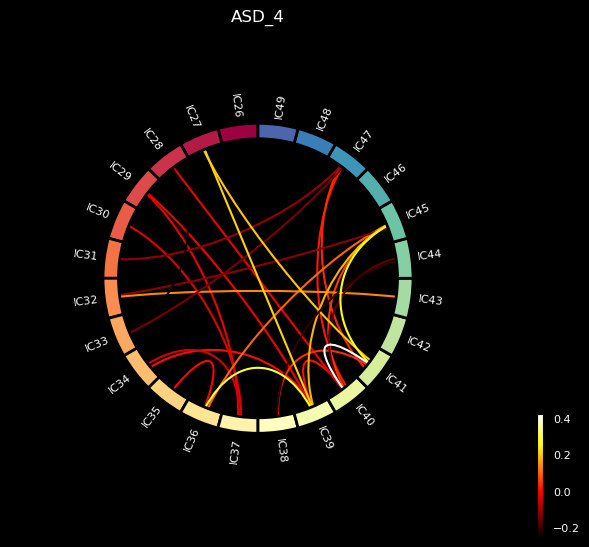

Number of distinct connectivities less than 0.05: 138
Number of significant connection within and between CC, DM networks :  21
Number of non zero values in the above matrix : 42
Shape of centroid of CC-DM networks only (24, 24)
Number of non zero values in the Centroid CC-DM matrix : 42


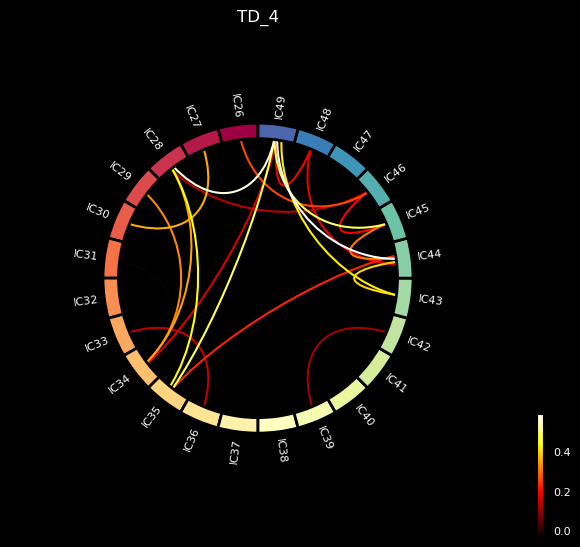

In [6]:
def plot_CC_DM_connections(state, centroid, title, group = None, format = 'png'):
    label_inds = np.array(range(1,54))
    centroid.index = label_inds
    centroid.columns = label_inds
    networks = ['CC-CC', 'CC-DM', 'DM-DM']
    if(group == None):
        state = state[state['Networks'].isin(networks)]
    else : 
        state = state[(state['Networks'].isin(networks)) & (state['Dominant_Group'] == group)]
    n = len(state)
    print('Number of significant connection within and between CC, DM networks : ', n)
    centroid_mat = np.zeros((53,53))
    for i in range(n):
        idx1 = state.iloc[i]['First_ROI_Index'].item()
        idx2 = state.iloc[i]['Second_ROI_Index'].item()
        assert idx1>=26 and idx1<=49, "Error!"
        assert idx2>=26 and idx2<=49, "Error!"
        centroid_mat[idx1-1, idx2-1] = centroid.loc[idx1][idx2].item()
        centroid_mat[idx2-1, idx1-1] = centroid.loc[idx2][idx1].item()

    print('Number of non zero values in the above matrix :', (centroid_mat!=0).sum())
    centroid_mat_cc_dm = centroid_mat[25:49, 25:49]
    print('Shape of centroid of CC-DM networks only', centroid_mat_cc_dm.shape)
    print('Number of non zero values in the Centroid CC-DM matrix :', (centroid_mat_cc_dm!=0).sum())
    nodes = ['IC' + str(node) for node in range(26,50)]
    utils.plot_connectogram(centroid_mat_cc_dm, nodes, n, title, format = format)
    return

for i in range(1,5):
    for group in ['ASD', 'TD']:
        state = pd.read_csv(f'./Phenotypes/States/State{i}_Analysis.csv')
        print(f"Number of distinct connectivities less than 0.05: {(state['P_Values'] < 0.05).sum()}")
        centroid = pd.read_csv(f'./Phenotypes/Centroids/{group}_SFC.csv', index_col='Unnamed: 0')
        plot_CC_DM_connections(state, centroid, title = f'{group}_{i}', group = group, format = 'svg')

In [ ]:
def plot_CC_DM_connections(state, centroid, title, group = None, format = 'png'):
    label_inds = np.array(range(1,54))
    centroid.index = label_inds
    centroid.columns = label_inds
    networks = ['CC-CC', 'CC-DM', 'DM-DM']
    if(group == None):
        state = state[state['Networks'].isin(networks)]
    else : 
        state = state[(state['Networks'].isin(networks)) & (state['Dominant_Group'] == group)]
    n = len(state)
    print('Number of significant connection within and between CC, DM networks : ', n)
    centroid_mat = np.zeros((53,53))
    for i in range(n):
        idx1 = state.iloc[i]['First_ROI_Index'].item()
        idx2 = state.iloc[i]['Second_ROI_Index'].item()
        assert idx1>=26 and idx1<=49, "Error!"
        assert idx2>=26 and idx2<=49, "Error!"
        centroid_mat[idx1-1, idx2-1] = centroid.loc[idx1][idx2].item()
        centroid_mat[idx2-1, idx1-1] = centroid.loc[idx2][idx1].item()

    print('Number of non zero values in the above matrix :', (centroid_mat!=0).sum())
    centroid_mat_cc_dm = centroid_mat[25:49, 25:49]
    print('Shape of centroid of CC-DM networks only', centroid_mat_cc_dm.shape)
    print('Number of non zero values in the Centroid CC-DM matrix :', (centroid_mat_cc_dm!=0).sum())
    nodes = ['IC' + str(node) for node in range(26,50)]
    utils.plot_connectogram(centroid_mat_cc_dm, nodes, n, title, format = format)
    return

for i in range(1,5):
    for group in ['ASD', 'TD']:
        state = pd.read_csv(f'./Phenotypes/States/State{i}_Analysis.csv')
        print(f"Number of distinct connectivities less than 0.05: {(state['P_Values'] < 0.05).sum()}")
        centroid = pd.read_csv(f'./Phenotypes/Centroids/{group}_SFC.csv', index_col='Unnamed: 0')
        plot_CC_DM_connections(state, centroid, title = f'{group}_{i}', group = group, format = 'svg')

# Classification

In [10]:
## Plotting ASD and TD centroids
cs = scipy.io.loadmat(path + 'Stats_L1_ws20_city/All_age_ccs__dfnc_cluster_stats.mat')
print('Cluster stats using GIFT mat file keys : ', cs.keys())
dfnc_corrs = cs['dfnc_corrs']
dfnc_corrs = np.squeeze(dfnc_corrs)
dfnc_corrs.shape           # (n_subjects, states_vector_length, n_states)

Cluster stats using GIFT mat file keys :  dict_keys(['__header__', '__version__', '__globals__', 'thresholdWindows', 'dfnc_corrs', 'state_vector_stats', 'nuisance_cov_file'])


(383, 1378, 4)

In [14]:
dfnc_dict = utils.get_groups_dfnc(dfnc_corrs, groups, n_states = 4, mode = 'all')
print('Keys in dfnc_dict : ', list(dfnc_dict.keys()))        # Keys = States
print('Keys in dfnc_dict[0] : ', list(dfnc_dict[0].keys()))  
print('Shape of dfnc_dict[0]["ASD"] : ',dfnc_dict[0]["ASD"].shape)
print('Shape of dfnc_dict[0]["TD"] : ',dfnc_dict[0]["TD"].shape)

State :  1
Group : ASD and DFNC shape : (59, 1378)
Group : TD and DFNC shape : (79, 1378)
------------------------------------------------
State :  2
Group : ASD and DFNC shape : (145, 1378)
Group : TD and DFNC shape : (165, 1378)
------------------------------------------------
State :  3
Group : ASD and DFNC shape : (131, 1378)
Group : TD and DFNC shape : (158, 1378)
------------------------------------------------
State :  4
Group : ASD and DFNC shape : (185, 1378)
Group : TD and DFNC shape : (187, 1378)
------------------------------------------------
Keys in dfnc_dict :  [0, 1, 2, 3]
Keys in dfnc_dict[0] :  ['ASD', 'TD']
Shape of dfnc_dict[0]["ASD"] :  (59, 1378)
Shape of dfnc_dict[0]["TD"] :  (79, 1378)


In [19]:
import pickle
asd = dfnc_dict[3]['ASD']
td = dfnc_dict[3]['TD']
asd_len = len(asd)
all_corr = {}
for i in range(asd_len):
    vec = asd[i]
    mat = utils.vec2mat(vec)
    mat_ccdm = mat[25:49, 25:49]
    vec_ccdm = utils.mat2vec(mat_ccdm)
    all_corr[i] = (vec_ccdm, 1)

for i in range(len(td)):
    vec = td[i]
    mat = utils.vec2mat(vec)
    mat_ccdm = mat[25:49, 25:49]
    vec_ccdm = utils.mat2vec(mat_ccdm)
    all_corr[i + asd_len] = (vec_ccdm, 0)

print('Length of correlations vector : ', len(all_corr))
pickle.dump(all_corr, open('./Classification/State4_CC_DM.pkl', 'wb'))


Length of correlations vector :  372


# Overlapping Connection

In [10]:
all = np.arange(1,1379)
for i in range(1,5):
    state = pd.read_csv(f'./Phenotypes/States/State{i}_Analysis.csv')
    conn = state['Connectivity_Index'].values
    all = np.intersect1d(all, conn)
    print(len(all))
print(len(all))

96
29
14
9
9


In [24]:
for i in range(1,5):
    state1 = pd.read_csv(f'./Phenotypes/States/State{i}_Analysis.csv')
    conn1 = state1['Connectivity_Index'].values
    for j in range(1,5):
        state2 = pd.read_csv(f'./Phenotypes/States/State{j}_Analysis.csv')
        conn2 = state2['Connectivity_Index'].values
        conn = np.intersect1d(conn1, conn2)
        print(f'State {i} and State {j} common connectinos : ', len(conn))

State 1 and State 1 common connectinos :  96
State 1 and State 2 common connectinos :  29
State 1 and State 3 common connectinos :  24
State 1 and State 4 common connectinos :  18
State 2 and State 1 common connectinos :  29
State 2 and State 2 common connectinos :  187
State 2 and State 3 common connectinos :  70
State 2 and State 4 common connectinos :  55
State 3 and State 1 common connectinos :  24
State 3 and State 2 common connectinos :  70
State 3 and State 3 common connectinos :  197
State 3 and State 4 common connectinos :  64
State 4 and State 1 common connectinos :  18
State 4 and State 2 common connectinos :  55
State 4 and State 3 common connectinos :  64
State 4 and State 4 common connectinos :  138
